In [1]:
# try:
#     !pip install fxpmath
# except:
#     pass
# !source /eos/user/m/mhufnage/.venv/bin/activate
# from IPython.display import clear_output

import json
import os,sys
import time
import shelve

## Insert here the path to EventReader/share
eventReaderSharePath = '/home/mhufnage/ATLAS_QT_XTALK/offline-ringer-dev/crosstalk/EventReader/share/'
sys.path.insert(1, eventReaderSharePath) 

## Insert here the path to xtalkDatasetAnalysis git package
sys.path.insert(1, '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/')


import numpy as np
import awkward as ak
import uproot
import mplhep as hep

from glob import glob
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib
plt.style.use([hep.style.ATLAS])
# from fxpmath import Fxp

# import mpl_scatter_density
import scipy.stats as scipy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader as torchDataLoader

from collections import OrderedDict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# import matplotlib.rcsetup as rcsetup
# print(rcsetup.all_backends)
# print(matplotlib.get_backend())
# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

## Custom Packages
from auxiliaryFunctions import *
from calibrationFilesHelper import *
from getXTDataAsPythonDict import *
from Autoencoder import *
from functionsHelper import *
from XTalkClusterModel import *
# from calibrationFilesHelperROOT import *

# import tensorflow

## Load custom Help libraries
fDict       = open(eventReaderSharePath+'dictCaloByLayer.json')
caloDict    = json.load(fDict)

Welcome to JupyROOT 6.24/08


In [7]:
## Online Calibration constants

ofc_dict = np.load('calibration/OFC_dict.npz',allow_pickle=True )['OFC'].tolist()
ped_dict = np.load('calibration/PED_dict.npz',allow_pickle=True )['PED'].tolist()
mpmc_dict = np.load('calibration/MPMC_dict.npz',allow_pickle=True )['MPMC'].tolist()
uamev_dict = np.load('calibration/UAMEV_dict.npz',allow_pickle=True )['UAMEV'].tolist()
ramps_dict = np.load('calibration/RAMPS_dict.npz',allow_pickle=True )['RAMPS'].tolist()

# 1.0) Read data and apply Online Calib

## Configure input files

In [7]:
# datasetPath = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/minbias_vertexAnalysis/*'
datasetPath ='/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_TagAndProbe_v01_XYZ.root.tgz/*XYZ.root'
# datasetPath = '/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_v01_XYZ.root.tgz/*XYZ.root'

#---------------------------------------------
#----------   Read the ROOT trees   ----------
#---------------------------------------------
fileNames       = glob(datasetPath)

sTree   = ROOT.TChain("dumpedData",'')
sLBTree = ROOT.TChain("lumiblockData",'')
for file in fileNames:
    fileNameInputLog = "/".join((file+" added to the TChain...").split('/')[-2:])
    # print(fileNameInputLog) 
    sTree.Add(file+"/dumpedData") # main dumped data tree (event by event)
    sLBTree.Add(file+"/lumiblockData") # LB tree (lumiblock per lumiblock)

nEvents         = sTree.GetEntries()
nLumiBlocks     = sLBTree.GetEntries()
print("{} files were added with {} events.".format(len(fileNames),nEvents))


53 files were added with 7739676 events.


## 1.1) Read Lumiblocks Tree

In [8]:
for evLB in range(0, nLumiBlocks):    
    lbinfo = getLBInfoAsPythonDict(sLBTree, evLB)

    # print(lumiblockDict['LumiBlock'][0],np.shape(lumiblockDict['LumiPerBCID'][0]))

## 1.2) Read EventLoop Tree

In [5]:
# start = time()
 
#---------------------------------------------
#--------- Data Analysis conditions ---------
#---------------------------------------------
resultFileAlias     = 'fullDatasetTP'
evt_lim             = nEvents
bPedFromDB          = True # Ped from DB (TRUE) or from Script (FALSE)
bFullWindows        = False # use only full windows from clusters
bDoOfflineCalib     = False
el_thrs             = [0] # GeV
# cell_ene_thr        = 500 # MeV (cut from every cell)
nCellsWinEta        = 5
nCellsWinPhi        = 5
# nCellsRawChEta      = 5
# nCellsRawChPhi      = 5
# clusNames           = ['711_roi', 'clusters'] #'clusters'
clusNames           = ['clusters']#,'711_roi'] #'clusters'
# calibTypes          = ['database', 'typical'] #'database'#'dumper' #'typical' # or 
calibTypes          = ['dumper'] # name of the type of calibration, to differentiate from offline or database (analysis/debug) #'database'#'database' #'typical' # or 
layers              = caloDict["Layer"][0:4]
#---------------------------------------------
#------------- DSP conditions #------------- < Not getting nice results from quantization. Ignore those *Quant* boolean options. >
#---------------------------------------------
typeThreshold       = 'EneThr'#'fixedValue'#'EneThr'#'NoiseSigma'#
bAbsDSPE1           = True  # use abs(E) to get E1, and compare to E_thr
bPerfomQuant        = False # ~X~ apply the quantized form of energy and time estimation (like DSP)
applyCteQuant       = False # ~X~ True # apply quantization to the alpha, beta, Pa, Pb. If False, use likeDSP function, but full precision constants.
reorderSamp         = False # ~X~ reorder samples like-dsp

if bPerfomQuant:
    na, nb, n           = getLArDSPnFactor(ofc_dict, ped_dict, ramps_dict,reorderSamples=reorderSamp) # n factor to convert Float to Fixed point Integer.
    print('na={}, nb={} and n={}'.format(na,nb,n))

#---------------------------------------------
#--------- Event and Data Reading ------------
#---------------------------------------------

for calibType in calibTypes:
    print('Calibration type: {}'.format(calibType))
    for el_thr in el_thrs:
        print('Electron pt cut: {} GeV'.format(el_thr))
        for clusName in clusNames:
            elec_counter    = 0 # counter of electrons in dataset
            print('Processing cluster: {}'.format(clusName))

            analysis   = [
                        # Particle / event
                        'datasetElectronIndex',

                        # Channel
                        'digitsWindow',
                        'digitsWindowSize',
                        'channelEnergyWindow',
                        'channelTimeWindow', 
                        # 'channelInfoWindow',
                        'channelBarrel_ec',
                        'channelPos_neg',
                        'channelFeedthrough',
                        'channelSlot', 
                        'channelNumber',
                        'channelIdWindow',
                        'channelGainWindow',
                        'channelEtaWindow',
                        'channelPhiWindow',
                        'channelEffSigmaWindow',

                        # Online Calib
                        'channelDSPThrWindow',
                        'channelRamps0Window',
                        'channelRamps1Window',
                        'channelPedWindow',
                        'channelPedDictWindow',
                        
                        # Offline calib
                        # 'channelShapeWindow',
                        # 'channelMinBiasAvgWindow',
                        # 'channelOfflHVWindow',
                        # 'channelEneRescWindow',

                        # Estimated values (using calib. constants)
                        'AWindow',
                        'tauDSPWindow',  # online (DSP) calibration
                        'EDSPCalibWindow',   # online (DSP) calibration
                        'tauDSPThrDiffWindow',
                        # 'eneDSPerrorCalib',
                        # 'tauDSPerrorCalib',
                        # 'eneOfflineWindow',
                        # 'tauOfflineWindow',

                        'rawChEnergyWindow',
                        'rawChTimeWindow',                  
                        'rawChInfoWindow',
                        'rawChIdWindow',
                        'rawChGainWindow',
                        'rawChDSPThrWindow',
                        'rawChEtaWindow',
                        'rawChPhiWindow',
                        'rawChProvWindow'
                        ]

            results                 = {key:{key1:[] for key1 in analysis} for key in layers}
            # Particle
            results['electron']     = {'datasetElectronIndex': [],'electronPt': [],'electronEta': [],'electronPhi': [],'electronVertexZ': [],'electronNClus': [],'electronClusSizes': []} # Electron data

            #---------------------------------------------
            #------ TTree Loop and data extraction -------
            #---------------------------------------------
            meanTimePerEvent = 0.0
            startTime = time()

            for evIndex in range(0, evt_lim): ## Loop events into TTree
                if evIndex > evt_lim:
                    break

                if (evIndex%int(evt_lim/10)) == 0:
                    # clear_output()
                    print("Event {}/{}...".format(evIndex,evt_lim))

                dataset = getXTDataAsPythonDict(sTree, evIndex, eventReaderSharePath, dataHasBadCh=True, isMC=False)

                if dataset==0: # Data has no electrons in this event!
                    continue

                for evtn, ev in enumerate(dataset['dataset']): # for each event...
                    for elec in ev['electrons'].keys(): # for each electron in this event...
                        # print(ev['electrons'][elec]['pt'])
                        if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
                            continue
                        if np.abs(ev['electrons'][elec]['eta']) > 1.4:
                            continue
                        
                        elec_counter+=1
                        elecClusSizes   = []

                        clusloop        = ev['electrons'][elec][clusName]

                        elecPt          = (ev['electrons'][elec]['pt'])
                        elecEta         = (ev['electrons'][elec]['eta'])
                        elecPhi         = (ev['electrons'][elec]['phi'])
                        elecVtxZ        = (ev['electrons'][elec]['vertexZ'])
                        elecNClus       = len(ev['electrons'][elec][clusName])

                        for clus in clusloop.keys(): # for each cluster associated to that electron...
                            elecClusSizes.append(len(ev['electrons'][elec][clusName][clus]['cells']['index'][0]))

                        # print('elecPt: ',elecPt)
                        # print('elecEta: ',elecEta)
                        # print('elecPhi: ',elecPhi)
                        # print('elecVtxZ: ',elecVtxZ)
                        # print('elecNClus: ',elecNClus)

                        results['electron']['electronPt']           .append(elecPt)
                        results['electron']['electronEta']          .append(elecEta)
                        results['electron']['electronPhi']          .append(elecPhi)
                        results['electron']['electronVertexZ']      .append(elecVtxZ)
                        results['electron']['electronNClus']        .append(elecNClus)
                        results['electron']['electronClusSizes']    .append(elecClusSizes)
                        results['electron']['datasetElectronIndex'] .append(elec_counter)
                        
                        for clus in clusloop.keys(): # for each cluster associated to that electron...                         

                            for layern, layer in enumerate(layers):
                                
                                # get list indexes that match to current sampling
                                channelLayerIndexes     = getMatchedIndexes(ev['electrons'][elec][clusName][clus]['channels']['sampling'][0], layer) 
                                rawChannelLayerIndexes  = getMatchedIndexes(ev['electrons'][elec][clusName][clus]['rawChannels']['sampling'][0], layer)

                                # is that layer empty for RAWCh or Ch? skip
                                if (len(channelLayerIndexes) == 0 ) or (len(rawChannelLayerIndexes)==0):
                                    continue

                                ###################     ###############
                                ## Channel + Digits  +  ## RawChannel #
                                ###################     ###############
                                windowIndexesCh, layerIndexesCh = getCellsInWindowCustomSize(
                                    ev['electrons'][elec][clusName][clus]['channels']['energy'],
                                    ev['electrons'][elec][clusName][clus]['channels']['index'],
                                    ev['electrons'][elec][clusName][clus]['channels']['eta'],
                                    ev['electrons'][elec][clusName][clus]['channels']['phi'],
                                    ev['electrons'][elec][clusName][clus]['channels']['sampling'],
                                    nCellsWinEta, 
                                    nCellsWinPhi, 
                                    ev['electrons'][elec][clusName][clus]['channels']['deta'],
                                    ev['electrons'][elec][clusName][clus]['channels']['dphi'],
                                    layer=layer)
                                

                                windowIndexesRawCh, layerIndexesRawCh = getCellsInWindowCustomSize(
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['index'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['eta'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['phi'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['sampling'],
                                    nCellsWinEta, 
                                    nCellsWinPhi, 
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['deta'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['dphi'],
                                    layer=layer)

                                # any of the windows aren't full??
                                if bFullWindows:
                                    if (len(windowIndexesCh) != (nCellsWinEta*nCellsWinPhi)) or (len(windowIndexesRawCh) != (nCellsWinEta*nCellsWinPhi)):
                                        continue

                                # if they belong to the same calo object and have the same size, they MUST have the same cells, because the dumper rule is the same.
                                # BUT, they cells aren't stored at the same order.
                                # First, lets check if their cells, in the current layer, are the same!
                                # print("Ok, both windows are full, lets check their cells. RawCh={}, Ch={}".format(len(windowIndexesRawCh),len(windowIndexesCh)))
                                digits              = np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)         [windowIndexesCh] .tolist()
                                digitsSize          = len (np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)    [windowIndexesCh] .tolist())
                                channelEnergy       = np.array(ev['electrons'][elec][clusName][clus]['channels']['energy'][0],dtype=object)         [windowIndexesCh] .tolist()
                                channelTime         = np.array(ev['electrons'][elec][clusName][clus]['channels']['time'][0],dtype=object)           [windowIndexesCh] .tolist()
                                channelInfo         = listOfListsToArrayOfArrays(np.array(ev['electrons'][elec][clusName][clus]['channels']['chInfo'][0],dtype=object)         [windowIndexesCh] .tolist())
                                channelId           = np.array(ev['electrons'][elec][clusName][clus]['channels']['channelId'][0],dtype=object)      [windowIndexesCh] .tolist()
                                channelSampling     = np.array(ev['electrons'][elec][clusName][clus]['channels']['sampling'][0],dtype=object)       [windowIndexesCh] .tolist()
                                channelEta          = np.array(ev['electrons'][elec][clusName][clus]['channels']['eta'][0],dtype=object)            [windowIndexesCh] .tolist()
                                channelPhi          = np.array(ev['electrons'][elec][clusName][clus]['channels']['phi'][0],dtype=object)            [windowIndexesCh] .tolist()
                                channelGain         = np.array(ev['electrons'][elec][clusName][clus]['channels']['gain'][0],dtype=object)           [windowIndexesCh] .tolist()
                                channelEffSigma     = np.array(ev['electrons'][elec][clusName][clus]['channels']['effSigma'][0],dtype=object)       [windowIndexesCh] .tolist()
                                # channelNoise        = np.array(ev['electrons'][elec][clusName][clus]['channels']['noise'][0],dtype=object)          [windowIndexesCh] .tolist()
                                channelDSPThr       = np.array(ev['electrons'][elec][clusName][clus]['channels']['DSPThreshold'][0],dtype=object)   [windowIndexesCh] .tolist()
                                channelOFCa         = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCa'][0],dtype=object)           [windowIndexesCh] .tolist()
                                channelOFCb         = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCb'][0],dtype=object)           [windowIndexesCh] .tolist()
                                channelRamps0       = np.array(ev['electrons'][elec][clusName][clus]['channels']['ADC2MeV0'][0],dtype=object)       [windowIndexesCh] .tolist()
                                channelRamps1       = np.array(ev['electrons'][elec][clusName][clus]['channels']['ADC2MeV1'][0],dtype=object)       [windowIndexesCh] .tolist()
                                channelLArPed       = np.array(ev['electrons'][elec][clusName][clus]['channels']['LArDB_Pedestal'][0],dtype=object) [windowIndexesCh] .tolist()
                                channelTimeOffset   = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCTimeOffset'][0],dtype=object)  [windowIndexesCh] .tolist()
                                channelEffSigma     = np.array(ev['electrons'][elec][clusName][clus]['channels']['effSigma'][0],dtype=object)       [windowIndexesCh] .tolist()
                                channelNoise        = np.array(ev['electrons'][elec][clusName][clus]['channels']['noise'][0],dtype=object)          [windowIndexesCh] .tolist()
                                # channelShape        = np.array(ev['electrons'][elec][clusName][clus]['channels']['Shape'][0],dtype=object)          [windowIndexesCh] .tolist()
                                if bDoOfflineCalib:
                                    channelMinBiasAvg   = np.array(ev['electrons'][elec][clusName][clus]['channels']['MinBiasAvg'][0],dtype=object)     [windowIndexesCh] .tolist()
                                    channelOfflHV       = np.array(ev['electrons'][elec][clusName][clus]['channels']['OfflHVScale'][0],dtype=object)    [windowIndexesCh] .tolist()
                                    channelEneResc      = np.array(ev['electrons'][elec][clusName][clus]['channels']['OfflEneRescaler'][0],dtype=object)[windowIndexesCh] .tolist()

                                rawChEnergyDSP    = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)      # this is not the amplitude, it is the E_dsp
                                rawChTimeDSP      = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['time'][0],dtype=object)          
                                rawChInfo         = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['chInfo'][0],dtype=object)        
                                rawChId           = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['channelId'][0],dtype=object)     
                                rawChDSPThr       = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['DSPThreshold'][0],dtype=object) 
                                rawChEta          = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['eta'][0],dtype=object) 
                                rawChPhi          = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['phi'][0],dtype=object)
                                rawChProv         = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['LAr_Provenance'][0],dtype=object)

                                # Selection of Pedestal (DB or Script)
                                if not(bPedFromDB):
                                    peds = [] #testing
                                    gainsInt = getGainInteger(channelGain)
                                if bPedFromDB:
                                    peds = channelLArPed
                                
                                # The cells that came from Window algorithm are not the same when comparing RawCh and Digits.
                                # For that, we will select the same Digits cells set, based on the HWID, inside the Raw Channel cluster cells set. 
                                mirrorIndexes = []
                                for k, hwid in enumerate(channelId):
                                    position        = np.where(rawChId[layerIndexesRawCh] == hwid)[0][0]
                                    mirrorIndexes.append(position) # its the window mirrored indexes for RawCh
                                    if not(bPedFromDB):
                                        cell_dict_ped   = getLArChannelPED  (hwid, ped_dict  )
                                        peds.append(cell_dict_ped['ped'][0][gainsInt[k]]) # picking up the right gain weights
                                

                                # do the software DSP estimation  
                                Awin, tauDSPWin, EDSPWin, tauDSPWin_thrDiff = DSPCalibSamplesInCluster(channelId, digits, channelGain, peds, channelOFCa, channelOFCb, channelRamps0, channelRamps1, channelDSPThr, channelTimeOffset,  thresholdMode=typeThreshold, bDoAbsE1=bAbsDSPE1)
                                # add here the offline calibration (not working yet)
                                if bDoOfflineCalib:
                                    offl_pileupOffset   = 0 # getOfflinePileUpOffset(evt_lumiblock, lumiPerBCIDVector, evt_bcid, minBiasAvgs, ofcas, shapes)
                                    offl_tauOffset      = 0
                                    offl_ene, offl_tau  = offlineCalibInCluster(EDSPWin, tauDSPWin, channelOfflHV, channelEneResc, offl_pileupOffset, offl_tauOffset)

                                # Save variables to posterior analysis
                                results[layer]['datasetElectronIndex']      .append(elec_counter        )

                                results[layer]['digitsWindow']              .append(digits              )
                                results[layer]['digitsWindowSize']          .append(digitsSize          )
                                results[layer]['channelEnergyWindow']       .append(channelEnergy       )
                                results[layer]['channelTimeWindow']         .append(channelTime         )
                                # results[layer]['channelInfoWindow']         .append(channelInfo         )
                                results[layer]['channelIdWindow']           .append(channelId           )
                                results[layer]['channelGainWindow']         .append(channelGain         )
                                results[layer]['channelEffSigmaWindow']     .append(channelEffSigma     )
                                # results[layer]['channelNoiseWindow']        .append(channelNoise        )
                                results[layer]['channelDSPThrWindow']       .append(channelDSPThr       )
                                results[layer]['channelEtaWindow']          .append(channelEta          )
                                results[layer]['channelPhiWindow']          .append(channelPhi          )
                                results[layer]['channelRamps0Window']       .append(channelRamps0       )
                                results[layer]['channelRamps1Window']       .append(channelRamps1       )
                                results[layer]['channelPedWindow']          .append(channelLArPed       )
                                results[layer]['channelPedDictWindow']      .append(peds                )

                                if len(channelInfo)==0:
                                    results[layer]['channelBarrel_ec']          .append([]                  )
                                    results[layer]['channelPos_neg']            .append([]                  )
                                    results[layer]['channelFeedthrough']        .append([]                  )
                                    results[layer]['channelSlot']               .append([]                  )
                                    results[layer]['channelNumber']             .append([]                  )                                    
                                else:
                                    results[layer]['channelBarrel_ec']          .append(channelInfo[:,0]    )
                                    results[layer]['channelPos_neg']            .append(channelInfo[:,1]    )
                                    results[layer]['channelFeedthrough']        .append(channelInfo[:,2]    )
                                    results[layer]['channelSlot']               .append(channelInfo[:,3]    )
                                    results[layer]['channelNumber']             .append(channelInfo[:,4]    )
                                    

                                results[layer]['AWindow']            .append(Awin               )
                                results[layer]['tauDSPWindow']       .append(tauDSPWin          )
                                results[layer]['EDSPCalibWindow']    .append(EDSPWin            )
                                results[layer]['tauDSPThrDiffWindow'].append(tauDSPWin_thrDiff  )

                                results[layer]['rawChEnergyWindow']  .append(rawChEnergyDSP [layerIndexesRawCh][mirrorIndexes])    
                                results[layer]['rawChTimeWindow']    .append(rawChTimeDSP   [layerIndexesRawCh][mirrorIndexes])    
                                results[layer]['rawChInfoWindow']    .append(rawChInfo      [layerIndexesRawCh][mirrorIndexes])    
                                results[layer]['rawChIdWindow']      .append(rawChId        [layerIndexesRawCh][mirrorIndexes])
                                results[layer]['rawChDSPThrWindow']  .append(rawChDSPThr    [layerIndexesRawCh][mirrorIndexes])
                                results[layer]['rawChEtaWindow']     .append(rawChEta       [layerIndexesRawCh][mirrorIndexes])
                                results[layer]['rawChPhiWindow']     .append(rawChPhi       [layerIndexesRawCh][mirrorIndexes])
                                results[layer]['rawChProvWindow']    .append(rawChProv      [layerIndexesRawCh][mirrorIndexes])

                        # print('elecClusSizes: ', elecClusSizes)
                #----------------------- TESTE AREA -----------------------
                # break # exiting test loop here!
                #--------------------------------------------------------------
                
            confDict = {
                'el_thr': el_thr,
                'elec_counter':elec_counter,
                'nCellsChEta': nCellsWinEta,
                'nCellsChPhi': nCellsWinPhi,
                'nCellsRawChEta': nCellsWinEta,
                'nCellsRawChPhi': nCellsWinPhi,
                'datasetPath': datasetPath,
                'calibType': calibType,
                'bFullWindows': bFullWindows,
                'bPedFromDB':   bPedFromDB,
                'bDoOfflineCalib': bDoOfflineCalib,
                'typeThreshold': typeThreshold,
                'bAbsDSPE1': bAbsDSPE1,
                'bPerfomQuant': bPerfomQuant,
                'applyCteQuant': applyCteQuant,
                'reorderSamp': reorderSamp,
                'fileNames': fileNames
            }
            
                # print(results.keys())
            resultFileName        = 'calibration/vertex_results_analysis_{}_{}_{}_eCut{}GeV.npz'.format(resultFileAlias, clusName,calibType,el_thr)
            resultConfFileName    = 'calibration/vertex_conf_analysis_{}_{}_{}_eCut{}GeV.npz'.format(resultFileAlias, clusName,calibType,el_thr)
            np.savez(resultFileName,**results)
            np.savez(resultConfFileName,conf=confDict)
  
endTime = time()
print("Total running time: {:.2f} minutes. ({:.2f} us/event)".format((endTime - startTime)/60, (endTime - startTime)/3600*1000000/evt_lim))
print("File {} saved.".format(resultFileName))
print("Conf. file {} saved.".format(resultConfFileName))
                    


Calibration type: dumper
Electron pt cut: 0 GeV
Processing cluster: clusters
Event 0/7739676...
Event 773967/7739676...
Event 1547934/7739676...
Event 2321901/7739676...
Event 3095868/7739676...
Event 3869835/7739676...
Event 4643802/7739676...
Event 5417769/7739676...
Event 6191736/7739676...
Event 6965703/7739676...


PermissionError: [Errno 1] Operation not permitted: '/eos/user/m/mhufnage/ALP_project/offline-ringer-dev/crosstalk/EventReader/share/dictCaloByLayer.json'

## 1.3) Read Big Data and Save in split mode

In [8]:
# start = time()

# resultFileAliases     = ['vertexFullTPZeeTauUpdated2']
resultFileAliases     = ['vertexFullSingleElectronTEST']

for resultFileAlias in resultFileAliases:
    #---------------------------------------------
    #----------   Read the ROOT trees   ----------
    #---------------------------------------------
    if 'vertexFullTPZee' in resultFileAlias:
        datasetPath ='/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_TagAndProbe_v01_XYZ.root.tgz/*XYZ.root'
    if 'vertexFullSingleElectron' in resultFileAlias:
        datasetPath = '/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_v01_XYZ.root.tgz/*XYZ.root'

    fileNames       = glob(datasetPath)

    sTree   = ROOT.TChain("dumpedData",'')
    sLBTree = ROOT.TChain("lumiblockData",'')
    for file in fileNames:
        fileNameInputLog = "/".join((file+" added to the TChain...").split('/')[-2:])
        # print(fileNameInputLog) 
        sTree.Add(file+"/dumpedData") # main dumped data tree (event by event)
        sLBTree.Add(file+"/lumiblockData") # LB tree (lumiblock per lumiblock)

    nEvents         = sTree.GetEntries()
    nLumiBlocks     = sLBTree.GetEntries()
    print("{} files were added with {} events.".format(len(fileNames),nEvents))

    
    #---------------------------------------------
    #--------- Data Analysis conditions ---------
    #---------------------------------------------
    evt_lim             = 2000#nEvents
    bPedFromDB          = True # Ped from DB (TRUE) or from Script (FALSE)
    bFullWindows        = False # use only full windows from clusters
    bDoOfflineCalib     = False
    el_thrs             = [10] # GeV
    # cell_ene_thr        = 500 # MeV (cut from every cell)
    nCellsWinEta         = 3
    nCellsWinPhi         = 3
    # nCellsRawChEta      = 5
    # nCellsRawChPhi      = 5
    # clusNames           = ['711_roi', 'clusters'] #'clusters'
    clusNames           = ['clusters']#,'711_roi'] #'clusters'
    # calibTypes          = ['database', 'typical'] #'database'#'dumper' #'typical' # or 
    calibTypes          = ['dumper'] # name of the type of calibration, to differentiate from offline or database (analysis/debug) #'database'#'database' #'typical' # or 
    layers              = caloDict["Layer"][0:4]
    #---------------------------------------------
    #------------- DSP conditions #------------- < Not getting nice results from quantization. Ignore those *Quant* boolean options. >
    #---------------------------------------------
    typeThreshold       = 'EneThr'#'fixedValue'#'EneThr'#'NoiseSigma'#
    bAbsDSPE1           = False # ~X~ use abs(E) to get E1, and compare to E_thr
    bPerfomQuant        = False # ~X~ apply the quantized form of energy and time estimation (like DSP)
    applyCteQuant       = False # ~X~ True # apply quantization to the alpha, beta, Pa, Pb. If False, use likeDSP function, but full precision constants.
    reorderSamp         = False # ~X~ reorder samples like-dsp

    if bPerfomQuant:
        na, nb, n           = getLArDSPnFactor(ofc_dict, ped_dict, ramps_dict,reorderSamples=reorderSamp) # n factor to convert Float to Fixed point Integer.
        print('na={}, nb={} and n={}'.format(na,nb,n))

    #---------------------------------------------
    #--------- Event and Data Reading ------------
    #---------------------------------------------

    for calibType in calibTypes:
        print('Calibration type: {}'.format(calibType))
        for el_thr in el_thrs:
            print('Electron pt cut: {} GeV'.format(el_thr))
            for clusName in clusNames:
                elec_counter    = 0 # counter of electrons in dataset
                print('Processing cluster: {}'.format(clusName))


                #---------------------------------------------
                #----- File open and saving with shelve ------
                #---------------------------------------------

                resultFileName        = 'calibration/vertex_results_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.db'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)
                # resultConfFileName    = 'calibration/vertex_conf_analysis_{}_{}_{}_eCut{}GeV.npz'.format(resultFileAlias, clusName,calibType,el_thr)

                resultsDictMirror   = getDictForAnalysis(layers, type='full') # mount the analysis dict.
                results             = shelve.open(resultFileName ,writeback=True)
                # results['dataset']  = resultsDictMirror
                results.update(resultsDictMirror)

                
                #---------------------------------------------
                #------ TTree Loop and data extraction -------
                #---------------------------------------------
                meanTimePerEvent = 0.0
                startTime = time()

                for evIndex in range(0, evt_lim): ## Loop events into TTree
                    if evIndex > evt_lim:
                        break

                    if (evIndex%int(evt_lim/50)) == 0:
                        # clear_output()
                        print("Event {}/{}...".format(evIndex,evt_lim))
                        results.sync() # sync to free the buffer

                    dataset = getXTDataAsPythonDict(sTree, evIndex, eventReaderSharePath, dataHasBadCh=True, isMC=False)

                    if dataset==0: # Data has no electrons in this event!
                        continue
                    # print('Found an electron!')

                    for evtn, ev in enumerate(dataset['dataset']): # for each event...
                        for elec in ev['electrons'].keys(): # for each electron in this event...
                            # print(ev['electrons'][elec]['pt'])
                            if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
                                continue
                            if np.abs(ev['electrons'][elec]['eta']) > 1.4:
                                continue
                            
                            elec_counter+=1
                            elecClusSizes   = []

                            clusloop        = ev['electrons'][elec][clusName]

                            elecPt          = (ev['electrons'][elec]['pt'])
                            elecEta         = (ev['electrons'][elec]['eta'])
                            elecPhi         = (ev['electrons'][elec]['phi'])
                            elecVtxZ        = (ev['electrons'][elec]['vertexZ'])
                            elecNClus       = len(ev['electrons'][elec][clusName])

                            for clus in clusloop.keys(): # for each cluster associated to that electron...
                                elecClusSizes.append(len(ev['electrons'][elec][clusName][clus]['cells']['index'][0]))

                            # print('elecPt: ',elecPt)
                            # print('elecEta: ',elecEta)
                            # print('elecPhi: ',elecPhi)
                            # print('elecVtxZ: ',elecVtxZ)
                            # print('elecNClus: ',elecNClus)

                            results['electron']['electronPt']           .append(elecPt)
                            results['electron']['electronEta']          .append(elecEta)
                            results['electron']['electronPhi']          .append(elecPhi)
                            results['electron']['electronVertexZ']      .append(elecVtxZ)
                            results['electron']['electronNClus']        .append(elecNClus)
                            results['electron']['electronClusSizes']    .append(elecClusSizes)
                            results['electron']['datasetElectronIndex'] .append(elec_counter)
                            
                            for clus in clusloop.keys(): # for each cluster associated to that electron...                         

                                for layern, layer in enumerate(layers):
                                    
                                    # get list indexes that match to current sampling
                                    channelLayerIndexes     = getMatchedIndexes(ev['electrons'][elec][clusName][clus]['channels']['sampling'][0], layer) 
                                    rawChannelLayerIndexes  = getMatchedIndexes(ev['electrons'][elec][clusName][clus]['rawChannels']['sampling'][0], layer)

                                    # is that layer empty for RAWCh or Ch? skip
                                    if (len(channelLayerIndexes) == 0 ) or (len(rawChannelLayerIndexes)==0):
                                        continue

                                    ###################     ###############
                                    ## Channel + Digits  +  ## RawChannel #
                                    ###################     ###############
                                    windowIndexesCh, layerIndexesCh = getCellsInWindowCustomSize(
                                        ev['electrons'][elec][clusName][clus]['channels']['energy'],
                                        ev['electrons'][elec][clusName][clus]['channels']['index'],
                                        ev['electrons'][elec][clusName][clus]['channels']['eta'],
                                        ev['electrons'][elec][clusName][clus]['channels']['phi'],
                                        ev['electrons'][elec][clusName][clus]['channels']['sampling'],
                                        nCellsWinEta, 
                                        nCellsWinPhi, 
                                        ev['electrons'][elec][clusName][clus]['channels']['deta'],
                                        ev['electrons'][elec][clusName][clus]['channels']['dphi'],
                                        layer=layer)
                                    

                                    windowIndexesRawCh, layerIndexesRawCh = getCellsInWindowCustomSize(
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'],
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['index'],
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['eta'],
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['phi'],
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['sampling'],
                                        nCellsWinEta, 
                                        nCellsWinPhi, 
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['deta'],
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['dphi'],
                                        layer=layer)

                                    # any of the windows aren't full??
                                    if bFullWindows:
                                        if (len(windowIndexesCh) != (nCellsWinEta*nCellsWinPhi)) or (len(windowIndexesRawCh) != (nCellsWinEta*nCellsWinPhi)):
                                            continue

                                    # if they belong to the same calo object and have the same size, they MUST have the same cells, because the dumper rule is the same.
                                    # BUT, they cells aren't stored at the same order.
                                    # First, lets check if their cells, in the current layer, are the same!
                                    # print("Ok, both windows are full, lets check their cells. RawCh={}, Ch={}".format(len(windowIndexesRawCh),len(windowIndexesCh)))
                                    digits              = np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)         [windowIndexesCh] .tolist()
                                    digitsSize          = len (np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)    [windowIndexesCh] .tolist())
                                    channelEnergy       = np.array(ev['electrons'][elec][clusName][clus]['channels']['energy'][0],dtype=object)         [windowIndexesCh] .tolist()
                                    channelTime         = np.array(ev['electrons'][elec][clusName][clus]['channels']['time'][0],dtype=object)           [windowIndexesCh] .tolist()
                                    channelInfo         = listOfListsToArrayOfArrays(np.array(ev['electrons'][elec][clusName][clus]['channels']['chInfo'][0],dtype=object)         [windowIndexesCh] .tolist())
                                    channelId           = np.array(ev['electrons'][elec][clusName][clus]['channels']['channelId'][0],dtype=object)      [windowIndexesCh] .tolist()
                                    channelSampling     = np.array(ev['electrons'][elec][clusName][clus]['channels']['sampling'][0],dtype=object)       [windowIndexesCh] .tolist()
                                    channelEta          = np.array(ev['electrons'][elec][clusName][clus]['channels']['eta'][0],dtype=object)            [windowIndexesCh] .tolist()
                                    channelPhi          = np.array(ev['electrons'][elec][clusName][clus]['channels']['phi'][0],dtype=object)            [windowIndexesCh] .tolist()
                                    channelGain         = np.array(ev['electrons'][elec][clusName][clus]['channels']['gain'][0],dtype=object)           [windowIndexesCh] .tolist()
                                    channelDSPThr       = np.array(ev['electrons'][elec][clusName][clus]['channels']['DSPThreshold'][0],dtype=object)   [windowIndexesCh] .tolist()
                                    channelOFCa         = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCa'][0],dtype=object)           [windowIndexesCh] .tolist()
                                    channelOFCb         = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCb'][0],dtype=object)           [windowIndexesCh] .tolist()
                                    channelRamps0       = np.array(ev['electrons'][elec][clusName][clus]['channels']['ADC2MeV0'][0],dtype=object)       [windowIndexesCh] .tolist()
                                    channelRamps1       = np.array(ev['electrons'][elec][clusName][clus]['channels']['ADC2MeV1'][0],dtype=object)       [windowIndexesCh] .tolist()
                                    channelLArPed       = np.array(ev['electrons'][elec][clusName][clus]['channels']['LArDB_Pedestal'][0],dtype=object) [windowIndexesCh] .tolist()
                                    channelTimeOffset   = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCTimeOffset'][0],dtype=object)  [windowIndexesCh] .tolist()
                                    channelEffSigma     = np.array(ev['electrons'][elec][clusName][clus]['channels']['effSigma'][0],dtype=object)       [windowIndexesCh] .tolist()
                                    channelNoise        = np.array(ev['electrons'][elec][clusName][clus]['channels']['noise'][0],dtype=object)          [windowIndexesCh] .tolist()
                                    # channelShape        = np.array(ev['electrons'][elec][clusName][clus]['channels']['Shape'][0],dtype=object)          [windowIndexesCh] .tolist()
                                    if bDoOfflineCalib:
                                        channelMinBiasAvg   = np.array(ev['electrons'][elec][clusName][clus]['channels']['MinBiasAvg'][0],dtype=object)     [windowIndexesCh] .tolist()
                                        channelOfflHV       = np.array(ev['electrons'][elec][clusName][clus]['channels']['OfflHVScale'][0],dtype=object)    [windowIndexesCh] .tolist()
                                        channelEneResc      = np.array(ev['electrons'][elec][clusName][clus]['channels']['OfflEneRescaler'][0],dtype=object)[windowIndexesCh] .tolist()

                                    rawChEnergyDSP    = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)      # this is not the amplitude, it is the E_dsp
                                    rawChTimeDSP      = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['time'][0],dtype=object)          
                                    rawChInfo         = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['chInfo'][0],dtype=object)        
                                    rawChId           = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['channelId'][0],dtype=object)     
                                    rawChDSPThr       = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['DSPThreshold'][0],dtype=object) 
                                    rawChEta          = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['eta'][0],dtype=object) 
                                    rawChPhi          = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['phi'][0],dtype=object)
                                    rawChProv         = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['LAr_Provenance'][0],dtype=object)

                                    # Selection of Pedestal (DB or Script)
                                    if not(bPedFromDB):
                                        peds = [] #testing
                                        gainsInt = getGainInteger(channelGain)
                                    if bPedFromDB:
                                        peds = channelLArPed
                                    
                                    # The cells that came from Window algorithm are not the same when comparing RawCh and Digits.
                                    # For that, we will select the same Digits cells set, based on the HWID, inside the Raw Channel cluster cells set. 
                                    mirrorIndexes = []
                                    for k, hwid in enumerate(channelId):
                                        position        = np.where(rawChId[layerIndexesRawCh] == hwid)[0][0]
                                        mirrorIndexes.append(position) # its the window mirrored indexes for RawCh
                                        if not(bPedFromDB):
                                            cell_dict_ped   = getLArChannelPED  (hwid, ped_dict  )
                                            peds.append(cell_dict_ped['ped'][0][gainsInt[k]]) # picking up the right gain weights
                                    

                                    # do the software DSP estimation  
                                    Awin, tauDSPWin, EDSPWin, tauDSPWin_thrDiff = DSPCalibSamplesInCluster(channelId, digits, channelGain, peds, channelOFCa, channelOFCb, channelRamps0, channelRamps1, channelDSPThr, channelTimeOffset,  thresholdMode=typeThreshold, bDoAbsE1=bAbsDSPE1)
                                    # add here the offline calibration (not working yet)
                                    if bDoOfflineCalib:
                                        offl_pileupOffset   = 0 # getOfflinePileUpOffset(evt_lumiblock, lumiPerBCIDVector, evt_bcid, minBiasAvgs, ofcas, shapes)
                                        offl_tauOffset      = 0
                                        offl_ene, offl_tau  = offlineCalibInCluster(EDSPWin, tauDSPWin, channelOfflHV, channelEneResc, offl_pileupOffset, offl_tauOffset)

                                    # Save variables to posterior analysis
                                    results[layer]['datasetElectronIndex']      .append(elec_counter        )

                                    results[layer]['digitsWindow']              .append(digits              )
                                    results[layer]['digitsWindowSize']          .append(digitsSize          )
                                    results[layer]['channelEnergyWindow']       .append(channelEnergy       )
                                    results[layer]['channelTimeWindow']         .append(channelTime         )
                                    # results[layer]['channelInfoWindow']         .append(channelInfo         )
                                    results[layer]['channelIdWindow']           .append(channelId           )
                                    results[layer]['channelGainWindow']         .append(channelGain         )
                                    results[layer]['channelEffSigmaWindow']     .append(channelEffSigma     )
                                    # results[layer]['channelNoiseWindow']        .append(channelNoise        )
                                    results[layer]['channelDSPThrWindow']       .append(channelDSPThr       )
                                    results[layer]['channelEtaWindow']          .append(channelEta          )
                                    results[layer]['channelPhiWindow']          .append(channelPhi          )
                                    results[layer]['channelRamps0Window']       .append(channelRamps0       )
                                    results[layer]['channelRamps1Window']       .append(channelRamps1       )
                                    results[layer]['channelPedWindow']          .append(channelLArPed       )
                                    results[layer]['channelPedDictWindow']      .append(peds                )

                                    if len(channelInfo)==0:
                                        results[layer]['channelBarrel_ec']          .append([]                  )
                                        results[layer]['channelPos_neg']            .append([]                  )
                                        results[layer]['channelFeedthrough']        .append([]                  )
                                        results[layer]['channelSlot']               .append([]                  )
                                        results[layer]['channelNumber']             .append([]                  )                                    
                                    else:
                                        results[layer]['channelBarrel_ec']          .append(channelInfo[:,0]    )
                                        results[layer]['channelPos_neg']            .append(channelInfo[:,1]    )
                                        results[layer]['channelFeedthrough']        .append(channelInfo[:,2]    )
                                        results[layer]['channelSlot']               .append(channelInfo[:,3]    )
                                        results[layer]['channelNumber']             .append(channelInfo[:,4]    )
                                        

                                    results[layer]['AWindow']            .append(Awin               )
                                    results[layer]['tauDSPWindow']       .append(tauDSPWin          )
                                    results[layer]['EDSPCalibWindow']    .append(EDSPWin            )
                                    results[layer]['tauDSPThrDiffWindow'].append(tauDSPWin_thrDiff  )

                                    results[layer]['rawChEnergyWindow']  .append(rawChEnergyDSP [layerIndexesRawCh][mirrorIndexes])    
                                    results[layer]['rawChTimeWindow']    .append(rawChTimeDSP   [layerIndexesRawCh][mirrorIndexes])    
                                    results[layer]['rawChInfoWindow']    .append(rawChInfo      [layerIndexesRawCh][mirrorIndexes])    
                                    results[layer]['rawChIdWindow']      .append(rawChId        [layerIndexesRawCh][mirrorIndexes])
                                    results[layer]['rawChDSPThrWindow']  .append(rawChDSPThr    [layerIndexesRawCh][mirrorIndexes])
                                    results[layer]['rawChEtaWindow']     .append(rawChEta       [layerIndexesRawCh][mirrorIndexes])
                                    results[layer]['rawChPhiWindow']     .append(rawChPhi       [layerIndexesRawCh][mirrorIndexes])
                                    results[layer]['rawChProvWindow']    .append(rawChProv      [layerIndexesRawCh][mirrorIndexes])

                            # print('elecClusSizes: ', elecClusSizes)
                    #----------------------- TESTE AREA -----------------------
                    # break # exiting test loop here!
                    #--------------------------------------------------------------
                    
                confDict = {
                    'el_thr': el_thr,
                    'elec_counter':elec_counter,
                    'nCellsChEta': nCellsWinEta,
                    'nCellsChPhi': nCellsWinPhi,
                    'nCellsRawChEta': nCellsWinEta,
                    'nCellsRawChPhi': nCellsWinPhi,
                    'datasetPath': datasetPath,
                    'calibType': calibType,
                    'bFullWindows': bFullWindows,
                    'bPedFromDB':   bPedFromDB,
                    'bDoOfflineCalib': bDoOfflineCalib,
                    'typeThreshold': typeThreshold,
                    'bAbsDSPE1': bAbsDSPE1,
                    'bPerfomQuant': bPerfomQuant,
                    'applyCteQuant': applyCteQuant,
                    'reorderSamp': reorderSamp,
                    'fileNames': fileNames
                }
                results.close()

                print(confDict)
                # resultFileName        = 'calibration/vertex_results_analysis_{}_{}_{}_eCut{}GeV.npz'.format(resultFileAlias, clusName,calibType,el_thr)
                resultConfFileName    = 'calibration/vertex_conf_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.npz'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)
                # np.savez(resultFileName,**results)
                np.savez(resultConfFileName,conf=confDict)
    
    endTime = time()
    print("Total running time: {:.2f} minutes. ({:.2f} us/event)".format((endTime - startTime)/60, (endTime - startTime)/3600*1000000/evt_lim))
    print("File {} saved.".format(resultFileName))
    print("Conf. file {} saved.".format(resultConfFileName))
                        


56 files were added with 8573826 events.
Calibration type: dumper
Electron pt cut: 10 GeV
Processing cluster: clusters
Event 0/200000...
Event 4000/200000...
Event 8000/200000...
Event 12000/200000...
Event 16000/200000...
Event 20000/200000...
Event 24000/200000...
Event 28000/200000...
Event 32000/200000...
Event 36000/200000...
Event 40000/200000...
Event 44000/200000...
Event 48000/200000...
Event 52000/200000...
Event 56000/200000...
Event 60000/200000...
Event 64000/200000...
Event 68000/200000...
Event 72000/200000...
Event 76000/200000...
Event 80000/200000...
Event 84000/200000...
Event 88000/200000...
Event 92000/200000...
Event 96000/200000...
Event 100000/200000...
Event 104000/200000...
Event 108000/200000...
Event 112000/200000...
Event 116000/200000...
Event 120000/200000...
Event 124000/200000...
Event 128000/200000...
Event 132000/200000...
Event 136000/200000...
Event 140000/200000...
Event 144000/200000...
Event 148000/200000...
Event 152000/200000...
Event 156000/20

# 2.0) Configure Analysis plots

In [3]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
# matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

bDebugLogCells              = False
bClearOlderPlots            = True

# ----- Data Config -------
resultFileAliases   = ['vertexFullSingleElectronTEST']#['vertexFullTPZee']#['vertexFullSingleElectronTEST']#,'vertexFullTPZeeTauUpdated2']
nCellsWinEta        = 5
nCellsWinPhi        = 5
el_thr              = 10 #GeV
calibType           = 'dumper'#['typical', 'database','dumper']
clusNames           = ['clusters']#, '711_roi']
layers              = caloDict['Layer'][0:4]

# ----- Analysis Settings -------
xbins               = 40
cellEneCut          = 256 #MeV
sigmaEneCut         = 4

# ----- Plot settings -------
bTransparentBGOutputFile    = False
bFacecolor                  = 'white'
fileType                    = '.png'
labelFontSize               = 14
plotFolderAlias             = 'analysis4_TP_win{}-{}'.format(nCellsWinEta,nCellsWinPhi)

# ----- Pre-Running scripts -------
# if bClearOlderPlots:
#     command = 'calibration/calibPlots/'+plotFolderAlias+'/*'
#     os.system("echo rm $PWD/"+command)
#     os.system(command)
#     # os.system('$PWD')


## 2.1) Test Energy

In [4]:
# xbins            = 60
# Vmin             = 1
# Vmax             = 20

plot_keys_ene    = ['channelEnergyWindow','EDSPCalibWindow','rawChEnergyWindow']
plot_keys_time   = ['channelTimeWindow','tauDSPWindow','rawChTimeWindow']
plot_keys_id     = ['channelIdWindow','rawChIdWindow']
plot_keys_dspThr = ['channelDSPThrWindow','rawChDSPThrWindow','tauDSPThrDiffWindow']
plot_keys_noise  = ['channelNoiseWindow','channelEffSigmaWindow']

# labelFontSize   = 14

for resultFileAlias in resultFileAliases:
    for clusName in clusNames:

        # resultFile = 'calibration/vertex_results_analysis_{}_{}_{}_eCut{}GeV.db'.format(resultFileAlias, clusName,calibType,el_thr)
        # confFile   = 'calibration/vertex_conf_analysis_{}_{}_{}_eCut{}GeV.npz'.format(resultFileAlias, clusName,calibType,el_thr)
        resultFile   = 'calibration/vertex_results_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.db'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)
        confFile     = 'calibration/vertex_conf_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.npz'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)
                
        # for resultFile, confFile in zip(resultFiles, confFiles):
        print(resultFile+'...')

        # results     = np.load(resultFile, allow_pickle=True)
        results     = shelve.open(resultFile, flag='r', protocol=None, writeback=False)
        confDict    = np.load(confFile, allow_pickle=True)['conf'].tolist()

        # el_thr = confDict['el_thr']
        nCellsChEta = confDict['nCellsChEta']
        nCellsChPhi = confDict['nCellsChPhi']
        nCellsRawChEta = confDict['nCellsRawChEta']
        nCellsRawChPhi = confDict['nCellsRawChPhi']

        for layer in layers:
            resultsInSampling   = results[layer]
            print(layer)

            ene_offline         = list(np.concatenate(resultsInSampling[plot_keys_ene[0]]).flat)
            ene_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_ene[1]]).flat)
            ene_online          = list(np.concatenate(resultsInSampling[plot_keys_ene[2]]).flat)
            # ene_calibOffl       = list(np.concatenate(resultsInSampling['eneOfflineWindow']).flat)
            tau_offline         = list(np.concatenate(resultsInSampling[plot_keys_time[0]]).flat)
            tau_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat) ] # ps to ns
            tau_online          = list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat) ] # ps to ns
            # tau_calibOffl       = list(np.concatenate(resultsInSampling['tauOfflineWindow']).flat)
            dspThr_calib        = list(np.concatenate(resultsInSampling[plot_keys_dspThr[0]]).flat)
            dspThr_online       = list(np.concatenate(resultsInSampling[plot_keys_dspThr[1]]).flat)
            dspThr_calibDiff    = list(np.concatenate(resultsInSampling[plot_keys_dspThr[2]]).flat)

            Amp                 = list(np.concatenate(resultsInSampling['AWindow']).flat)
            gain                = list(np.concatenate(resultsInSampling['channelGainWindow']).flat)
            pedDB               = list(np.concatenate(resultsInSampling['channelPedWindow']).flat)
            pedDict             = list(np.concatenate(resultsInSampling['channelPedDictWindow']).flat)
            adc2Mev0            = list(np.concatenate(resultsInSampling['channelRamps0Window']).flat)
            adc2Mev1            = list(np.concatenate(resultsInSampling['channelRamps1Window']).flat)

            # eta_calib           = list(np.concatenate(resultsInSampling['channelEtaWindow']).flat)
            # phi_calib           = list(np.concatenate(resultsInSampling['channelPhiWindow']).flat)
            # eta_online          = list(np.concatenate(resultsInSampling['rawChEtaWindow']).flat)
            # phi_online          = list(np.concatenate(resultsInSampling['rawChPhiWindow']).flat)
            LArProv_online      = list(np.concatenate(resultsInSampling['rawChProvWindow']).flat)
            chid_calib          = list(np.concatenate(resultsInSampling[plot_keys_id[0]]).flat)
            # chid_online     = list(np.concatenate(resultsInSampling[plot_keys_id[1]]).flat)

            diffEneOnCalibDSP   = [onl - calib for (onl,calib) in zip(ene_online, ene_calibDSP)]
            diffEneOffCalibDSP  = [off - calib for (off,calib) in zip(ene_offline, ene_calibDSP)]
            diffEneOffOnline    = [off - onl for (off,onl) in zip(ene_offline, ene_online)]
            # diffEneOffCalibOff  = [off - calibOff for (off, calibOff) in zip(ene_offline, ene_calibOffl)]
            diffTauOnCalibDSP   = [onl - calib for (onl,calib) in zip(tau_online, tau_calibDSP)]
            diffTauOffCalibDSP  = [off - calib for (off,calib) in zip(tau_offline, tau_calibDSP)]
            diffTauOffOnline    = [off - onl for (off,onl) in zip(tau_offline, tau_online)]
            diffPedDbScript     = [db - scr for (db,scr) in zip(pedDB, pedDict)]

            if bDebugLogCells:
                # print(sum(np.array(pedDB) - np.array(pedDict)))
                for idx,cell in enumerate(diffEneOnCalibDSP):
                    if np.abs(diffEneOnCalibDSP[idx]) > 0:
                        print("Cell {}, gain {}, Eon/Ecalib {}/{}, error {}, A {}, pedDB/pedScript {}/{} ,pedDiff(db-scr) {}, R0 {}, R1 {}".format(chid_calib[idx], gain[idx], ene_online[idx], ene_calibDSP[idx], diffEneOnCalibDSP[idx], Amp[idx], pedDB[idx],pedDict[idx],diffPedDbScript[idx], adc2Mev0[idx], adc2Mev1[idx]))

            myFig = plt.figure(figsize=(12,8))
            plt.subplot(2,2,1)
            # plt.plot(range(0,len(pedDB)),pedDB,'ro')
            # plt.plot(range(0,len(pedDict)),pedDict,'bx')
            # plt.plot(pedDB,pedDict,'b.')
            plt.plot(diffEneOnCalibDSP,adc2Mev0,'r.')
            plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'R0 ($E = R0 + R1*A$)')
            plt.subplot(2,2,2)
            plt.plot(diffEneOnCalibDSP,adc2Mev1,'r.')
            plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'R1 ($E = R0 + R1*A$)')
            plt.subplot(2,2,3)
            plt.plot(diffEneOnCalibDSP,pedDict,'b.')
            plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'PED',fontsize=labelFontSize)
            plt.subplot(2,2,4)
            plt.plot(diffEneOnCalibDSP,LArProv_online,'g.')
            plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'Provenance',fontsize=labelFontSize)
            # plt.plot([min(pedDB), max(pedDB)],[min(pedDB), max(pedDB)],'r')
            # plt.show()
            filename = 'calibration/calibPlots/'+plotFolderAlias+'/1-{}_calibration_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)


            # Energy
            myFig = plt.figure(figsize=(15,4))
            plt.subplot(1,2,1)
            theBins     = xbins#np.histogram(ene_calibDSP,xbins)[1]
            # plt.hist(ene_offline,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            plt.hist(ene_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
            plt.hist(ene_calibDSP,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
            # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.title('Cell Calibrated Energy in {}x{} {} at {}.'.format(nCellsWinEta, nCellsWinPhi, clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.yscale('log')
            plt.legend()

            plt.subplot(1,2,2)
            plt.hist(diffEneOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='Difference between calib and online.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffEneOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffEneOnCalibDSP)), density=False)
            plt.title('Cell Calibrated Energy difference from RawChannel.')
            plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.legend()
            plt.yscale('log')

            filename = 'calibration/calibPlots/'+plotFolderAlias+'/1-{}_ene_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)

            # Time
            myFig = plt.figure(figsize=(15,4))
            plt.subplot(1,2,1)
            theBins     = xbins#np.histogram(tau_calibDSP,xbins)[1]
            plt.hist([x*1000 for x in tau_offline],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            plt.hist(tau_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
            plt.hist(tau_calibDSP,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
            # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.title('Cell DSP Calibrated Time in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel('Time [ps]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.yscale('log')
            plt.legend()

            plt.subplot(1,2,2)
            plt.hist(diffTauOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='Difference between calib and online.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffTauOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffTauOnCalibDSP)), density=False)
            plt.title('Cell DSP Calibrated Time difference from RawChannel.')
            plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.legend()
            plt.yscale('log')
            filename = 'calibration/calibPlots/'+plotFolderAlias+'/1-{}_time_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)
        results.close()

calibration/vertex_results_analysis_win5-5_vertexFullSingleElectronTEST_clusters_dumper_eCut10GeV.db...


PreSamplerB
EMB1
EMB2
EMB3


## 2.2) General Plots

In [5]:
plot_keys_ene    = ['channelEnergyWindow','EDSPCalibWindow','rawChEnergyWindow']
plot_keys_time   = ['channelTimeWindow','tauDSPWindow','rawChTimeWindow']
plot_keys_id     = ['channelIdWindow','rawChIdWindow']
plot_keys_dspThr = ['channelDSPThrWindow','rawChDSPThrWindow','tauDSPThrDiffWindow']
plot_keys_noise  = ['channelNoiseWindow','channelEffSigmaWindow']

# labelFontSize   = 14
for resultFileAlias in resultFileAliases:

    for clusName in clusNames:

        # resultFile = 'calibration/vertex_results_analysis_{}_{}_{}_eCut{}GeV.db'.format(resultFileAlias, clusName,calibType,el_thr)
        # confFile   = 'calibration/vertex_conf_analysis_{}_{}_{}_eCut{}GeV.npz'.format(resultFileAlias, clusName,calibType,el_thr)
        resultFile   = 'calibration/vertex_results_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.db'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)
        confFile     = 'calibration/vertex_conf_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.npz'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)

        # for resultFile, confFile in zip(resultFiles, confFiles):
        print(resultFile+'...')

        results     = shelve.open(resultFile, flag='r', protocol=None, writeback=False)
        confDict    = np.load(confFile, allow_pickle=True)['conf'].tolist()

        # el_thr = confDict['el_thr']
        nCellsChEta = confDict['nCellsChEta']
        nCellsChPhi = confDict['nCellsChPhi']
        nCellsRawChEta = confDict['nCellsRawChEta']
        nCellsRawChPhi = confDict['nCellsRawChPhi']

        for layer in layers:
            resultsInSampling   = results[layer]
            print(layer)

            Amp                 = list(np.concatenate(resultsInSampling['AWindow']).flat)
            gain                = list(np.concatenate(resultsInSampling['channelGainWindow']).flat)
            pedDB               = list(np.concatenate(resultsInSampling['channelPedWindow']).flat)
            pedDict             = list(np.concatenate(resultsInSampling['channelPedDictWindow']).flat)
            adc2Mev0            = list(np.concatenate(resultsInSampling['channelRamps0Window']).flat)
            adc2Mev1            = list(np.concatenate(resultsInSampling['channelRamps1Window']).flat)
            LArProv_online      = list(np.concatenate(resultsInSampling['rawChProvWindow']).flat)
            chid_calib          = list(np.concatenate(resultsInSampling[plot_keys_id[0]]).flat)
            sigmaEffPerCell     = list(np.concatenate(resultsInSampling['channelEffSigmaWindow']).flat)
            channelSlot         = list(np.concatenate(resultsInSampling['channelSlot']).flat)
            channelFeedthrough  = list(np.concatenate(resultsInSampling['channelFeedthrough']).flat)
            channelNumber       = list(np.concatenate(resultsInSampling['channelNumber']).flat)
            channelPos_neg      = list(np.concatenate(resultsInSampling['channelPos_neg']).flat)
            
            ene_offline         = list(np.concatenate(resultsInSampling[plot_keys_ene[0]]).flat)
            ene_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_ene[1]]).flat)
            ene_online          = list(np.concatenate(resultsInSampling[plot_keys_ene[2]]).flat)
            # ene_calibOffl       = list(np.concatenate(resultsInSampling['eneOfflineWindow']).flat)
            tau_offline         = list(np.concatenate(resultsInSampling[plot_keys_time[0]]).flat)
            tau_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat) ] # ps to ns
            tau_online          = list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat) ] # ps to ns
            # tau_calibOffl       = list(np.concatenate(resultsInSampling['tauOfflineWindow']).flat)
            dspThr_calib        = list(np.concatenate(resultsInSampling[plot_keys_dspThr[0]]).flat)
            dspThr_online       = list(np.concatenate(resultsInSampling[plot_keys_dspThr[1]]).flat)
            dspThr_calibDiff    = list(np.concatenate(resultsInSampling[plot_keys_dspThr[2]]).flat)
            
            eta_calib           = list(np.concatenate(resultsInSampling['channelEtaWindow']).flat)
            phi_calib           = list(np.concatenate(resultsInSampling['channelPhiWindow']).flat)
            eta_online          = list(np.concatenate(resultsInSampling['rawChEtaWindow']).flat)
            phi_online          = list(np.concatenate(resultsInSampling['rawChPhiWindow']).flat)
            LArProv_online      = list(np.concatenate(resultsInSampling['rawChProvWindow']).flat)

            diffEneOnCalibDSP   = [onl - calib for (onl,calib) in zip(ene_online, ene_calibDSP)]
            diffEneOffCalibDSP  = [off - calib for (off,calib) in zip(ene_offline, ene_calibDSP)]
            diffEneOffOnline    = [off - onl for (off,onl) in zip(ene_offline, ene_online)]
            # diffEneOffCalibOff  = [off - calibOff for (off, calibOff) in zip(ene_offline, ene_calibOffl)]
            diffTauOnCalibDSP   = [onl - calib for (onl,calib) in zip(tau_online, tau_calibDSP)]
            diffTauOffCalibDSP  = [off - calib for (off,calib) in zip(tau_offline, tau_calibDSP)]
            diffTauOffOnline    = [off - onl for (off,onl) in zip(tau_offline, tau_online)]

            cellEneSigmaDistrib = [np.abs(element)/sigmaEffPerCell[idx] for idx,element in enumerate(ene_online)]

            diffPedDbScript     = [db - scr for (db,scr) in zip(pedDB, pedDict)]

            passCellEneThr      = [idx for idx, element in enumerate(ene_online) if element > cellEneCut]
            passCellSigmaEneThr = [idx for idx ,element in enumerate(ene_online) if np.abs(element)/sigmaEffPerCell[idx] > sigmaEneCut] 
            zeroOnlineTau       = [idx for idx, element in enumerate(tau_online) if element == 0]# np.where(np.array(dspThr_calibDiff) <=0 )[0].tolist()
            noPassInThr         = [idx for idx, element in enumerate(dspThr_calibDiff) if element <= 0]
            passInThr           = [idx for idx, element in enumerate(dspThr_calibDiff) if element > 0]
            tauCalibErrNonZero  = [idx for idx, element in enumerate(np.array(diffTauOnCalibDSP)[zeroOnlineTau]) if element != 0]
            

            # chid_calib      = list(np.concatenate(resultsInSampling[plot_keys_id[0]]).flat)
            # chid_online     = list(np.concatenate(resultsInSampling[plot_keys_id[1]]).flat)

            if bDebugLogCells:
                for idx,cell in enumerate(np.array(tau_online)):
                    if(( np.abs(np.array(tau_calibDSP)[idx]) == 0) ):
                    # if np.array(ene_online)[idx] < 0:
                    # if(( np.abs(np.array(diffTauOnCalibDSP)[idx]) > 10)):
                    # if (np.abs(np.array(dspThr_calibDiff)[idx]) < 2):
                        print("Cell {}, gain {}, Eon/Ecalib {}/{}, Ethr {}, EthrDiff {}, Ton/Tcalib {}/{}, error {}, A {}, pedDB/pedScript {}/{} ,pedDiff(db-scr) {}, R0 {}, R1 {}".format(chid_calib[idx], gain[idx], ene_online[idx], ene_calibDSP[idx], dspThr_calib[idx], dspThr_calibDiff[idx],  tau_online[idx], tau_calibDSP[idx], diffTauOnCalibDSP[idx], Amp[idx], pedDB[idx],pedDict[idx],diffPedDbScript[idx], adc2Mev0[idx], adc2Mev1[idx]))

            # Cell Electronics info
            myFig = plt.figure(figsize=(15,12))
            plt.subplot(2,2,1)
            plt.scatter(channelSlot,eta_calib)
            plt.xlabel('Channel slot',fontsize=labelFontSize)
            plt.ylabel(r'$\eta$',fontsize=labelFontSize)

            plt.subplot(2,2,2)
            plt.scatter(channelNumber,eta_calib)
            plt.xlabel('Channel number',fontsize=labelFontSize)
            plt.ylabel(r'$\eta$',fontsize=labelFontSize)

            plt.subplot(2,2,3)
            plt.scatter(channelFeedthrough,eta_calib)
            plt.xlabel('Channel FT',fontsize=labelFontSize)
            plt.ylabel(r'$\eta$',fontsize=labelFontSize)

            plt.subplot(2,2,4)
            plt.scatter(channelPos_neg,eta_calib)
            plt.xlabel('Channel A/C side',fontsize=labelFontSize)
            plt.ylabel(r'$\eta$',fontsize=labelFontSize)
            
            filename = 'calibration/calibPlots/'+plotFolderAlias+'/2-{}_electronics_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)

            # Energy
            myFig = plt.figure(figsize=(15,12))
            plt.subplot(2,2,1)
            theBins     = np.histogram(ene_online,xbins)[1]
            # plt.hist(ene_offline,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            plt.hist(ene_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
            plt.hist(ene_calibDSP,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
            # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.title('Cell Calibrated Energy in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.yscale('log')
            plt.legend()

            plt.subplot(2,2,2)
            plt.hist(diffEneOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='Difference between calib and online.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffEneOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffEneOnCalibDSP)), density=False)
            plt.title('Cell Calibrated Energy difference from RawChannel.')
            plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.legend()
            plt.yscale('log')

            plt.subplot(2,2,3)
            theBins     = np.histogram(ene_offline,xbins)[1]
            plt.hist(ene_offline,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            plt.title('Cell Calibrated Energy in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.yscale('log')
            plt.legend()

            filename = 'calibration/calibPlots/'+plotFolderAlias+'/2-{}_ene_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)

            # Time
            myFig = plt.figure(figsize=(15,4))
            plt.subplot(1,2,1)
            theBins     = np.histogram(tau_online,xbins)[1]
            plt.hist([x*1000 for x in tau_offline],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            plt.hist(tau_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
            plt.hist(tau_calibDSP,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
            # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.title('Cell DSP Calibrated Time in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel('Time [ps]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.yscale('log')
            plt.legend()

            plt.subplot(1,2,2)
            plt.hist(diffTauOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='Difference between calib and online.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffTauOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(diffTauOnCalibDSP)), density=False)
            plt.title('Cell DSP Calibrated Time difference from RawChannel.')
            plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.legend()
            plt.yscale('log')
            filename = 'calibration/calibPlots/'+plotFolderAlias+'/2-{}_time_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)

            # Eta/Phi vs energy vs error
            myFig = plt.figure(figsize=(15,12))
            plt.subplot(2,2,1)
            theBins     = np.histogram(eta_calib,30)[1]
            # plt.hist(ene_offline,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            plt.hist(eta_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
            plt.hist(eta_calib,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
            # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.title('Cell '+r'$\eta$'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$\eta$',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            # plt.yscale('log')
            plt.legend()

            plt.subplot(2,2,2)
            plt.scatter(eta_calib,eta_online, marker='.',label='Cell '+r'$\eta$',color='blue')
            plt.title('Cell Calibrated Energy difference from RawChannel.')
            plt.xlabel(r'cell calib. $\eta$',fontsize=labelFontSize)
            plt.ylabel(r'cell DSP. $\eta$',fontsize=labelFontSize)
            plt.legend()
            # plt.yscale('log')

            plt.subplot(2,2,3)
            theBins     = np.histogram(phi_calib,63)[1]
            # plt.hist(ene_offline,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            plt.hist(phi_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
            plt.hist(phi_calib,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
            # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.title('Cell '+r'$\phi$'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$\phi$',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            # plt.yscale('log')
            plt.legend()

            plt.subplot(2,2,4)
            plt.scatter(phi_calib,phi_online, marker='.',label='Cell '+r'$\eta$',color='blue')
            plt.title('Cell Calibrated Energy difference from RawChannel.')
            plt.xlabel(r'cell calib. $\phi$',fontsize=labelFontSize)
            plt.ylabel(r'cell DSP. $\phi$',fontsize=labelFontSize)
            plt.legend()
            # plt.yscale('log')

            filename = 'calibration/calibPlots/'+plotFolderAlias+'/2-{}_etaPhi_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)

            ## Scatter Plot
            myFig = plt.figure(figsize=(17,12))
            plt.subplot(2,2,1)
            plt.scatter(ene_calibDSP,ene_online, marker='.',label='DSP Calibrated Energy',color='blue')
            plt.plot([min(ene_calibDSP), max(ene_calibDSP)],[min(ene_calibDSP), max(ene_calibDSP)], '--r',label='Diagonal',linewidth=0.2)
            plt.title('Cell DSP Calibrated Energy from RawChannel in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'$E_{online}$ [MeV]',fontsize=labelFontSize)
            plt.legend()

            plt.subplot(2,2,2)
            plt.scatter(tau_calibDSP,tau_online, marker='.',label='DSP Calibrated Time',color='black')
            plt.plot([min(tau_calibDSP), max(tau_calibDSP)],[min(tau_calibDSP), max(tau_calibDSP)], '--r',label='Diagonal',linewidth=0.2)
            plt.title('Cell DSP Calibrated from RawChannel in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$\tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.ylabel(r'$\tau_{online}$ [ps]',fontsize=labelFontSize)
            plt.legend()

            filename = 'calibration/calibPlots/'+plotFolderAlias+'/2-{}_scatter_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)

            ## Sigma hist
            myFig = plt.figure(figsize=(19,12))
            plt.subplot(2,2,1)
            plt.scatter(cellEneSigmaDistrib,ene_calibDSP, marker='.',label=r'$\frac{|E|}{noise_{\sigma}}$',color='blue')
            # plt.plot([min(ene_calibDSP), max(ene_calibDSP)],[min(ene_calibDSP), max(ene_calibDSP)], '--r',label='Diagonal',linewidth=0.2)
            plt.title('Cell DSP Calibrated Energy from RawChannel in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$\sigma$',fontsize=labelFontSize)
            plt.ylabel(r'$E_{online}$ [MeV]',fontsize=labelFontSize)
            plt.xscale('log')
            plt.grid()
            plt.legend(fontsize=17)

            plt.subplot(2,2,2)
            plt.scatter(cellEneSigmaDistrib,tau_calibDSP, marker='.',label=r'$\frac{|E|}{noise_{\sigma}}$',color='black')
            # plt.plot([min(ene_calibDSP), max(ene_calibDSP)],[min(ene_calibDSP), max(ene_calibDSP)], '--r',label='Diagonal',linewidth=0.2)
            plt.title('Cell DSP Calibrated Energy from RawChannel in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$\sigma$',fontsize=labelFontSize)
            plt.ylabel(r'$\tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xscale('log')
            plt.grid()
            plt.legend(fontsize=17)

            plt.subplot(2,2,3)
            plt.scatter(cellEneSigmaDistrib,diffEneOnCalibDSP, marker='.',label=r'$\frac{|E|}{noise_{\sigma}}$',color='blue')
            # plt.plot([min(ene_calibDSP), max(ene_calibDSP)],[min(ene_calibDSP), max(ene_calibDSP)], '--r',label='Diagonal',linewidth=0.2)
            plt.title('Cell DSP Calibrated Energy from RawChannel in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$\sigma$',fontsize=labelFontSize)
            plt.ylabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.xscale('log')
            plt.grid()
            plt.legend(fontsize=17)

            plt.subplot(2,2,4)
            plt.scatter(np.array(cellEneSigmaDistrib,dtype=float)[passCellSigmaEneThr],np.abs(diffTauOnCalibDSP)[passCellSigmaEneThr], marker='.',label=r'$\frac{|E|}{noise_{\sigma}}$',color='black')
            # plt.plot([min(ene_calibDSP), max(ene_calibDSP)],[min(ene_calibDSP), max(ene_calibDSP)], '--r',label='Diagonal',linewidth=0.2)
            plt.title('Cell DSP Calibrated Energy from RawChannel in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$\sigma > ${}'.format(sigmaEneCut),fontsize=labelFontSize)
            plt.ylabel(r'$|\tau_{online} - \tau_{calib}|$ [ps]',fontsize=labelFontSize)
            plt.xscale('log')
            plt.yscale('log')
            plt.grid()
            plt.legend(fontsize=17)

            filename = 'calibration/calibPlots/'+plotFolderAlias+'/2-{}_sigma_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)

            ## Scatter Diff - try to recreate the  fig 10 from https://cds.cern.ch/record/1211835/files/ATL-COM-LARG-2009-045.pdf
            myFig = plt.figure(figsize=(17,12))
            plt.subplot(2,2,1)
            plt.scatter(ene_online, diffTauOnCalibDSP, marker='.',label='DSP calibrated time difference per energy range',color='blue')
            plt.title('Cell DSP Calibrated Energy from Online in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{online}$ [MeV]',fontsize=labelFontSize)

            plt.subplot(2,2,2)
            plt.scatter(tau_online,diffTauOnCalibDSP, marker='.',label='DSP calibrated time difference per time range',color='black')
            plt.title('Cell DSP Calibrated Time from Online.',fontsize=labelFontSize)
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$\tau_{online}$',fontsize=labelFontSize)

            plt.subplot(2,2,3)
            plt.hist2d(np.asarray(ene_online).reshape(len(ene_online)), np.asarray(diffTauOnCalibDSP).reshape(len(diffTauOnCalibDSP)),bins=[xbins,xbins], cmin=1, range=[[0,6000],[-30,30]],norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
            plt.plot([-cellEneCut,6000],[10, 10], '--r',label='10 ps precision')
            plt.plot([-cellEneCut,6000],[-10, -10], '--r')
            plt.plot([cellEneCut,cellEneCut],[-30, 30], '--k', label='{} MeV cut'.format(cellEneCut))
            plt.legend()
            plt.title('Cell DSP Calibrated Energy from Offline in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{online}$ [MeV]',fontsize=labelFontSize)
            plt.colorbar()

            plt.subplot(2,2,4)
            plt.hist2d(np.asarray(tau_online).reshape(len(tau_online)), np.asarray(diffTauOnCalibDSP).reshape(len(diffTauOnCalibDSP)),bins=[xbins,xbins], cmin=1, range=[[-10000,10000],[-30,30]],norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
            plt.plot([-10000,10000],[10, 10], '--r',label='10 ps precision')
            plt.plot([-10000,10000],[-10, -10], '--r')
            plt.title('Cell DSP Calibrated Energy from Offline in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$\tau_{online}$',fontsize=labelFontSize)
            plt.colorbar()

            filename = 'calibration/calibPlots/'+plotFolderAlias+'/2-{}_scatterDiff_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)

            ## Scatter Diff_eneCut - try to recreate the  fig 10 from https://cds.cern.ch/record/1211835/files/ATL-COM-LARG-2009-045.pdf
            myFig = plt.figure(figsize=(17,12))
            plt.subplot(2,2,1)
            plt.scatter(np.array(ene_online,dtype=float)[passCellEneThr], np.array(diffTauOnCalibDSP,dtype=float)[passCellEneThr], marker='.',label='DSP calibrated time difference per energy range',color='blue')
            plt.title('Cell DSP Calibrated Energy from Online in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{online}$ [MeV]',fontsize=labelFontSize)

            plt.subplot(2,2,2)
            plt.scatter(np.array(tau_online)[passCellEneThr],np.array(diffTauOnCalibDSP)[passCellEneThr], marker='.',label='DSP calibrated time difference per time range',color='black')
            plt.title('Cell DSP Calibrated Time from Online.',fontsize=labelFontSize)
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$\tau_{online}$',fontsize=labelFontSize)

            plt.subplot(2,2,3)
            plt.hist2d(np.asarray(ene_online).reshape(len(ene_online))[passCellEneThr], np.asarray(diffTauOnCalibDSP).reshape(len(diffTauOnCalibDSP))[passCellEneThr],bins=[xbins,xbins], cmin=1, range=[[0,6000],[-30,30]],norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
            plt.plot([-cellEneCut,6000],[10, 10], '--r',label='10 ps precision')
            plt.plot([-cellEneCut,6000],[-10, -10], '--r')
            plt.plot([cellEneCut,cellEneCut],[-30, 30], '--k', label='{} MeV cut'.format(cellEneCut))
            plt.legend()
            plt.title('Cell DSP Calibrated Energy from Offline in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{online}$ [MeV]',fontsize=labelFontSize)
            plt.colorbar()

            plt.subplot(2,2,4)
            plt.hist2d(np.asarray(tau_online).reshape(len(tau_online))[passCellEneThr], np.asarray(diffTauOnCalibDSP).reshape(len(diffTauOnCalibDSP))[passCellEneThr],bins=[xbins,xbins], cmin=1, range=[[-10000,10000],[-30,30]],norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
            plt.plot([-10000,10000],[10, 10], '--r',label='10 ps precision')
            plt.plot([-10000,10000],[-10, -10], '--r')
            plt.title('Cell DSP Calibrated Energy from Offline in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$\tau_{online}$',fontsize=labelFontSize)
            plt.colorbar()

            filename = 'calibration/calibPlots/'+plotFolderAlias+'/2-{}_scatterDiffCellCut{}_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, cellEneCut, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)

            ## Scatter Diff_sigmaCut - try to recreate the  fig 10 from https://cds.cern.ch/record/1211835/files/ATL-COM-LARG-2009-045.pdf
            myFig = plt.figure(figsize=(17,12))
            plt.subplot(2,2,1)
            plt.scatter(np.array(ene_online,dtype=float)[passCellSigmaEneThr], np.array(diffTauOnCalibDSP,dtype=float)[passCellSigmaEneThr], marker='.',label='DSP calibrated time diff ({}'+r'$\sigma$)',color='blue')
            plt.title('Cell DSP Calibrated Energy from Online in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{online}$ [MeV]',fontsize=labelFontSize)

            plt.subplot(2,2,2)
            plt.scatter(np.array(tau_online)[passCellSigmaEneThr],np.array(diffTauOnCalibDSP)[passCellSigmaEneThr], marker='.',label='DSP calibrated time diff ({}'+r'$\sigma$)',color='black')
            plt.title('Cell DSP Calibrated Time from Online.',fontsize=labelFontSize)
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$\tau_{online}$',fontsize=labelFontSize)

            plt.subplot(2,2,3)
            plt.hist2d(np.asarray(ene_online).reshape(len(ene_online))[passCellSigmaEneThr], np.asarray(diffTauOnCalibDSP).reshape(len(diffTauOnCalibDSP))[passCellSigmaEneThr],bins=[xbins,xbins], cmin=1, range=[[0,6000],[-30,30]],norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
            plt.plot([-cellEneCut,6000],[10, 10], '--r',label='10 ps precision')
            plt.plot([-cellEneCut,6000],[-10, -10], '--r')
            # plt.plot([cellEneCut,cellEneCut],[-30, 30], '--k', label=r'{} $\sigma$ cut'.format(passCellSigmaEneThr))
            plt.legend()
            plt.title('Cell DSP Calibrated Energy from Offline in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{online}$ [MeV]',fontsize=labelFontSize)
            plt.colorbar()

            plt.subplot(2,2,4)
            plt.hist2d(np.asarray(tau_online).reshape(len(tau_online))[passCellSigmaEneThr], np.asarray(diffTauOnCalibDSP).reshape(len(diffTauOnCalibDSP))[passCellSigmaEneThr],bins=[xbins,xbins], cmin=1, range=[[-10000,10000],[-30,30]],norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
            plt.plot([-10000,10000],[10, 10], '--r',label='10 ps precision')
            plt.plot([-10000,10000],[-10, -10], '--r')
            plt.title('Cell DSP Calibrated Energy from Offline in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$\tau_{online}$',fontsize=labelFontSize)
            plt.colorbar()

            filename = 'calibration/calibPlots/'+plotFolderAlias+'/2-{}_scatterDiff{}SigmaCut_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias,sigmaEneCut, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)

            ## DSP Threshold vs Timing
            myFig = plt.figure(figsize=(15,12))
            plt.subplot(2,2,1)
            plt.scatter(dspThr_online, dspThr_calib, marker='.',label='DSP Thresholds',color='blue')
            plt.plot([min(dspThr_online), max(dspThr_online)],[min(dspThr_online), max(dspThr_online)], '--r',label='Diagonal',linewidth=0.2)
            plt.title('Cell Run2 DSP thresholds in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$E_{thr}$ online [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'$E_{thr}$ calib [MeV]',fontsize=labelFontSize)
            plt.legend()

            plt.subplot(2,2,2)
            plt.scatter(dspThr_calib, diffTauOnCalibDSP, marker='.',label='DSP Thresholds',color='blue')
            # plt.plot([min(dspThr_online), max(dspThr_online)],[min(dspThr_online), max(dspThr_online)], '--r',label='Diagonal')
            plt.title('Cell Run2 DSP thresholds in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$E_{thr}$ calib [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)

            plt.subplot(2,2,3)
            plt.scatter(ene_calibDSP, diffTauOnCalibDSP, marker='.',label='DSP Thresholds',color='blue')
            # plt.plot([min(dspThr_online), max(dspThr_online)],[min(dspThr_online), max(dspThr_online)], '--r',label='Diagonal')
            plt.title('Cell Run2 DSP thresholds in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            # plt.legend()

            plt.subplot(2,2,4)
            plt.scatter(np.array(LArProv_online)[noPassInThr],np.array(dspThr_calib)[noPassInThr], marker='.',label='Provenance and DSP Thresholds', color='blue')
            plt.title('Cell provenance and its Calibration DSP_thr difference')
            plt.xlabel('Provenance [no unit]',fontsize=labelFontSize)
            plt.ylabel(r'$E_{thr}$ calib [MeV]',fontsize=labelFontSize)

            filename = 'calibration/calibPlots/'+plotFolderAlias+'/2-{}_scatterThreshold_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)

            ## DSP Threshold Difference on LarRawChannelBuilder
            # errorTimingEstimation = [idx for idx, element in enumerate(diffTauOnCalibDSP) if element != 0] # get times different from zero
            myFig = plt.figure(figsize=(15,15))
            plt.subplot(2,2,1)
            # - show the difference in dsp_th for values where tau_onl==0, by its error from calib vs online tau.
            plt.scatter(np.array(diffTauOnCalibDSP)[zeroOnlineTau],np.array(dspThr_calibDiff)[zeroOnlineTau], marker='.',label='DSP Thresholds',color='blue')
            plt.title(r'$\tau_{online}=0$'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.ylabel(r'$E1 - DSP_{thr}$ [MeV]',fontsize=labelFontSize)

            plt.subplot(2,2,2)
            # - show the tau_online for the calib_thr that doesn't passed through eCut (dspThr).
            # - expected: every tau_online should be zero!
            plt.scatter(np.array(diffTauOnCalibDSP)[noPassInThr],np.array(dspThr_calibDiff)[noPassInThr], marker='.',label='DSP Thresholds',color='blue')
            plt.title('Cells NOT passed in DSP threshold (calib), {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$E1 - DSP_{thr}$ [MeV]',fontsize=labelFontSize)
            plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)

            plt.subplot(2,2,3)
            # - show the ene_online for the calib_thr that doesn't passed through eCut (dspThr).
            # - expected: 
            plt.scatter(np.array(diffTauOnCalibDSP)[zeroOnlineTau][tauCalibErrNonZero],np.array(dspThr_calibDiff)[zeroOnlineTau][tauCalibErrNonZero], marker='.',label='DSP Thresholds',color='blue')
            plt.title(r'$\tau_{online}=0$ and $\tau_{online} - \tau_{calib} \neq 0$'+' cells, {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$E1 - DSP_{thr}$ [MeV]',fontsize=labelFontSize)
            # plt.xlabel(r'$\tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            # plt.yscale('log')

            plt.subplot(2,2,4)
            # - show the ene_calibDSP for the calib_thr that doesn't passed through eCut (dspThr).
            # - expected: 
            plt.scatter(np.array(ene_calibDSP)[noPassInThr],np.array(dspThr_calibDiff)[noPassInThr], marker='.',label='DSP Thresholds',color='blue')
            plt.title('Cells NOT passed in DSP threshold (calib), {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$E1 - DSP_{thr}$ [MeV]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)

            filename = 'calibration/calibPlots/'+plotFolderAlias+'/2-{}_scatterThrDifference_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            # plt.show()
            plt.close(myFig)

            ## Precision
            zeroTo8GeV = [idx for idx, element in enumerate(ene_online) if element <= 8192]
            eightTo65GeV = [idx for idx, element in enumerate(ene_online) if ((element > 8192) and (element <= 65536))]
            sixtyFiveTo524GeV = [idx for idx, element in enumerate(ene_online) if ((element > 65536) and (element <= 524288))]
            higherEnergies = [idx for idx, element in enumerate(ene_online) if (element > 524288)]
            
            myFig = plt.figure(figsize=(15,12))
            plt.subplot(2,2,1)
            # - 
            plt.scatter(np.abs(np.array(diffTauOnCalibDSP)[zeroTo8GeV]),np.array(ene_calibDSP)[zeroTo8GeV], marker='.',label='DSP Time',color='blue')
            plt.title(r'$E_{calib} < 8.192 $ MeV'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$\tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$|\tau_{online}-\tau_{calib}$| [ps]',fontsize=labelFontSize)
            plt.yscale('log')
            plt.xscale('log')

            plt.subplot(2,2,2)
            # - 
            # - expected: 
            plt.scatter(np.abs(np.array(diffTauOnCalibDSP)[eightTo65GeV]),np.array(ene_calibDSP)[eightTo65GeV], marker='.',label='DSP Time',color='blue')
            plt.title(r'$8.192 \leq E_{calib} < 65.536 $ MeV'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$\tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$|\tau_{online}-\tau_{calib}$| [ps]',fontsize=labelFontSize)
            plt.yscale('log')
            plt.xscale('log')

            plt.subplot(2,2,3)
            # - 
            # - expected: 
            plt.scatter(np.abs(np.array(diffTauOnCalibDSP)[sixtyFiveTo524GeV]),np.array(ene_calibDSP)[sixtyFiveTo524GeV], marker='.',label='DSP Time',color='blue')
            plt.title(r'$65.536 \leq E_{calib} < 524.288 $ MeV'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$\tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$|\tau_{online}-\tau_{calib}$| [ps]',fontsize=labelFontSize)
            plt.yscale('log')
            plt.xscale('log')

            plt.subplot(2,2,4)
            # - 
            # - expected: 
            plt.scatter(np.abs(np.array(diffTauOnCalibDSP)[higherEnergies]),np.array(ene_calibDSP)[higherEnergies], marker='.',label='DSP Time',color='blue')
            plt.title(r'$ E_{calib} > 524.288 $ MeV'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$\tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$|\tau_{online}-\tau_{calib}$| [ps]',fontsize=labelFontSize)
            plt.yscale('log')
            plt.xscale('log')

            filename = 'calibration/calibPlots/'+plotFolderAlias+'/2-{}_timeUncertainties_eleThr{}_{}_{}_{}.{}'.format(resultFileAlias, el_thr, layer, clusName, 'window', fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            # plt.show()
            plt.close(myFig)

results.close()


calibration/vertex_results_analysis_win5-5_vertexFullSingleElectronTEST_clusters_dumper_eCut10GeV.db...
PreSamplerB
EMB1
EMB2
EMB3


## 2.3) Vertex-Timing analysis

    I  - Observe energy and time for cells above e_cut = 500 MeV


In [6]:
matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

plot_keys_ene    = ['channelEnergyWindow','EDSPCalibWindow','rawChEnergyWindow']
plot_keys_time   = ['channelTimeWindow','tauDSPWindow','rawChTimeWindow']
plot_keys_id     = ['channelIdWindow','rawChIdWindow']
plot_keys_dspThr = ['channelDSPThrWindow','rawChDSPThrWindow','tauDSPThrDiffWindow']
plot_keys_noise  = ['channelNoiseWindow','channelEffSigmaWindow']

leadingCellIndexes = []
leadingCellTimeOnline = []
leadingCellTimeCalib    = []
leadingCellTimeOffline = []
leadingCellEneOnline = []
leadingCellEneCalib = []
leadingCellEneOffline = []
leadingCellChannelId    = []
leadingCellChannelFT    = []
leadingCellElecVertex   = []

for resultFileAlias in resultFileAliases:
    for clusName in clusNames:

        # resultFile = 'calibration/vertex_results_analysis_{}_{}_{}_eCut{}GeV.db'.format(resultFileAlias, clusName,calibType,el_thr)
        # confFile   = 'calibration/vertex_conf_analysis_{}_{}_{}_eCut{}GeV.npz'.format(resultFileAlias, clusName,calibType,el_thr)
        resultFile   = 'calibration/vertex_results_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.db'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)
        confFile     = 'calibration/vertex_conf_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.npz'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)
                
        # for resultFile, confFile in zip(resultFiles, confFiles):
        print(resultFile+'...')

        # results     = np.load(resultFile, allow_pickle=True)
        results     = shelve.open(resultFile, flag='r', protocol=None, writeback=False)
        confDict    = np.load(confFile, allow_pickle=True)['conf'].tolist()
        
        nCellsChEta = confDict['nCellsChEta']
        nCellsChPhi = confDict['nCellsChPhi']
        nCellsRawChEta = confDict['nCellsRawChEta']
        nCellsRawChPhi = confDict['nCellsRawChPhi']

        for layer in layers:
            resultsInSampling   = results[layer]

            cellsAboveCut       = np.where(np.concatenate(resultsInSampling['rawChEnergyWindow']).flat >= cellEneCut)[0]

            ene_offline         = list(np.concatenate(resultsInSampling[plot_keys_ene[0]]).flat[cellsAboveCut])
            ene_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_ene[1]]).flat[cellsAboveCut])
            ene_online          = list(np.concatenate(resultsInSampling[plot_keys_ene[2]]).flat[cellsAboveCut])
            tau_offline         = [x*1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[0]]).flat[cellsAboveCut])]
            tau_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat[cellsAboveCut])#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat) ] # ps to ns
            tau_online          = list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat[cellsAboveCut])#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat) ] # ps to ns
            dspThr_calib        = list(np.concatenate(resultsInSampling[plot_keys_dspThr[0]]).flat[cellsAboveCut])
            dspThr_online       = list(np.concatenate(resultsInSampling[plot_keys_dspThr[1]]).flat[cellsAboveCut])
            dspThr_calibDiff    = list(np.concatenate(resultsInSampling[plot_keys_dspThr[2]]).flat[cellsAboveCut])
            chid_calib          = list(np.concatenate(resultsInSampling[plot_keys_id[0]]).flat)
            chid_online         = list(np.concatenate(resultsInSampling[plot_keys_id[1]]).flat)

            diffEneOnCalibDSP      = [onl - calib for (onl,calib) in zip(ene_online, ene_calibDSP)]
            diffEneOffCalibDSP     = [off - calib for (off,calib) in zip(ene_offline, ene_calibDSP)]
            diffEneOffOnline    = [off - onl for (off,onl) in zip(ene_offline, ene_online)]
            diffTauOnCalibDSP      = [onl - calib for (onl,calib) in zip(tau_online, tau_calibDSP)]
            diffTauOffCalibDSP     = [off - calib for (off,calib) in zip(tau_offline, tau_calibDSP)]
            diffTauOffOnline    = [off - onl for (off,onl) in zip(tau_offline, tau_online)]

        ## (I - Observe energy and time for cells above e_cut = 500 MeV)
            # Energy
            myFig = plt.figure(figsize=(15,4))
            plt.subplot(1,2,1)
            theBins     = np.histogram(ene_offline,xbins)[1]
            plt.hist(ene_offline,bins=xbins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            plt.hist(ene_online,bins=xbins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
            plt.hist(ene_calibDSP,bins=xbins,histtype='step', color='red',label='Online (Dumper)', density=True)
            # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.title('Cell Calibrated Energy in {} at {}.'.format(clusName, layer)+r' cell $e_{cut} = $'+' {} MeV'.format(cellEneCut))
            plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.yscale('log')
            plt.legend()

            plt.subplot(1,2,2)
            plt.hist(diffEneOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='online - calib.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffEneOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffEneOnCalibDSP)), density=True)
            # plt.hist(diffEneOffCalibDSP,bins=20,histtype='stepfilled', color='yellow',alpha=0.2,label='offline - calib.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffEneOffCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffEneOffCalibDSP)), density=True)
            plt.title('Cell Calibrated Energy difference from RawChannel.')
            plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.legend()
            plt.yscale('log')
            filename = 'calibration/calibPlots/'+plotFolderAlias+'/31-{}_ene_{}_{}_{}mevCellCut.{}'.format(resultFileAlias, layer, clusName, cellEneCut, fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)

            # Time
            myFig = plt.figure(figsize=(15,4))
            plt.subplot(1,2,1)
            theBins     = np.histogram(tau_online,xbins)[1]
            plt.hist(tau_offline,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            plt.hist(tau_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
            plt.hist(tau_calibDSP,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
            # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.title('Cell DSP Calibrated Time in {} at {}.'.format(clusName, layer)+r' cell $e_{cut} = $'+' {} MeV'.format(cellEneCut))
            plt.xlabel('Time [ps]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.yscale('log')
            plt.legend()

            plt.subplot(1,2,2)
            plt.hist(diffTauOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='online - calib.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffTauOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffTauOnCalibDSP)), density=True)
            # plt.hist(diffTauOffCalibDSP,bins=20,histtype='stepfilled', color='yellow',alpha=0.2,label='offline - calib.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffTauOffCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffTauOffCalibDSP)), density=True)
            plt.title('Cell DSP Calibrated Time difference from RawChannel.')
            plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.legend()
            plt.yscale('log')
            filename = 'calibration/calibPlots/'+plotFolderAlias+'/31-{}_vertexTime_{}_{}_{}mevCellCut.{}'.format(resultFileAlias, layer, clusName, cellEneCut, fileType)
            plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
            plt.close(myFig)
        results.close()
# 


calibration/vertex_results_analysis_win5-5_vertexFullSingleElectronTEST_clusters_dumper_eCut10GeV.db...


    II - Leading Cells time dispersion (All leading EMB2 Hottest cells)
        Warning: TOO SLOW !!!

In [7]:
plot_keys_ene    = ['channelEnergyWindow','EDSPCalibWindow','rawChEnergyWindow']
plot_keys_time   = ['channelTimeWindow','tauDSPWindow','rawChTimeWindow']
plot_keys_id     = ['channelIdWindow','rawChIdWindow']
plot_keys_dspThr = ['channelDSPThrWindow','rawChDSPThrWindow','tauDSPThrDiffWindow']
plot_keys_noise  = ['channelNoiseWindow','channelEffSigmaWindow']

leadingCellIndexes = []
leadingCellTimeOnline = []
leadingCellTimeCalib    = []
leadingCellTimeOffline = []
leadingCellEneOnline = []
leadingCellEneCalib = []
leadingCellEneOffline = []
leadingCellChannelId    = []
leadingCellEta  = []
leadingCellPhi  = []
leadingCellChannelFT    = []
leadingCellElecVertex   = []

# -------------- Analysis  --------------
for resultFileAlias in resultFileAliases:
    for clusName in clusNames:

        # resultFile = 'calibration/vertex_results_analysis_{}_{}_{}_eCut{}GeV.db'.format(resultFileAlias, clusName,calibType,el_thr)
        # confFile   = 'calibration/vertex_conf_analysis_{}_{}_{}_eCut{}GeV.npz'.format(resultFileAlias, clusName,calibType,el_thr)
        resultFile   = 'calibration/vertex_results_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.db'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)
        confFile     = 'calibration/vertex_conf_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.npz'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)
                
        # for resultFile, confFile in zip(resultFiles, confFiles):
        print(resultFile+'...')

        # results     = np.load(resultFile, allow_pickle=True)
        results     = shelve.open(resultFile, flag='r', protocol=None, writeback=False)
        confDict    = np.load(confFile, allow_pickle=True)['conf'].tolist()
        # el_thr      = confDict['el_thr']
        
        for layer in layers:
            resultsInSampling   = results[layer]

            if layer=='EMB2':
                for idx, clusEne in enumerate(resultsInSampling['rawChEnergyWindow']):
                    if len(clusEne)==0:
                        continue
                    leadingCellIndexesByCluster = np.argmax(clusEne)

                    leadingCellIndexes.append(leadingCellIndexesByCluster)
                    leadingCellTimeOnline.append(resultsInSampling[plot_keys_time[2]][idx][leadingCellIndexesByCluster] )
                    leadingCellTimeCalib.append(resultsInSampling[plot_keys_time[1]][idx][leadingCellIndexesByCluster]   )
                    leadingCellTimeOffline.append(resultsInSampling[plot_keys_time[0]][idx][leadingCellIndexesByCluster])
                    leadingCellEneOnline.append(resultsInSampling[plot_keys_ene[2]][idx][leadingCellIndexesByCluster])
                    leadingCellEneCalib.append(resultsInSampling[plot_keys_ene[1]][idx][leadingCellIndexesByCluster])
                    leadingCellEneOffline.append(resultsInSampling[plot_keys_ene[0]][idx][leadingCellIndexesByCluster])
                    leadingCellChannelId.append(resultsInSampling[plot_keys_id[0]][idx][leadingCellIndexesByCluster])
                    leadingCellEta.append(resultsInSampling['channelEtaWindow'][idx][leadingCellIndexesByCluster])
                    leadingCellPhi.append(resultsInSampling['channelPhiWindow'][idx][leadingCellIndexesByCluster])

                    # elecIdx = resultsInSampling['datasetElectronIndex'][idx]
                    elecIdx = np.where(np.asarray(results['electron']['datasetElectronIndex'],dtype=int) == int(resultsInSampling['datasetElectronIndex'][idx]))[0][0]
                    vertexZElectron = results['electron']['electronVertexZ'][elecIdx]
                    # print('electron {}, electron {}, vertex {}'.format(resultsInSampling['datasetElectronIndex'][idx], elecIdx, vertexZElectron))
                    leadingCellElecVertex.append(vertexZElectron)
                    # leadingCell
                    # leadingCellChannelFT.append()
        results.close()

# --------------- Plots ---------------------
myFig = plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
theBins     = np.histogram(leadingCellTimeOnline,xbins)[1]
plt.hist([x*1000 for x in leadingCellTimeOffline],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)\n\t'+r'$\mu = ${:.2f}'.format(np.mean([x*1000 for x in leadingCellTimeOffline]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std([x*1000 for x in leadingCellTimeOffline])), density=True)
plt.hist(leadingCellTimeOnline,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)\n\t'+r'$\mu = ${:.2f}'.format(np.mean(leadingCellTimeOnline))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(leadingCellTimeOnline)), density=True)
plt.hist(leadingCellTimeCalib,bins=theBins,histtype='step', color='red',label='Online (Dumper)\n\t'+r'$\mu = ${:.2f}'.format(np.mean(leadingCellTimeCalib))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(leadingCellTimeCalib)), density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Leading Cells Time in Cluster at EMB2 '+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.xlabel('Time [ps]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.subplot(2,2,2)
plt.hist(np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex)),bins=xbins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Primary Vertex with \n'+r'$\Delta z_0 \times \sin(track(\theta)) < 0.5 mm$', density=True)
# plt.text(0.4, 0.67, r'$\Delta z_0 \times \sin(track(\theta)) < 0.5 mm$', transform=plt.gca().transAxes,fontsize=labelFontSize)
# plt.hist(leadingCellTimeOnline,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
# plt.hist(leadingCellTimeCalib,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Primary vertexes that match Electron '+r'($e^{\pm}_{cut}=$'+'{} GeV)'.format(el_thr))
plt.xlabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.subplot(2,2,3)
plt.hist2d(np.asarray(leadingCellTimeOnline).reshape(len(leadingCellTimeOnline)), np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex)),bins=[xbins,xbins])
plt.title('Leading EMB2 Cells from Electron Cluster.'+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.ylabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.xlabel('Online Time [ps]',fontsize=labelFontSize)
plt.grid()

plt.subplot(2,2,4)
plt.hist2d(np.asarray(leadingCellEta).reshape(len(leadingCellEta)), np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex)),bins=[xbins,xbins])
plt.title('Leading EMB2 Cells from Electron Cluster.'+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.ylabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.xlabel('Leading Cell '+r'$\eta$',fontsize=labelFontSize)
plt.grid()
filename = 'calibration/calibPlots/'+plotFolderAlias+'/32-{}_vertexLeadingCell_{}_{}mevCellCut.{}'.format(resultFileAlias, clusName, cellEneCut, fileType)
plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
plt.close(myFig)
# plt.show()

calibration/vertex_results_analysis_win5-5_vertexFullSingleElectronTEST_clusters_dumper_eCut10GeV.db...


KeyboardInterrupt: 

    III - Leading Cells time dispersion (Just an unique cell, that repeats most)

In [ ]:
from collections import Counter

# ----- Analysis Settings -------
xbinsH               = 25
variableToSearch    = leadingCellChannelId#np.abs(leadingCellEta) # 


# ----- Find the most repeated Cell -------
nIdCellsDict = Counter(variableToSearch)

mostRepeatedCell = [0,9999999]

for id in nIdCellsDict.keys():
    if nIdCellsDict[id] > mostRepeatedCell[0]:
        mostRepeatedCell[0] = nIdCellsDict[id]
        mostRepeatedCell[1] = id

print(mostRepeatedCell)

leadingRepeatedCellsIdx = np.where(np.asarray(variableToSearch,dtype=object)==mostRepeatedCell[1])[0]
print(leadingRepeatedCellsIdx)

# --------------- Plots ---------------------
histDensity = False

myFig = plt.figure(figsize=(15,16))

plt.subplot(3,2,1)
theBins     = xbinsH#np.histogram(np.asarray(leadingCellTimeOnline)[leadingRepeatedCellsIdx],xbins)[1]
plt.hist(np.asarray([x*1000 for x in leadingCellTimeOffline])[leadingRepeatedCellsIdx],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)\n\t'+r'$\mu = ${:.2f}'.format(np.mean(np.asarray([x*1000 for x in leadingCellTimeOffline])[leadingRepeatedCellsIdx]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(np.asarray([x*1000 for x in leadingCellTimeOffline])[leadingRepeatedCellsIdx])), density=histDensity)
plt.hist(np.asarray(leadingCellTimeOnline)[leadingRepeatedCellsIdx],bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)\n\t'+r'$\mu = ${:.2f}'.format(np.mean(np.asarray(leadingCellTimeOnline)[leadingRepeatedCellsIdx]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(np.asarray(leadingCellTimeOnline)[leadingRepeatedCellsIdx])), density=histDensity)
plt.hist(np.asarray(leadingCellTimeCalib)[leadingRepeatedCellsIdx],bins=theBins,histtype='step', color='red',label='Online (Dumper)\n\t'+r'$\mu = ${:.2f}'.format(np.mean(np.asarray(leadingCellTimeCalib)[leadingRepeatedCellsIdx]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(np.asarray(leadingCellTimeCalib)[leadingRepeatedCellsIdx])), density=histDensity)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Leading Cell ID {} Time in Cluster at EMB2 '.format(mostRepeatedCell[1])+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.xlabel('Time [ps]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.subplot(3,2,2)
plt.hist(np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex))[leadingRepeatedCellsIdx],bins=xbins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Primary Vertex with \n'+r'$\Delta z_0 \times \sin(track(\theta)) < 0.5 mm$', density=histDensity)
# plt.text(0.4, 0.67, r'$\Delta z_0 \times \sin(track(\theta)) < 0.5 mm$', transform=plt.gca().transAxes,fontsize=labelFontSize)
# plt.hist(leadingCellTimeOnline,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
# plt.hist(leadingCellTimeCalib,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Primary vertexes that match Electron '+r'($e^{\pm}_{cut}=$'+'{} GeV)'.format(el_thr))
plt.xlabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.subplot(3,2,3)
plt.hist2d(np.asarray(leadingCellTimeOnline).reshape(len(leadingCellTimeOnline))[leadingRepeatedCellsIdx], np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex))[leadingRepeatedCellsIdx],bins=[xbins,xbins])
plt.title('Leading EMB2 Cell ID {} from Electron Cluster.'.format(mostRepeatedCell[1])+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.ylabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.xlabel('Online Time [ps]',fontsize=labelFontSize)
plt.grid()

plt.subplot(3,2,4)
plt.hist2d(np.asarray(leadingCellTimeOffline).reshape(len(leadingCellTimeOffline))[leadingRepeatedCellsIdx], np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex))[leadingRepeatedCellsIdx],bins=[xbins,xbins])
plt.title('Leading EMB2 Cell ID {} from Electron Cluster.'.format(mostRepeatedCell[1])+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.ylabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.xlabel('Offline Time [ns]',fontsize=labelFontSize)
plt.grid()

plt.subplot(3,2,5)
plt.hist2d(np.asarray(leadingCellEta).reshape(len(leadingCellEta))[leadingRepeatedCellsIdx], np.asarray(leadingCellPhi).reshape(len(leadingCellPhi))[leadingRepeatedCellsIdx],bins=[xbins,xbins])
plt.title('Leading EMB2 Cells from Electron Cluster.'+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.ylabel('Leading Cell '+r'$\phi$',fontsize=labelFontSize)
plt.xlabel('Leading Cell '+r'$\eta$',fontsize=labelFontSize)
plt.grid()
filename = 'calibration/calibPlots/'+plotFolderAlias+'/33-{}_vertexLeadingCellUnique_{}_{}mevCellCut.{}'.format(resultFileAlias, clusName, cellEneCut, fileType)
plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
plt.close(myFig)

plt.show()

[2, 968719872]
[0 1]


## 2.4) ML variables

calibration/vertex_results_analysis_win3-3_vertexFullTPZee_clusters_dumper_eCut10GeV.db...


/tmp/mhufnage/ipykernel_10609/345588976.py:111: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if len(offTimeClus[offlineCellsAboveSigmaCutIdx]) != 0:
/tmp/mhufnage/ipykernel_10609/345588976.py:112: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  offlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)].append(np.nanstd(offTimeClus[offlineCellsAboveSigmaCutIdx],ddof=0))
/tmp/mhufnage/ipykernel_10609/345588976.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/mhufnage/ipykernel_10609/345588976.py:113: RuntimeWarning: Mean of empty slice
  offlineTimeMeanByCluster['{}sigmaCut'.format(sigma)].append(np.nanmean(offTimeClus[offlineCellsAboveSigmaCutIdx]))


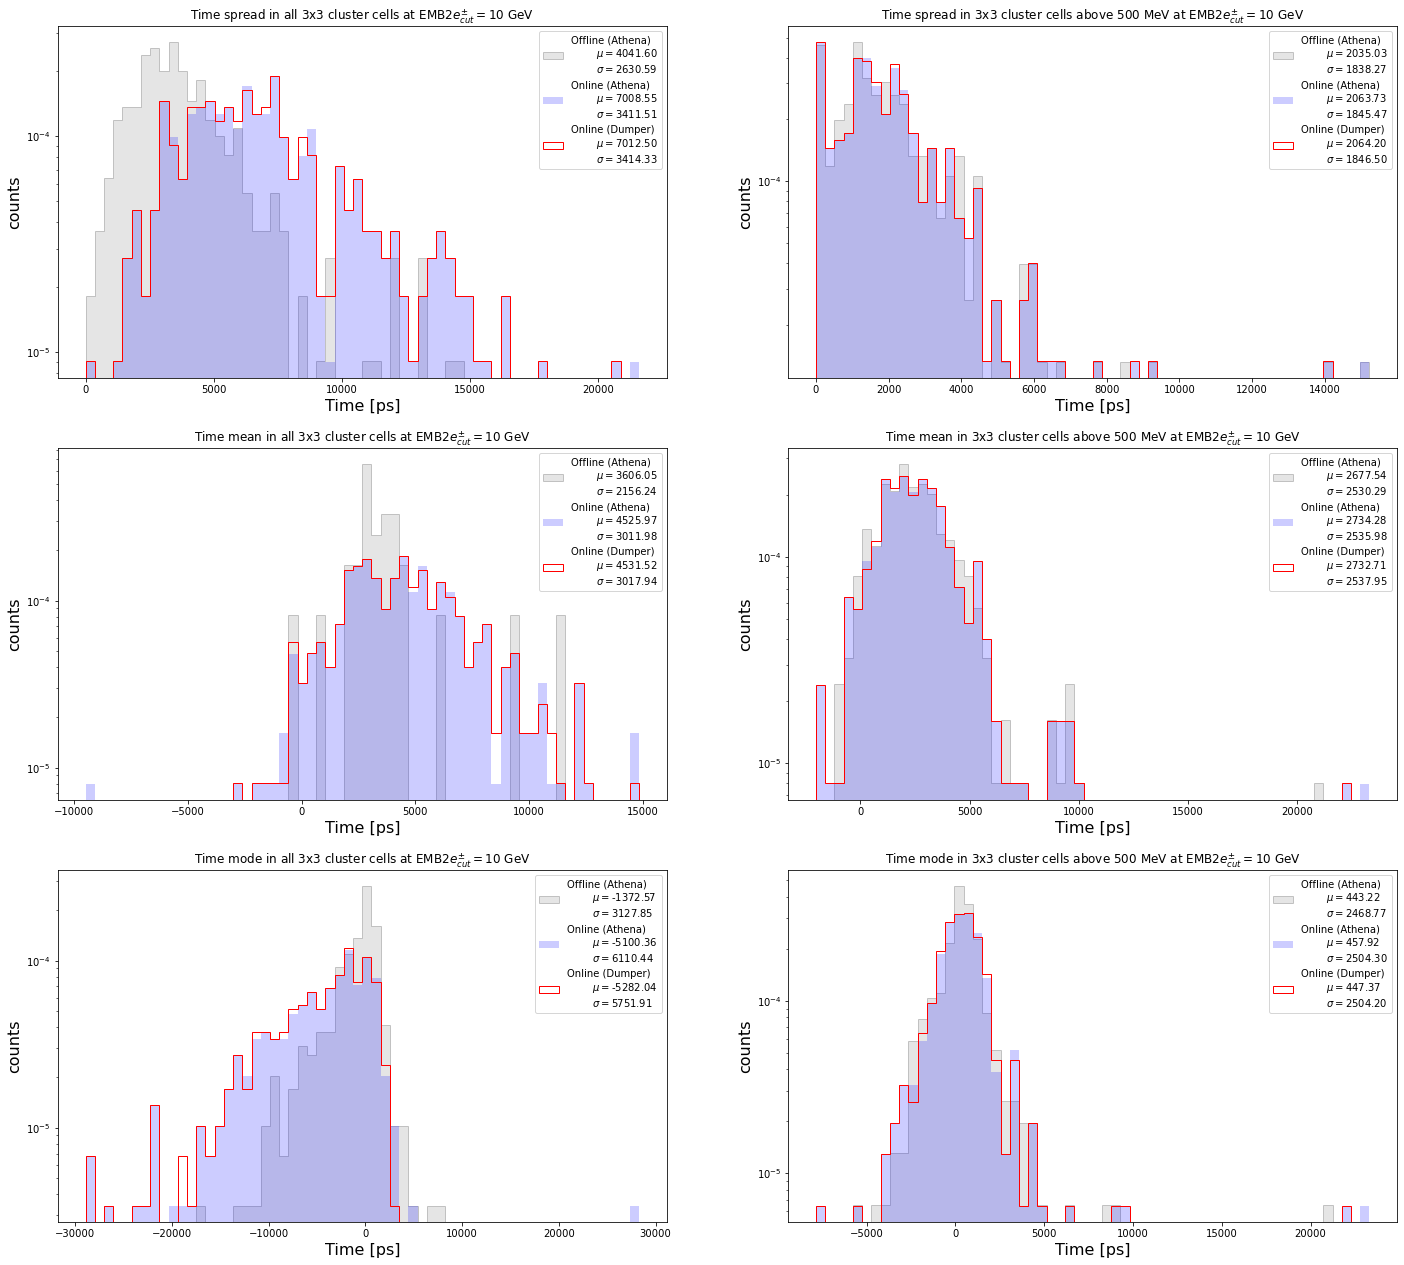

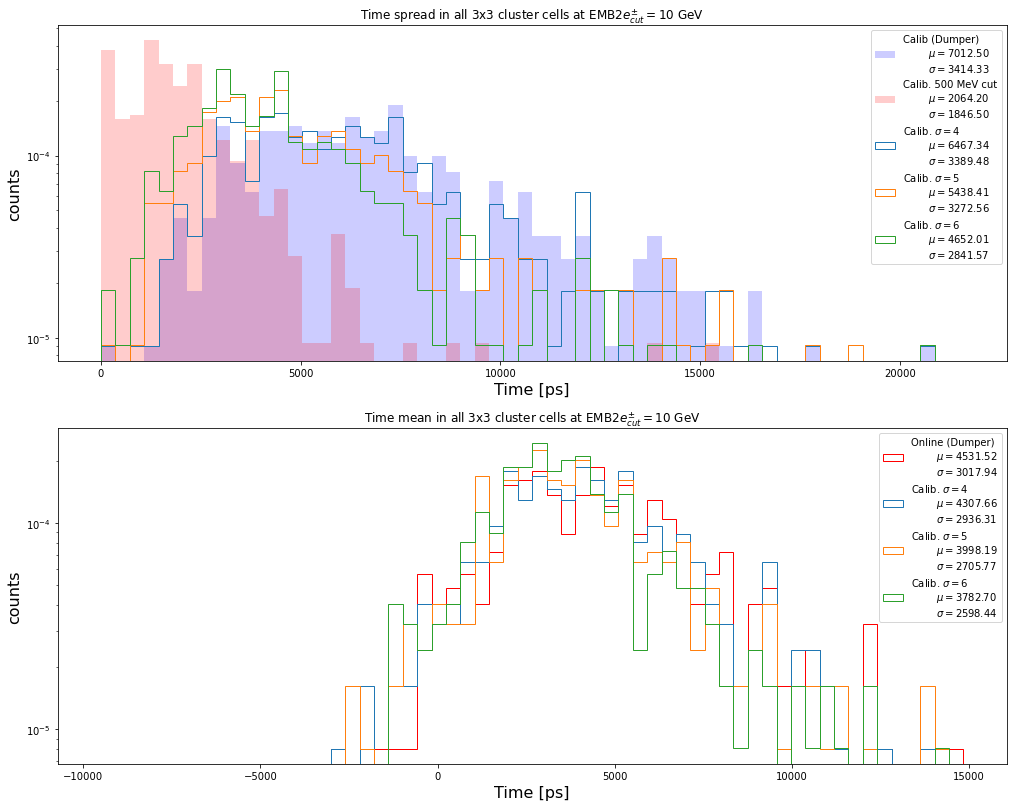

In [ ]:
matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

plot_keys_ene    = ['channelEnergyWindow','EDSPCalibWindow','rawChEnergyWindow']
plot_keys_time   = ['channelTimeWindow','tauDSPWindow','rawChTimeWindow']
plot_keys_id     = ['channelIdWindow','rawChIdWindow']
plot_keys_dspThr = ['channelDSPThrWindow','rawChDSPThrWindow','tauDSPThrDiffWindow']
plot_keys_noise  = ['channelNoiseWindow','channelEffSigmaWindow']

leadingCellIndexes = []
leadingCellTimeOnline = []
leadingCellTimeCalib    = []
leadingCellTimeOffline = []
leadingCellEneOnline = []
leadingCellEneCalib = []
leadingCellEneOffline = []
leadingCellChannelId    = []
leadingCellEta  = []
leadingCellPhi  = []
leadingCellChannelFT    = []
leadingCellElecVertex   = []

## ML Variables by cluster
sigmaValues = [4,5,6]
offlineTimeSpreadByCluster  = {'noCellCut':[], 'cellCut':[]}
offlineTimeMeanByCluster    = {'noCellCut':[], 'cellCut':[]}
offlineTimeModeByCluster    = {'noCellCut':[], 'cellCut':[]}
onlineTimeSpreadByCluster   = {'noCellCut':[], 'cellCut':[]}
onlineTimeMeanByCluster     = {'noCellCut':[], 'cellCut':[]}
onlineTimeModeByCluster     = {'noCellCut':[], 'cellCut':[]}
calibTimeSpreadByCluster    = {'noCellCut':[], 'cellCut':[]}
calibTimeMeanByCluster      = {'noCellCut':[], 'cellCut':[]}
calibTimeModeByCluster      = {'noCellCut':[], 'cellCut':[]}
for key in sigmaValues:
    offlineTimeSpreadByCluster[str(key)+'sigmaCut'] = []
    offlineTimeMeanByCluster[str(key)+'sigmaCut'] = []
    offlineTimeModeByCluster[str(key)+'sigmaCut'] = []
    onlineTimeSpreadByCluster[str(key)+'sigmaCut'] = []
    onlineTimeMeanByCluster[str(key)+'sigmaCut'] = []
    onlineTimeModeByCluster[str(key)+'sigmaCut'] = []
    calibTimeSpreadByCluster[str(key)+'sigmaCut'] = []
    calibTimeMeanByCluster[str(key)+'sigmaCut'] = []
    calibTimeModeByCluster[str(key)+'sigmaCut'] = []

# ML Variables by dataset
allClustersTimeMean     = []
allClusterTimeMode      = []
allClusterTimeSpread    = []

# -------------- Analysis  --------------
for resultFileAlias in resultFileAliases:
    for clusName in clusNames:

        # resultFile = 'calibration/vertex_results_analysis_{}_{}_{}_eCut{}GeV.db'.format(resultFileAlias, clusName,calibType,el_thr)
        # confFile   = 'calibration/vertex_conf_analysis_{}_{}_{}_eCut{}GeV.npz'.format(resultFileAlias, clusName,calibType,el_thr)
        resultFile   = 'calibration/vertex_results_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.db'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)
        confFile     = 'calibration/vertex_conf_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.npz'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)
                
        # for resultFile, confFile in zip(resultFiles, confFiles):
        print(resultFile+'...')

        # results     = np.load(resultFile, allow_pickle=True)
        results     = shelve.open(resultFile, flag='r', protocol=None, writeback=False)
        confDict    = np.load(confFile, allow_pickle=True)
        # el_thr      = confDict['el_thr']
        
        for layer in layers:
            resultsInSampling   = results[layer]

            if layer=='EMB2':
                for idx, clusEne in enumerate(resultsInSampling['channelEnergyWindow']):
                    if len(clusEne)==0:
                        # print("Empty cluster!")
                        continue

                    offTimeClus     = np.array(resultsInSampling['channelTimeWindow'][idx],dtype=float)
                    onTimeClus      = np.array(resultsInSampling['rawChTimeWindow'][idx],dtype=float)
                    calibTimeClus   = np.array(resultsInSampling['tauDSPWindow'][idx],dtype=float)

                    offEneClus      = np.array(resultsInSampling['rawChEnergyWindow'][idx], dtype=float)
                    onEneClus       = np.array(resultsInSampling['EDSPCalibWindow'][idx], dtype=float)
                    calibEneClus    = np.array(resultsInSampling['channelEnergyWindow'][idx], dtype=float)

                    cellNoiseSigma  = np.array(resultsInSampling['channelEffSigmaWindow'][idx], dtype=float)

                    # Turn zeros into nan
                    offTimeClus[offTimeClus == 0] = np.nan
                    onTimeClus[onTimeClus == 0] = np.nan
                    calibTimeClus[calibTimeClus == 0] = np.nan

                    # remove nan from array
                    offTimeClus[~np.isnan(offTimeClus)]
                    onTimeClus[~np.isnan(onTimeClus)]
                    calibTimeClus[~np.isnan(calibTimeClus)]

                    # normal cut (~500 MeV)
                    onlineCellsAboveCutIdx  = np.where( offEneClus > cellEneCut)[0]
                    calibCellsAboveCutIdx   = np.where( onEneClus > cellEneCut)[0]
                    offlineCellsAboveCutIdx = np.where( calibEneClus > cellEneCut)[0]

                    # cut from sigma noise*N
                    for sigma in sigmaValues:
                        onlineCellsAboveSigmaCutIdx     = []
                        calibCellsAboveSigmaCutIdx      = []
                        offlineCellsAboveSigmaCutIdx    = []

                        onlineCellsAboveSigmaCutIdx.append( [idxCell for (idxCell,eneCell) in enumerate(onEneClus) if eneCell/cellNoiseSigma[idxCell] > sigma] )
                        calibCellsAboveSigmaCutIdx.append(  [idxCell for (idxCell,eneCell) in enumerate(calibEneClus) if eneCell/cellNoiseSigma[idxCell] > sigma] )
                        offlineCellsAboveSigmaCutIdx.append([idxCell for (idxCell,eneCell) in enumerate(offEneClus) if eneCell/cellNoiseSigma[idxCell] > sigma] )

                        ## Calculate variables I                 
                        if len(offTimeClus[offlineCellsAboveSigmaCutIdx]) != 0:
                            offlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)].append(np.nanstd(offTimeClus[offlineCellsAboveSigmaCutIdx],ddof=0))
                            offlineTimeMeanByCluster['{}sigmaCut'.format(sigma)].append(np.nanmean(offTimeClus[offlineCellsAboveSigmaCutIdx]))
                            offlineTimeModeByCluster['{}sigmaCut'.format(sigma)].append(scipy.mode(offTimeClus[offlineCellsAboveSigmaCutIdx], nan_policy='omit')[0][0] )
                        if len(calibTimeClus[calibCellsAboveSigmaCutIdx]) != 0:
                            calibTimeSpreadByCluster['{}sigmaCut'.format(sigma)].append(np.nanstd(calibTimeClus[calibCellsAboveSigmaCutIdx],ddof=0))
                            calibTimeMeanByCluster['{}sigmaCut'.format(sigma)].append(np.nanmean(calibTimeClus[calibCellsAboveSigmaCutIdx]))
                            calibTimeModeByCluster['{}sigmaCut'.format(sigma)].append(scipy.mode(calibTimeClus[calibCellsAboveSigmaCutIdx], nan_policy='omit')[0][0] )
                        if len(onTimeClus[onlineCellsAboveSigmaCutIdx]) != 0:
                            onlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)].append(np.nanstd(calibTimeClus[onlineCellsAboveSigmaCutIdx],ddof=0))
                            onlineTimeMeanByCluster['{}sigmaCut'.format(sigma)].append(np.nanmean(calibTimeClus[onlineCellsAboveSigmaCutIdx]))
                            onlineTimeModeByCluster['{}sigmaCut'.format(sigma)].append(scipy.mode(calibTimeClus[onlineCellsAboveSigmaCutIdx], nan_policy='omit')[0][0] )

                    
                    ## Calculate variables II
                    offlineTimeSpreadByCluster['noCellCut'].append(np.nanstd(offTimeClus,ddof=0))
                    offlineTimeMeanByCluster['noCellCut'].append(np.mean(offTimeClus))
                    offlineTimeModeByCluster['noCellCut'].append(scipy.mode(offTimeClus, nan_policy='omit')[0][0] )
                    if len(offTimeClus[offlineCellsAboveCutIdx]) != 0:
                        offlineTimeSpreadByCluster['cellCut'].append(np.nanstd(offTimeClus[offlineCellsAboveCutIdx],ddof=0))
                        offlineTimeMeanByCluster['cellCut'].append(np.nanmean(offTimeClus[offlineCellsAboveCutIdx]))
                        offlineTimeModeByCluster['cellCut'].append(scipy.mode(offTimeClus[offlineCellsAboveCutIdx], nan_policy='omit')[0][0] )
                
                    onlineTimeSpreadByCluster['noCellCut'].append(np.nanstd(onTimeClus,ddof=0))
                    onlineTimeMeanByCluster['noCellCut'].append(np.nanmean(onTimeClus))
                    onlineTimeModeByCluster['noCellCut'].append(scipy.mode(onTimeClus, nan_policy='omit')[0][0] )
                    if len(onTimeClus[onlineCellsAboveCutIdx]) != 0:
                        onlineTimeSpreadByCluster['cellCut'].append(np.nanstd(onTimeClus[onlineCellsAboveCutIdx],ddof=0))
                        onlineTimeMeanByCluster['cellCut'].append(np.nanmean(onTimeClus[onlineCellsAboveCutIdx]))
                        onlineTimeModeByCluster['cellCut'].append(scipy.mode(onTimeClus[onlineCellsAboveCutIdx], nan_policy='omit')[0][0] )
                
                    calibTimeSpreadByCluster['noCellCut'].append(np.nanstd(calibTimeClus,ddof=0))
                    calibTimeMeanByCluster['noCellCut'].append(np.nanmean(calibTimeClus))
                    calibTimeModeByCluster['noCellCut'].append(scipy.mode(calibTimeClus, nan_policy='omit')[0][0] )
                    if len(calibTimeClus[calibCellsAboveCutIdx]) != 0:
                        calibTimeSpreadByCluster['cellCut'].append(np.nanstd(calibTimeClus[calibCellsAboveCutIdx],ddof=0))
                        calibTimeMeanByCluster['cellCut'].append(np.nanmean(calibTimeClus[calibCellsAboveCutIdx]))
                        calibTimeModeByCluster['cellCut'].append(scipy.mode(calibTimeClus[calibCellsAboveCutIdx], nan_policy='omit')[0][0] )

        results.close()

# --------------- Plots ---------------------
myFig = plt.figure(figsize=(24,22))
labelFontSize   = 16
xbins           = 60

#-TimeSpread
plt.subplot(3,2,1)
offLabel    = r'$\mu = ${:.2f}'.format(np.nanmean([x*1000 for x in offlineTimeSpreadByCluster['noCellCut']]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd([x*1000 for x in offlineTimeSpreadByCluster['noCellCut']]))
onLabel     = r'$\mu = ${:.2f}'.format(np.nanmean(onlineTimeSpreadByCluster['noCellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(onlineTimeSpreadByCluster['noCellCut']))
calibLabel  = r'$\mu = ${:.2f}'.format(np.nanmean(calibTimeSpreadByCluster['noCellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(calibTimeSpreadByCluster['noCellCut']))
theBins     = np.histogram(onlineTimeSpreadByCluster['noCellCut'],xbins)[1]
plt.hist([x*1000 for x in offlineTimeSpreadByCluster['noCellCut']],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)\n\t'+offLabel, density=True)
plt.hist(onlineTimeSpreadByCluster['noCellCut'],bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)\n\t'+onLabel, density=True)
plt.hist(calibTimeSpreadByCluster['noCellCut'],bins=theBins,histtype='step', color='red',label='Online (Dumper)\n\t'+calibLabel, density=True)
# for sigma in [1,2,3,4,5]:
#     # offLabel    = r'$\mu = ${:.2f}'.format(np.nanmean([x*1000 for x in offlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)]]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd([x*1000 for x in offlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)]]))
#     # onLabel     = r'$\mu = ${:.2f}'.format(np.nanmean(onlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(onlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)]))
#     calibLabel  = r'$\mu = ${:.2f}'.format(np.nanmean(calibTimeSpreadByCluster['{}sigmaCut'.format(sigma)]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(calibTimeSpreadByCluster['{}sigmaCut'.format(sigma)]))
#     plt.hist(calibTimeSpreadByCluster['{}sigmaCut'.format(sigma)],bins=theBins,histtype='step',label=r'Calib. $\sigma = ${}\n\t'.format(sigma)+calibLabel, density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Time spread in all {}x{} cluster cells at EMB2'.format(nCellsWinEta,nCellsWinPhi)+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.xlabel('Time [ps]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.subplot(3,2,2)
offLabel    = r'$\mu = ${:.2f}'.format(np.nanmean([x*1000 for x in offlineTimeSpreadByCluster['cellCut']]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd([x*1000 for x in offlineTimeSpreadByCluster['cellCut']]))
onLabel     = r'$\mu = ${:.2f}'.format(np.nanmean(onlineTimeSpreadByCluster['cellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(onlineTimeSpreadByCluster['cellCut']))
calibLabel  = r'$\mu = ${:.2f}'.format(np.nanmean(calibTimeSpreadByCluster['cellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(calibTimeSpreadByCluster['cellCut']))
theBins     = np.histogram(onlineTimeSpreadByCluster['cellCut'],xbins)[1]
plt.hist([x*1000 for x in offlineTimeSpreadByCluster['cellCut']],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)\n\t'+offLabel, density=True)
plt.hist(onlineTimeSpreadByCluster['cellCut'],bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)\n\t'+onLabel, density=True)
plt.hist(calibTimeSpreadByCluster['cellCut'],bins=theBins,histtype='step', color='red',label='Online (Dumper)\n\t'+calibLabel, density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Time spread in {}x{} cluster cells above {} MeV at EMB2'.format(nCellsWinEta,nCellsWinPhi,cellEneCut)+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.xlabel('Time [ps]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

#-TimeMean
plt.subplot(3,2,3)
offLabel    = r'$\mu = ${:.2f}'.format(np.nanmean([x*1000 for x in offlineTimeMeanByCluster['noCellCut']]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd([x*1000 for x in offlineTimeMeanByCluster['noCellCut']]))
onLabel     = r'$\mu = ${:.2f}'.format(np.nanmean(onlineTimeMeanByCluster['noCellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(onlineTimeMeanByCluster['noCellCut']))
calibLabel  = r'$\mu = ${:.2f}'.format(np.nanmean(calibTimeMeanByCluster['noCellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(calibTimeMeanByCluster['noCellCut']))
theBins     = np.histogram(onlineTimeMeanByCluster['noCellCut'],xbins)[1]
plt.hist([x*1000 for x in offlineTimeMeanByCluster['noCellCut']],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)\n\t'+offLabel, density=True)
plt.hist(onlineTimeMeanByCluster['noCellCut'],bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)\n\t'+onLabel, density=True)
plt.hist(calibTimeMeanByCluster['noCellCut'],bins=theBins,histtype='step', color='red',label='Online (Dumper)\n\t'+calibLabel, density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Time mean in all {}x{} cluster cells at EMB2'.format(nCellsWinEta,nCellsWinPhi)+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.xlabel('Time [ps]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.subplot(3,2,4)
offLabel    = r'$\mu = ${:.2f}'.format(np.nanmean([x*1000 for x in offlineTimeMeanByCluster['cellCut']]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd([x*1000 for x in offlineTimeMeanByCluster['cellCut']]))
onLabel     = r'$\mu = ${:.2f}'.format(np.nanmean(onlineTimeMeanByCluster['cellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(onlineTimeMeanByCluster['cellCut']))
calibLabel  = r'$\mu = ${:.2f}'.format(np.nanmean(calibTimeMeanByCluster['cellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(calibTimeMeanByCluster['cellCut']))
theBins     = np.histogram(onlineTimeMeanByCluster['cellCut'],xbins)[1]
plt.hist([x*1000 for x in offlineTimeMeanByCluster['cellCut']],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)\n\t'+offLabel, density=True)
plt.hist(onlineTimeMeanByCluster['cellCut'],bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)\n\t'+onLabel, density=True)
plt.hist(calibTimeMeanByCluster['cellCut'],bins=theBins,histtype='step', color='red',label='Online (Dumper)\n\t'+calibLabel, density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Time mean in {}x{} cluster cells above {} MeV at EMB2'.format(nCellsWinEta,nCellsWinPhi,cellEneCut)+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.xlabel('Time [ps]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

#-TimeMode
plt.subplot(3,2,5)
offLabel    = r'$\mu = ${:.2f}'.format(np.nanmean([x*1000 for x in offlineTimeModeByCluster['noCellCut']]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd([x*1000 for x in offlineTimeModeByCluster['noCellCut']]))
onLabel     = r'$\mu = ${:.2f}'.format(np.nanmean(onlineTimeModeByCluster['noCellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(onlineTimeModeByCluster['noCellCut']))
calibLabel  = r'$\mu = ${:.2f}'.format(np.nanmean(calibTimeModeByCluster['noCellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(calibTimeModeByCluster['noCellCut']))
theBins     = np.histogram(onlineTimeModeByCluster['noCellCut'],xbins)[1]
plt.hist([x*1000 for x in offlineTimeModeByCluster['noCellCut']],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)\n\t'+offLabel, density=True)
plt.hist(onlineTimeModeByCluster['noCellCut'],bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)\n\t'+onLabel, density=True)
plt.hist(calibTimeModeByCluster['noCellCut'],bins=theBins,histtype='step', color='red',label='Online (Dumper)\n\t'+calibLabel, density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Time mode in all {}x{} cluster cells at EMB2'.format(nCellsWinEta,nCellsWinPhi)+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.xlabel('Time [ps]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.subplot(3,2,6)
offLabel    = r'$\mu = ${:.2f}'.format(np.nanmean([x*1000 for x in offlineTimeModeByCluster['cellCut']]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd([x*1000 for x in offlineTimeModeByCluster['cellCut']]))
onLabel     = r'$\mu = ${:.2f}'.format(np.nanmean(onlineTimeModeByCluster['cellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(onlineTimeModeByCluster['cellCut']))
calibLabel  = r'$\mu = ${:.2f}'.format(np.nanmean(calibTimeModeByCluster['cellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(calibTimeModeByCluster['cellCut']))
theBins     = np.histogram(onlineTimeModeByCluster['cellCut'],xbins)[1]
plt.hist([x*1000 for x in offlineTimeModeByCluster['cellCut']],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)\n\t'+offLabel, density=True)
plt.hist(onlineTimeModeByCluster['cellCut'],bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)\n\t'+onLabel, density=True)
plt.hist(calibTimeModeByCluster['cellCut'],bins=theBins,histtype='step', color='red',label='Online (Dumper)\n\t'+calibLabel, density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Time mode in {}x{} cluster cells above {} MeV at EMB2'.format(nCellsWinEta,nCellsWinPhi,cellEneCut)+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.xlabel('Time [ps]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()
# plt.subplot(2,2,4)
# plt.hist2d(np.asarray(leadingCellEta).reshape(len(leadingCellEta)), np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex)),bins=[xbins,xbins])
# plt.title('Leading EMB2 Cells from Electron Cluster.'+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
# plt.ylabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
# plt.xlabel('Leading Cell '+r'$\eta$',fontsize=labelFontSize)
# plt.grid()
filename = 'calibration/calibPlots/'+plotFolderAlias+'/4-{}_MLvariables_{}_{}mevCellCut.{}'.format(resultFileAlias, clusName, cellEneCut, fileType)
plt.savefig(filename, facecolor=bFacecolor,  transparent=bTransparentBGOutputFile)
plt.show()
plt.close(myFig)

###--------------------

plt.figure(figsize=(17,21))

#-TimeSpread
plt.subplot(3,1,1)
offLabel         = r'$\mu = ${:.2f}'.format(np.nanmean([x*1000 for x in offlineTimeSpreadByCluster['noCellCut']]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd([x*1000 for x in offlineTimeSpreadByCluster['noCellCut']]))
onLabel          = r'$\mu = ${:.2f}'.format(np.nanmean(onlineTimeSpreadByCluster['noCellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(onlineTimeSpreadByCluster['noCellCut']))
calibLabel       = r'$\mu = ${:.2f}'.format(np.nanmean(calibTimeSpreadByCluster['cellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(calibTimeSpreadByCluster['cellCut']))
calibLabelNoCut  = r'$\mu = ${:.2f}'.format(np.nanmean(calibTimeSpreadByCluster['noCellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(calibTimeSpreadByCluster['noCellCut']))
theBins     = np.histogram(onlineTimeSpreadByCluster['noCellCut'],xbins)[1]
# plt.hist([x*1000 for x in offlineTimeSpreadByCluster['noCellCut']],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)\n\t'+offLabel, density=True)
# plt.hist(onlineTimeSpreadByCluster['noCellCut'],bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)\n\t'+onLabel, density=True)
plt.hist(calibTimeSpreadByCluster['noCellCut'],bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Calib (Dumper)\n\t'+calibLabelNoCut, density=True)
plt.hist(calibTimeSpreadByCluster['cellCut'],bins=theBins,histtype='stepfilled', alpha=0.2, color='red',label='Calib. 500 MeV cut\n\t'+calibLabel, density=True)
for sigma in sigmaValues:
    # offLabel    = r'$\mu = ${:.2f}'.format(np.nanmean([x*1000 for x in offlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)]]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd([x*1000 for x in offlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)]]))
    # onLabel     = r'$\mu = ${:.2f}'.format(np.nanmean(onlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(onlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)]))
    calibLabel  = r'$\mu = ${:.2f}'.format(np.nanmean(calibTimeSpreadByCluster['{}sigmaCut'.format(sigma)]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(calibTimeSpreadByCluster['{}sigmaCut'.format(sigma)]))
    plt.hist(calibTimeSpreadByCluster['{}sigmaCut'.format(sigma)],bins=theBins,histtype='step',label=r'Calib. $\sigma = ${}'.format(sigma)+'\n\t'+calibLabel, density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Time spread in all {}x{} cluster cells at EMB2'.format(nCellsWinEta,nCellsWinPhi)+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.xlabel('Time [ps]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

#-TimeMean
plt.subplot(3,1,2)
# offLabel    = r'$\mu = ${:.2f}'.format(np.nanmean([x*1000 for x in offlineTimeMeanByCluster['noCellCut']]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd([x*1000 for x in offlineTimeMeanByCluster['noCellCut']]))
# onLabel     = r'$\mu = ${:.2f}'.format(np.nanmean(onlineTimeMeanByCluster['noCellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(onlineTimeMeanByCluster['noCellCut']))
calibLabel  = r'$\mu = ${:.2f}'.format(np.nanmean(calibTimeMeanByCluster['noCellCut']))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(calibTimeMeanByCluster['noCellCut']))
theBins     = np.histogram(onlineTimeMeanByCluster['noCellCut'],xbins)[1]
# plt.hist([x*1000 for x in offlineTimeMeanByCluster['noCellCut']],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)\n\t'+offLabel, density=True)
# plt.hist(onlineTimeMeanByCluster['noCellCut'],bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)\n\t'+onLabel, density=True)
plt.hist(calibTimeMeanByCluster['noCellCut'],bins=theBins,histtype='step', color='red',label='Online (Dumper)\n\t'+calibLabel, density=True)
for sigma in sigmaValues:
    # offLabel    = r'$\mu = ${:.2f}'.format(np.nanmean([x*1000 for x in offlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)]]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd([x*1000 for x in offlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)]]))
    # onLabel     = r'$\mu = ${:.2f}'.format(np.nanmean(onlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(onlineTimeSpreadByCluster['{}sigmaCut'.format(sigma)]))
    calibLabel  = r'$\mu = ${:.2f}'.format(np.nanmean(calibTimeMeanByCluster['{}sigmaCut'.format(sigma)]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.nanstd(calibTimeMeanByCluster['{}sigmaCut'.format(sigma)]))
    plt.hist(calibTimeMeanByCluster['{}sigmaCut'.format(sigma)],bins=theBins,histtype='step',label=r'Calib. $\sigma = ${}'.format(sigma)+'\n\t'+calibLabel, density=True)
plt.title('Time mean in all {}x{} cluster cells at EMB2'.format(nCellsWinEta,nCellsWinPhi)+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.xlabel('Time [ps]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.show()


## 2.5) Time Resolution

In [ ]:
# plot_keys_ene    = ['channelEnergyWindow','EDSPCalibWindow','rawChEnergyWindow']
# plot_keys_time   = ['channelTimeWindow','tauDSPWindow','rawChTimeWindow']
# plot_keys_id     = ['channelIdWindow','rawChIdWindow']
# plot_keys_dspThr = ['channelDSPThrWindow','rawChDSPThrWindow','tauDSPThrDiffWindow']
# plot_keys_noise  = ['channelNoiseWindow','channelEffSigmaWindow']

# # labelFontSize   = 14
# for resultFileAlias in resultFileAliases:

#     for clusName in clusNames:

#         # resultFile = 'calibration/vertex_results_analysis_{}_{}_{}_eCut{}GeV.db'.format(resultFileAlias, clusName,calibType,el_thr)
#         # confFile   = 'calibration/vertex_conf_analysis_{}_{}_{}_eCut{}GeV.npz'.format(resultFileAlias, clusName,calibType,el_thr)
#         resultFile   = 'calibration/vertex_results_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.db'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)
#         confFile     = 'calibration/vertex_conf_analysis_win{}-{}_{}_{}_{}_eCut{}GeV.npz'.format(nCellsWinEta,nCellsWinPhi,resultFileAlias, clusName,calibType,el_thr)

#         # for resultFile, confFile in zip(resultFiles, confFiles):
#         print(resultFile+'...')

#         results     = shelve.open(resultFile, flag='r', protocol=None, writeback=False)
#         confDict    = np.load(confFile, allow_pickle=True)['conf'].tolist()

#         # el_thr = confDict['el_thr']
#         nCellsChEta = confDict['nCellsChEta']
#         nCellsChPhi = confDict['nCellsChPhi']
#         nCellsRawChEta = confDict['nCellsRawChEta']
#         nCellsRawChPhi = confDict['nCellsRawChPhi']

#         layer = 'EMB2'
#         resultsInSampling   = results[layer]
#         print(layer)

#         Amp                 = list(np.concatenate(resultsInSampling['AWindow']).flat)
#         gain                = list(np.concatenate(resultsInSampling['channelGainWindow']).flat)
#         pedDB               = list(np.concatenate(resultsInSampling['channelPedWindow']).flat)
#         pedDict             = list(np.concatenate(resultsInSampling['channelPedDictWindow']).flat)
#         adc2Mev0            = list(np.concatenate(resultsInSampling['channelRamps0Window']).flat)
#         adc2Mev1            = list(np.concatenate(resultsInSampling['channelRamps1Window']).flat)
#         LArProv_online      = list(np.concatenate(resultsInSampling['rawChProvWindow']).flat)
#         chid_calib          = list(np.concatenate(resultsInSampling[plot_keys_id[0]]).flat)
#         sigmaEffPerCell     = list(np.concatenate(resultsInSampling['channelEffSigmaWindow']).flat)
#         channelSlot         = list(np.concatenate(resultsInSampling['channelSlot']).flat)
#         channelFeedthrough  = list(np.concatenate(resultsInSampling['channelFeedthrough']).flat)
#         channelNumber       = list(np.concatenate(resultsInSampling['channelNumber']).flat)
#         channelPos_neg      = list(np.concatenate(resultsInSampling['channelPos_neg']).flat)
        
#         ene_offline         = list(np.concatenate(resultsInSampling[plot_keys_ene[0]]).flat)
#         ene_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_ene[1]]).flat)
#         ene_online          = list(np.concatenate(resultsInSampling[plot_keys_ene[2]]).flat)
#         # ene_calibOffl       = list(np.concatenate(resultsInSampling['eneOfflineWindow']).flat)
#         tau_offline         = list(np.concatenate(resultsInSampling[plot_keys_time[0]]).flat)
#         tau_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat) ] # ps to ns
#         tau_online          = list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat) ] # ps to ns
#         # tau_calibOffl       = list(np.concatenate(resultsInSampling['tauOfflineWindow']).flat)
#         dspThr_calib        = list(np.concatenate(resultsInSampling[plot_keys_dspThr[0]]).flat)
#         dspThr_online       = list(np.concatenate(resultsInSampling[plot_keys_dspThr[1]]).flat)
#         dspThr_calibDiff    = list(np.concatenate(resultsInSampling[plot_keys_dspThr[2]]).flat)
        
#         eta_calib           = list(np.concatenate(resultsInSampling['channelEtaWindow']).flat)
#         phi_calib           = list(np.concatenate(resultsInSampling['channelPhiWindow']).flat)
#         eta_online          = list(np.concatenate(resultsInSampling['rawChEtaWindow']).flat)
#         phi_online          = list(np.concatenate(resultsInSampling['rawChPhiWindow']).flat)
#         LArProv_online      = list(np.concatenate(resultsInSampling['rawChProvWindow']).flat)

#         diffEneOnCalibDSP   = [onl - calib for (onl,calib) in zip(ene_online, ene_calibDSP)]
#         diffEneOffCalibDSP  = [off - calib for (off,calib) in zip(ene_offline, ene_calibDSP)]
#         diffEneOffOnline    = [off - onl for (off,onl) in zip(ene_offline, ene_online)]
#         # diffEneOffCalibOff  = [off - calibOff for (off, calibOff) in zip(ene_offline, ene_calibOffl)]
#         diffTauOnCalibDSP   = [onl - calib for (onl,calib) in zip(tau_online, tau_calibDSP)]
#         diffTauOffCalibDSP  = [off - calib for (off,calib) in zip(tau_offline, tau_calibDSP)]
#         diffTauOffOnline    = [off - onl for (off,onl) in zip(tau_offline, tau_online)]

#         cellEneSigmaDistrib = [np.abs(element)/sigmaEffPerCell[idx] for idx,element in enumerate(ene_online)]

#         diffPedDbScript     = [db - scr for (db,scr) in zip(pedDB, pedDict)]

#         passCellEneThr      = [idx for idx, element in enumerate(ene_online) if element > cellEneCut]
#         passCellSigmaEneThr = [idx for idx ,element in enumerate(ene_online) if element/sigmaEffPerCell[idx] > sigmaEneCut] 
#         zeroOnlineTau       = [idx for idx, element in enumerate(tau_online) if element == 0]# np.where(np.array(dspThr_calibDiff) <=0 )[0].tolist()
#         noPassInThr         = [idx for idx, element in enumerate(dspThr_calibDiff) if element <= 0]
#         passInThr           = [idx for idx, element in enumerate(dspThr_calibDiff) if element > 0]
#         tauCalibErrNonZero  = [idx for idx, element in enumerate(np.array(diffTauOnCalibDSP)[zeroOnlineTau]) if element != 0]
            

# 3.0) ML Studies

### - Autoencoder

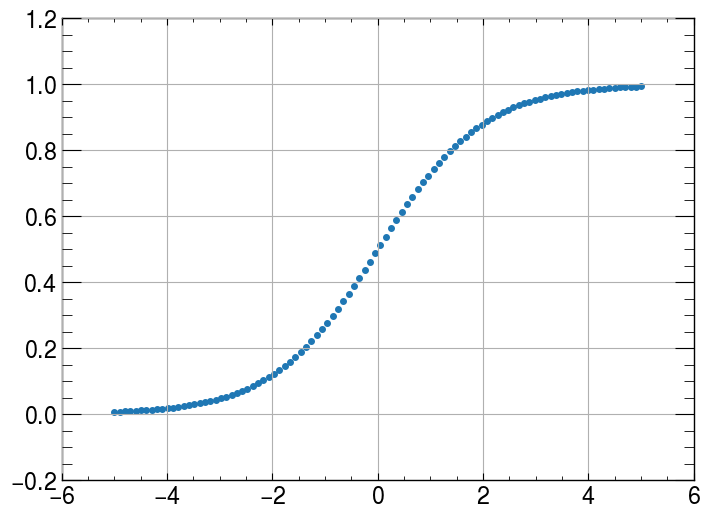

In [2]:
x = torch.linspace(-5.0, 5.0, 100)

y = torch.special.expit(x)
y1 = torch.sigmoid(x)

plt.plot(x,y,'.')
# plt.plot(x,y1,'x')
plt.grid()
plt.show()

In [16]:
#
# Autoencoder with torch
#

import torch
import torch.nn as nn

class TauLossWeightedByEnergy(nn.Module):
    def __init__(self):
        super(TauLossWeightedByEnergy, self).__init__()
    
    def forward(self, tau_x, tau_y, ene_x):
        ene_gev     = ene_x/1000
        sq_error    = torch.sigmoid(ene_gev)*(tau_x - tau_y)**2
        w_ene_mse   = torch.mean(sq_error)

        return w_ene_mse

def getAutoencoderNeuronsList(inputSize, nNeuronsInput, nLayers):
    neuronsList = [inputSize, nNeuronsInput]

    if 2**nLayers > nNeuronsInput:
        raise ValueError("Using binary division for neurons in each layer, the number of layers (2**layers) is bigger than initial number of neurons.\nUse bigger nNeuronsInput or smaller nLayers!")

    for binNeuPow in range(1, nLayers+1):
        neuronsList.append(int(nNeuronsInput/2**binNeuPow))
    # print(neuronsList)
    #       Encoder,    Decoder
    return neuronsList, neuronsList[::-1]


class Autoencoder_Loop(torch.nn.Module):
    # https://medium.com/analytics-vidhya/creating-an-autoencoder-with-pytorch-a2b7e3851c2c
    def __init__(self, learningRate=1e-3, encoderList=[10,6,2], decoderList=[2,6,10], bottleNeck=5, actFuncHidden=nn.ReLU(), inScaler=1, outScaler=1):
        super(Autoencoder_Loop, self).__init__() 
        # self.batchSize      = batchSize
        self.learningRate   = learningRate
        self.inScaler       = inScaler
        self.outScaler      = outScaler
        self.bottleNeckSize = bottleNeck


        # list of modules size test:
        # if len(actFuncList) >= len(encoderList):
        #     raise Warning("size of actFuncList >= encoder layers list.")
        # if len(actFuncHidden) == 0:
        #     raise ValueError("len(actFuncList) == 0 !")

        encModuleList = nn.ModuleList()
        for l in range(len(encoderList)-1):
            encModuleList.append(nn.Linear(encoderList[l], encoderList[l+1]))
            # if l != (len(encoderList)-2):
            encModuleList.append(actFuncHidden)
            # else:
            #     self.encoder.append(nn.Linear())
        self.encoder = nn.Sequential(*encModuleList)

        # bottleNeck
        self.bottleNeck = torch.nn.Sequential(
            torch.nn.Linear(encoderList[-1], self.bottleNeckSize),
            torch.nn.ReLU(False),
        )

        # decoder
        decModuleList = nn.ModuleList()
        for l in range(len(decoderList)-1):
            if l==0:
                decModuleList.append(nn.Linear(self.bottleNeckSize, decoderList[l+1]))
            else:
                decModuleList.append(nn.Linear(decoderList[l], decoderList[l+1]))
            # if l != (len(decoderList)-2):
            decModuleList.append(actFuncHidden)
            # else:
            #     self.decoder.append(nn.Linear())
        self.decoder = nn.Sequential(*decModuleList)
        
        #
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learningRate, weight_decay=1e-5)
        
        self.criterion = nn.MSELoss()
   

    def forward(self, inData):
        x = inData*self.inScaler
        encoded  = self.encoder(x)
        coded    = self.bottleNeck(encoded)
        decoded  = self.decoder(coded)
        output      = decoded*self.outScaler
        return output


class Autoencoder(torch.nn.Module):
    # https://medium.com/analytics-vidhya/creating-an-autoencoder-with-pytorch-a2b7e3851c2c
    # def __init__(self, epochs=100, batchSize=128, learningRate=1e-3, nCellsEta=3, nCellsPhi=3, neu1=10):
    def __init__(self, learningRate=1e-3, nCellsEta=3, nCellsPhi=3, neu1=10):
        super(Autoencoder, self).__init__() 
        # self.epochs         = epochs
        # self.batchSize      = batchSize
        self.learningRate   = learningRate
        self.nCellsEta      = nCellsEta
        self.nCellsPhi      = nCellsPhi
        self.nSamples       = 4
        self.neu1           = neu1

        # encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.nSamples * self.nCellsEta * self.nCellsPhi, self.neu1),
            torch.nn.ReLU(True),
            torch.nn.Linear(self.neu1, int(self.neu1/2)),
            torch.nn.ReLU(True)
        )

        # decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(int(self.neu1/2), self.neu1 ),
            torch.nn.ReLU(True),
            torch.nn.Linear(self.neu1, self.nSamples * self.nCellsEta * self.nCellsPhi),
            torch.nn.ReLU(True)
        )
        
        #
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learningRate, weight_decay=1e-5)
        self.criterion = nn.MSELoss()


    def forward(self, x):
        encoded  = self.encoder(x)
        decoded  = self.decoder(encoded)
        return decoded

    # def trainModel(self):

def checkpoint(model, filename, epoch, val_loss):
    torch.save({
        'optimizer'     : model.optimizer.state_dict(),
        'model'         : model.state_dict(),
        'bestEpoch'     : epoch,
        'bestValLoss'   : val_loss,
    }, filename)

def resumeModel(model, filename):
    theCheckpoint   = torch.load(filename)
    model.load_state_dict(theCheckpoint['model'])
    model.optimizer.load_state_dict(theCheckpoint['optimizer'])

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.bestEpoch = -1

    def early_stop(self, validation_loss, epoch, model, bestModelPath='bestModel.pth'):

        # if validation loss is smaller than min val loss, reset.
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss    = validation_loss
            self.counter                = 0
            self.bestEpoch              = epoch
            checkpoint(model, bestModelPath, epoch, validation_loss)

        # else if, increase the patience counter.
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter    += 1
            if self.counter >= self.patience:
                return True
        return False
    


In [9]:
model.optimizer.state_dict()

{'state': {0: {'step': tensor(1935.),
   'exp_avg': tensor([[ 1.2926e-06,  2.2582e-07, -1.0101e-06,  ..., -9.2019e-07,
            -1.4647e-06,  9.5827e-07],
           [ 8.6934e-07, -1.7328e-06,  6.0673e-07,  ..., -1.2771e-07,
            -1.9869e-07, -9.7103e-08],
           [-6.9565e-08, -4.5507e-07, -8.5485e-08,  ...,  3.5326e-07,
            -7.4828e-08, -1.2194e-07],
           ...,
           [-1.5898e-07, -1.2533e-07, -1.1967e-07,  ..., -1.1595e-07,
            -1.1825e-07, -1.1648e-07],
           [-1.4230e-07, -1.9998e-08, -7.3924e-08,  ..., -2.1294e-07,
            -2.6795e-07, -1.4225e-07],
           [-1.8927e-07, -1.8582e-07, -1.8432e-07,  ..., -1.8706e-07,
            -1.8888e-07, -1.9893e-07]]),
   'exp_avg_sq': tensor([[2.1772e+03, 2.2660e+03, 2.3487e+03,  ..., 2.2268e+03, 2.3098e+03,
            2.2930e+03],
           [3.2527e+02, 3.4944e+02, 3.7113e+02,  ..., 3.4342e+02, 3.5292e+02,
            3.4777e+02],
           [2.4091e+00, 2.5707e+00, 2.7236e+00,  ..., 2.540

### - Load TTree

In [43]:
#---------------------------------------------
#----------   Read the ROOT trees   ----------
#---------------------------------------------
clusName            = 'topocluster'#,'7x11' #
# datasetPath         ='/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_TagAndProbe_v01_XYZ.root.tgz/*XYZ.root'
datasetPath       = '/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_v01_XYZ.root.tgz/*XYZ.root'

#---------------------------------------------

fileNames       = glob(datasetPath)

sTree   = ROOT.TChain("dumpedData",'')
sLBTree = ROOT.TChain("lumiblockData",'')
for file in fileNames:
    fileNameInputLog = "/".join((file+" added to the TChain...").split('/')[-2:])
    # print(fileNameInputLog) 
    sTree.Add(file+"/dumpedData") # main dumped data tree (event by event)
    sLBTree.Add(file+"/lumiblockData") # LB tree (lumiblock per lumiblock)

if clusName == 'topocluster':
    sTree.SetBranchStatus("cluster711_*",0)
    clusKey = "clusters"
if clusName == '7x11':
    sTree.SetBranchStatus("cluster_*",0)
    clusKey = '711_roi'


nEvents         = sTree.GetEntries()
nLumiBlocks     = sLBTree.GetEntries()

print("{} files were added with {} events.".format(len(fileNames),nEvents))



56 files were added with 8573826 events.


### XX Loop ntuple to Train

In [118]:

#---------------------------------------------
#---------- ML Training Parameters -----------
#---------------------------------------------
epochs          = 5
clus_train      = 5 #nClusters to being user to train the model
clus_test       = 10
nNeuronsInput   = 10
nSamples        = 4


#---------------------------------------------
#--------- Data Analysis conditions ----------
#---------------------------------------------
evt_lim             = 10000#nEvents
bPlotClusters       = False
bPedFromDB          = True # Ped from DB (TRUE) or from Script (FALSE)
bFullWindows        = True # use only full windows from clusters
bDoOfflineCalib     = False
el_thr              = 10 # GeV
nCellsWinEta        = 3
nCellsWinPhi        = 3
calibType           = 'dumper' # name of the type of calibration, to differentiate from offline or database (analysis/debug) #'database'#'database' #'typical' # or 
layer               = 'EMB2'
loopModeType        = 'cluster' # or 'event'
#---------------------------------------------
#------------- DSP conditions #------------- < Not getting nice results from quantization. Ignore those *Quant* boolean options. >
#---------------------------------------------
typeThreshold       = 'EneThr'#'fixedValue'#'EneThr'#'NoiseSigma'#
bAbsDSPE1           = False # ~X~ use abs(E) to get E1, and compare to E_thr
bPerfomQuant        = False # ~X~ apply the quantized form of energy and time estimation (like DSP)
applyCteQuant       = False # ~X~ True # apply quantization to the alpha, beta, Pa, Pb. If False, use likeDSP function, but full precision constants.
reorderSamp         = False # ~X~ reorder samples like-dsp

confDict = {
    'el_thr'            : el_thr,
    'sampling'          : layer,
    'nCellsWinEta'      : nCellsWinEta,
    'nCellsWinPhi'      : nCellsWinPhi,
    'datasetPath'       : datasetPath,
    'calibType'         : calibType,
    'bFullWindows'      : bFullWindows,
    'bPedFromDB'        : bPedFromDB,
    'bDoOfflineCalib'   : bDoOfflineCalib,
    'typeThreshold'     : typeThreshold,
    'bAbsDSPE1'         : bAbsDSPE1,
    'bPerfomQuant'      : bPerfomQuant,
    'applyCteQuant'     : applyCteQuant,
    'reorderSamp'       : reorderSamp,
    'fileNames'         : fileNames
}

#---------------------------------------------
#------- Online Calibration constants --------
#---------------------------------------------

ped_dict = {}
if calibType=='database':
    ofc_dict = np.load('calibration/OFC_dict.npz',allow_pickle=True )['OFC'].tolist()
    ped_dict = np.load('calibration/PED_dict.npz',allow_pickle=True )['PED'].tolist()
    mpmc_dict = np.load('calibration/MPMC_dict.npz',allow_pickle=True )['MPMC'].tolist()
    uamev_dict = np.load('calibration/UAMEV_dict.npz',allow_pickle=True )['UAMEV'].tolist()
    ramps_dict = np.load('calibration/RAMPS_dict.npz',allow_pickle=True )['RAMPS'].tolist()

#---------------------------------------------
#------------ ML Model Construct -------------
#---------------------------------------------

model       = Autoencoder(nCellsEta=nCellsWinEta, nCellsPhi=nCellsWinPhi, neu1=nNeuronsInput)

train_logging_dict = {
    'loss'      : [],
    'loss_tau'  : [],
    'sig_tau'   : [],
}


# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#---------------------------------------------
#--------- Event and Data Reading ------------
#---------------------------------------------
print('Calibration type: {}'.format(calibType))
print('Electron pt cut: {} GeV'.format(el_thr))
print('Processing cluster: {}'.format(clusName))

for epoch in range(epochs):
    print('Epoch: {}...'.format(epoch))

    elec_counter    = 0 # counter of electrons in dataset
    clus_counter    = 0
    bMaxClusters    = False

    #---------------------------------------------
    #------ TTree Loop and data extraction -------
    #---------------------------------------------
    meanTimePerEvent = 0.0
    startTime = time()

    for evIndex in range(0, nEvents): ## Loop events into TTree
        if bMaxClusters:
            break
        
        if loopModeType=='event':
            if evIndex > evt_lim:
                break
            if (evIndex%int(evt_lim/5)) == 0:
                print("Event {}/{}...".format(evIndex,evt_lim))
    
        # dataset = getXTDataAsPythonDict(sTree, evIndex, eventReaderSharePath, dataHasBadCh=True, isMC=False)
        dataset = getXTDataAsPythonDictFaster(sTree, evIndex, eventReaderSharePath, dataHasBadCh=True, isMC=False, clusterType=clusName) #<- apply sTree.GetEntry(evIndex) here!

        if dataset==0: # Data has no electrons in this event!
            continue

        for evtn, ev in enumerate(dataset['dataset']): # for each event...
            for elec in ev['electrons'].keys(): # for each electron in this event...
                if bMaxClusters:
                    break
                # print(ev['electrons'][elec]['pt'])
                if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
                    continue
                if np.abs(ev['electrons'][elec]['eta']) > 1.4:
                    continue
                # datasetML = dataset ## Test

                clusloop        = ev['electrons'][elec][clusKey]

                elecPt          = (ev['electrons'][elec]['pt'])
                elecEta         = (ev['electrons'][elec]['eta'])
                elecPhi         = (ev['electrons'][elec]['phi'])
                elecVtxZ        = (ev['electrons'][elec]['vertexZ'])
                elecNClus       = len(ev['electrons'][elec][clusKey])
                
                for clus in clusloop.keys(): # for each cluster associated to that electron...
                    if loopModeType=='cluster':
                        if clus_counter > clus_train:
                            bMaxClusters = True
                            break
                        # if(clus_counter%2):
                        #     print('{}/{} clusters were used to train the model so far...'.format(clus_counter,clus_train))
                    
                    #---------------------------------------------
                    #------- Cluster Dataset Processing ----------
                    #---------------------------------------------
                    dataset_cluster = ev['electrons'][elec][clusKey][clus]

                    datasetML       = unpackCellsFromCluster(dataset_cluster, confDict, ped_dict=ped_dict)
                    
                    if datasetML == 0: # Selected sampling has no cells!
                        # print(' Selected sampling has no cells!')
                        continue
                    if(clus_counter%int(clus_train/5))==0:
                        print('\t{}/{} clusters were used to train the model so far...'.format(clus_counter,clus_train))

                    clus_counter+=1
                    
                    # if loopModeType=='cluster':
                    #     if clus_counter > clus_train:
                    #         bMaxClusters = True
                    #         break

                        # if(clus_counter%2):
                        #     print('{}/{} clusters were used to train the model so far...'.format(clus_counter,clus_train))

                    if bPlotClusters:
                        X = np.array(datasetML['channelEta'])
                        Y = np.array(datasetML['channelPhi'])
                        Z = np.array(datasetML['channelEnergy'])

                        window  = np.array(datasetML['windowIndexesCh'])
                        layer   = np.array(datasetML['layerIndexesCh'])
                        deta    = np.array(datasetML['channelDEta'])
                        dphi    = np.array(datasetML['channelDPhi'])

                        fig, ax = plt.subplots(figsize=(10,10))                
                        plt.scatter(X[layer],Y[layer],c=Z[layer], s=200,marker='s',cmap='summer')
                        plt.scatter(X[window],Y[window],fc='none',ec='red',s=400, marker='o')
                        plt.scatter(X[layer][datasetML['hotcellposition']], Y[layer][datasetML['hotcellposition']], fc='none',ec='black',marker='x')
                        plt.colorbar()
                        plt.show()

                    #---------------------------------------------
                    #-------------- ML Training ------------------
                    #---------------------------------------------
                    
                    # do the software DSP estimation
                    windowOrdered = datasetML['windowIndexesCh'][datasetML['orderedIndexes']].tolist() 

                    Awin, tauDSPWinInput, EDSPWin, _ = DSPCalibSamplesInCluster(
                        datasetML['channelId'][windowOrdered],
                        datasetML['digits'][windowOrdered], 
                        datasetML['channelGain'][windowOrdered], 
                        datasetML['channelLArPed'][windowOrdered], 
                        datasetML['channelOFCa'][windowOrdered], 
                        datasetML['channelOFCb'][windowOrdered], 
                        datasetML['channelRamps0'][windowOrdered], 
                        datasetML['channelRamps1'][windowOrdered], 
                        datasetML['channelDSPThr'][windowOrdered], 
                        datasetML['channelTimeOffset'][windowOrdered], 
                        thresholdMode=confDict['typeThreshold'], 
                        bDoAbsE1=confDict['bAbsDSPE1'])
                        
                    data_input = torch.tensor(np.hstack(datasetML['digits'][windowOrdered]).flatten().astype(float)).type(torch.float)
                    
                    # test data
                    output      = model(data_input)
                    output_conv = output.detach().numpy().reshape(len(datasetML['channelId'][windowOrdered]),nSamples)

                    Awin, tauDSPWinOutput, EDSPWin, _ = DSPCalibSamplesInCluster(
                        datasetML['channelId'][windowOrdered],
                        output_conv, 
                        datasetML['channelGain'][windowOrdered], 
                        datasetML['channelLArPed'][windowOrdered], 
                        datasetML['channelOFCa'][windowOrdered], 
                        datasetML['channelOFCb'][windowOrdered], 
                        datasetML['channelRamps0'][windowOrdered], 
                        datasetML['channelRamps1'][windowOrdered], 
                        datasetML['channelDSPThr'][windowOrdered], 
                        datasetML['channelTimeOffset'][windowOrdered], 
                        thresholdMode=confDict['typeThreshold'], 
                        bDoAbsE1=confDict['bAbsDSPE1'])

                    # loss
                    loss        = model.criterion(output, data_input)
                    loss_tau    = model.criterion(torch.tensor(tauDSPWinOutput).type(torch.float),torch.tensor(tauDSPWinInput).type(torch.float))

                    # backpropagation (optimize weights)
                    model.optimizer.zero_grad()
                    loss.backward()
                    model.optimizer.step()
                    

                    # add here the offline calibration (not working yet)
                    if confDict['bDoOfflineCalib']:
                        offl_pileupOffset   = 0 # getOfflinePileUpOffset(evt_lumiblock, lumiPerBCIDVector, evt_bcid, minBiasAvgs, ofcas, shapes)
                        offl_tauOffset      = 0
                        offl_ene, offl_tau  = offlineCalibInCluster(EDSPWin, tauDSPWin, channelOfflHV, channelEneResc, offl_pileupOffset, offl_tauOffset)

                    
                    #---------------------------------------------
                    #---------------------------------------------
                    #---------------------------------------------

                    if bMaxClusters:
                        break
                elec_counter+=1

                if bMaxClusters:
                    break
            if bMaxClusters:
                break
        if bMaxClusters:
            break
    #
    # End of the current Epoch
    #
    train_logging_dict['loss'].append(loss.detach().numpy())
    train_logging_dict['loss_tau'].append(loss_tau.detach().numpy())

confDict['elec_counter'] = elec_counter
print('Total Electrons: ',elec_counter)
print('Total clusters: ', clus_counter)
# print(confDict)
endTime = time()

print("Total running time: {:.2f} minutes. ({:.2f} us/event)".format((endTime - startTime)/60, (endTime - startTime)/3600*1000000/evt_lim))

#
# Save the results
#
resultsName = 'training_dict_test.npz'
np.savez(resultsName,train_log=train_logging_dict)
print(resultsName,' saved.')

plt.figure(figsize=(10,4))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(train_logging_dict['loss'])
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_logging_dict['loss_tau'])
plt.xlabel('Iterations')
plt.ylabel('Loss')

Calibration type: dumper
Electron pt cut: 10 GeV
Processing cluster: topocluster
Epoch: 0...


	0/5 clusters were used to train the model so far...
	1/5 clusters were used to train the model so far...
	2/5 clusters were used to train the model so far...
	3/5 clusters were used to train the model so far...
	4/5 clusters were used to train the model so far...
	5/5 clusters were used to train the model so far...
Epoch: 1...
	0/5 clusters were used to train the model so far...
	1/5 clusters were used to train the model so far...
	2/5 clusters were used to train the model so far...
	3/5 clusters were used to train the model so far...
	4/5 clusters were used to train the model so far...
	5/5 clusters were used to train the model so far...
Epoch: 2...
	0/5 clusters were used to train the model so far...
	1/5 clusters were used to train the model so far...
	2/5 clusters were used to train the model so far...
	3/5 clusters were used to train the model so far...
	4/5 clusters were used to train the model so far...
	5/5 clusters were used to train the model so far...
Epoch: 3...
	0/5 clust

Text(0, 0.5, 'Loss')

## 3.1) Train Dataset

In [11]:
# !pip install scikit-learn
# import sklearn

experiment_alias        = 'learning the samples of a 3x3 window from topocluster at EMB2 layer. The loss for training is the input-output map'
pathLoss                = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/ml_training/autoencoder/test/'
datasetPath             = '/data/atlas/mhufnage/xtalk/dataset/'

nEpochs                 = 100
patience                = 3
min_delta_loss          = 10

k                       = 2 # number of folds in kFold split
nBatch                  = 32 # xxx not implemented yet!!!!
nIter                   = 1
nClusters               = 1000 # for training, validation and test

nSamples                = 4 # standard for LAr
nCellsWinEta            = 3
nCellsWinPhi            = 3
scalerInput             = 1/(2**12-1)
scalerOutput            = 2**12-1

inputSize               = nSamples * nCellsWinEta * nCellsWinPhi
nNeuronsInput           = 256
nLayers                 = 4
neuronsEnc, neuronsDec  = getAutoencoderNeuronsList(inputSize, nNeuronsInput, nLayers)



train_ratio         = 0.90 # proportion of data to apply the kFold
test_ratio          = 0.10 # proportion of data to apply test on trained model
# validation_ratio    = 0.10

train_config_dict   = {
            'experiment_alias'  : experiment_alias,
            'patience'          : patience,
            'min_delta_loss'    : min_delta_loss,
            'max_epochs'        : nEpochs,
            'kFolds'            : k,
            'max_init'          : nIter,
            'total_clusters'    : nClusters,
            'train_ratio'       : train_ratio,
            'test_ratio'        : test_ratio,
            'cell_win_eta'      : nCellsWinEta,
            'cell_win_phi'      : nCellsWinPhi,
            'scaler_input'      : scalerInput,
            'scaler_output'     : scalerOutput,
            'neurons_encoder'   : neuronsEnc,
            'neurons_decoder'   : neuronsDec,
            'nNeuronsInput'     : nNeuronsInput,
            'nLayers'           : nLayers,
        }
np.savez(pathLoss+'config_train_neuIn{}_nLay{}.npz'.format( nNeuronsInput, nLayers) ,config=train_config_dict)

#
# Data load
#
dataset = np.load(datasetPath+'dataset_singlElec_ptCut10_topocluster_sampWin{}-{}_nClus15687.npz'.format(nCellsWinEta, nCellsWinPhi),allow_pickle=True)['dataset'][0:nClusters]
confDict = np.load(datasetPath+'datasetInfo_singlElec_ptCut10_topocluster_sampWin{}-{}_nClus15687.npz'.format(nCellsWinEta, nCellsWinPhi),allow_pickle=True)['datasetInfo'].tolist()

#
# Dataset split
#
X_train, X_test = train_test_split(dataset, test_size=test_ratio)
# X_train, X_valid = train_test_split(X_train, test_size=validation_ratio/(train_ratio+test_ratio))
# Must add the kFold splitting
kfold = KFold(n_splits=k, shuffle=True, random_state=1)

nFold = 0

print('nClusters={}'.format(len(dataset)))
# for train_idx, valid_idx in kfold.split(X_train): 
    ## for each fold... perform a complete train.
for it in range(0,nIter):
    print('Fold {}/{}... iter {}/{}'.format(nFold+1,k, it+1, nIter))

    #
    # Model initialization
    #
    # model               = Autoencoder(nCellsEta=nCellsWinEta, nCellsPhi=nCellsWinPhi, neu1=nNeuronsInput)
    model               = Autoencoder_Loop(encoderList=neuronsEnc, decoderList=neuronsDec, inScaler=scalerInput, outScaler=scalerOutput)
    train_logging_dict  = {
        'loss'          : [],
        'val_loss'      : [],
        'tau_loss'      : [],
        'val_tau_loss'  : [],
        'ene_loss'      : [],
        'val_ene_loss'  : [],
        'sig_tau'       : [],
        'best_epoch'    : -1,
    }
    early_stopper   = EarlyStopper(patience=patience, min_delta=min_delta_loss)
    
    # print('train: {}, valid: {}, test: {}'.format(train_data,valid_data, len(X_test)))
    for epoch in range(nEpochs):
        #
        # Training
        #
        for clus in X_train:#[train_idx]:

            #
            # Data preparation
            #
            windowOrdered = clus['windowIndexesCh'][clus['orderedIndexes']].tolist()
            Awin, tauDSPWinInput, EDSPWinInput, _, samplesNoPedWinInput = DSPCalibSamplesInCluster(
                        clus['channelId'][windowOrdered],
                        clus['digits'][windowOrdered], 
                        clus['channelGain'][windowOrdered], 
                        clus['channelLArPed'][windowOrdered], 
                        clus['channelOFCa'][windowOrdered], 
                        clus['channelOFCb'][windowOrdered], 
                        clus['channelRamps0'][windowOrdered], 
                        clus['channelRamps1'][windowOrdered], 
                        clus['channelDSPThr'][windowOrdered], 
                        clus['channelTimeOffset'][windowOrdered], 
                        thresholdMode=confDict['typeThreshold'], 
                        bDoAbsE1=confDict['bAbsDSPE1'])
            
            data_input = torch.tensor(np.hstack(clus['digits'][windowOrdered]).flatten().astype(float)).type(torch.float)

            # pass input through the model and generate the output
            output      = model(data_input)
            output_npy  = output.detach().numpy().reshape(len(clus['channelId'][windowOrdered]),nSamples) # convert from tensor to numpy

            Awin, tauDSPWinOutput, EDSPWinOutput, _, samplesNoPedWinOutput = DSPCalibSamplesInCluster(
                        clus['channelId'][windowOrdered],
                        output_npy,#clus['digits'][windowOrdered], 
                        clus['channelGain'][windowOrdered], 
                        clus['channelLArPed'][windowOrdered], 
                        clus['channelOFCa'][windowOrdered], 
                        clus['channelOFCb'][windowOrdered], 
                        clus['channelRamps0'][windowOrdered], 
                        clus['channelRamps1'][windowOrdered], 
                        clus['channelDSPThr'][windowOrdered], 
                        clus['channelTimeOffset'][windowOrdered], 
                        thresholdMode=confDict['typeThreshold'], 
                        bDoAbsE1=confDict['bAbsDSPE1'])

            #
            # Loss calculation
            #
            loss        = model.criterion(output, data_input)
            loss_tau    = model.criterion(torch.tensor(tauDSPWinOutput).type(torch.float),torch.tensor(tauDSPWinInput).type(torch.float))
            loss_ene    = model.criterion(torch.tensor(EDSPWinOutput).type(torch.float),torch.tensor(EDSPWinInput).type(torch.float))

            #
            # Backpropagation (optimize weights)
            #
            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()
        
        #
        # Validation
        #
        for clus in X_test:#X_train[valid_idx]:
            #
            # Data preparation
            #
            windowOrdered = clus['windowIndexesCh'][clus['orderedIndexes']].tolist()
            Awin, tauDSPWinInput, EDSPWinInput, _, samplesNoPedWinInput = DSPCalibSamplesInCluster(
                        clus['channelId'][windowOrdered],
                        clus['digits'][windowOrdered], 
                        clus['channelGain'][windowOrdered], 
                        clus['channelLArPed'][windowOrdered], 
                        clus['channelOFCa'][windowOrdered], 
                        clus['channelOFCb'][windowOrdered], 
                        clus['channelRamps0'][windowOrdered], 
                        clus['channelRamps1'][windowOrdered], 
                        clus['channelDSPThr'][windowOrdered], 
                        clus['channelTimeOffset'][windowOrdered], 
                        thresholdMode=confDict['typeThreshold'], 
                        bDoAbsE1=confDict['bAbsDSPE1'])
            
            data_input = torch.tensor(np.hstack(clus['digits'][windowOrdered]).flatten().astype(float)).type(torch.float)

            # pass input through the model and generate the output
            output      = model(data_input)
            output_npy  = output.detach().numpy().reshape(len(clus['channelId'][windowOrdered]),nSamples) # convert from tensor to numpy

            Awin, tauDSPWinOutput, EDSPWinOutput, _, samplesNoPedWinOutput = DSPCalibSamplesInCluster(
                        clus['channelId'][windowOrdered],
                        output_npy,#clus['digits'][windowOrdered], 
                        clus['channelGain'][windowOrdered], 
                        clus['channelLArPed'][windowOrdered], 
                        clus['channelOFCa'][windowOrdered], 
                        clus['channelOFCb'][windowOrdered], 
                        clus['channelRamps0'][windowOrdered], 
                        clus['channelRamps1'][windowOrdered], 
                        clus['channelDSPThr'][windowOrdered], 
                        clus['channelTimeOffset'][windowOrdered], 
                        thresholdMode=confDict['typeThreshold'], 
                        bDoAbsE1=confDict['bAbsDSPE1'])

            #
            # Loss calculation
            #
            val_loss        = model.criterion(output, data_input)
            val_loss_tau    = model.criterion(torch.tensor(tauDSPWinOutput).type(torch.float),torch.tensor(tauDSPWinInput).type(torch.float))
            val_loss_ene    = model.criterion(torch.tensor(EDSPWinOutput).type(torch.float),torch.tensor(EDSPWinInput).type(torch.float))

        #
        # End of the current Epoch
        #
        if (epoch%1)==0:
            print('\tEpoch {}/{}...loss={} | val_loss={}'.format(epoch,nEpochs,loss.detach().numpy(), val_loss))
        
        train_logging_dict['loss'].append(loss.detach().numpy())
        train_logging_dict['ene_loss'].append(loss_ene.detach().numpy())
        train_logging_dict['val_loss'].append(val_loss.detach().numpy())
        train_logging_dict['val_ene_loss'].append(val_loss_ene.detach().numpy())
        train_logging_dict['tau_loss'].append(loss_tau.detach().numpy())
        train_logging_dict['val_tau_loss'].append(val_loss_tau.detach().numpy())

        #
        # Early Stop criteria
        #
        bestModelPath=pathLoss+'bestModel_fold{}_iter{}.pth'.format(nFold, it)
        bStop = early_stopper.early_stop(val_loss, epoch, model, bestModelPath)

        if bStop:
            train_logging_dict['best_epoch'] = early_stopper.bestEpoch
            print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
            break
        else:
            train_logging_dict['best_epoch'] = epoch
    #
    # End of training at current fold-iter
    #
    np.savez(pathLoss+'loss_fold{}_iter{}_neuIn{}_nLay{}.npz'.format(nFold, it, nNeuronsInput, nLayers) ,loss=train_logging_dict)

nFold+=1






nClusters=1000
Fold 1/2... iter 1/2
	Epoch 0/100...loss=1683.092529296875 | val_loss=8071.900390625


KeyboardInterrupt: 

### 3.1.1) Loop Neurons and Layers
    - Script: 'train_autoencoder_loop_neuLay.py'

In [3]:
# !pip install scikit-learn
# import sklearn


# range_neuInput          = [8, 16, 32, 64, 128, 256]
# range_nLayers           = [0, 1, 2, 3]

range_neuInput  = [24]
range_nLayers   = [1]
bn_neurons      = 36

for nLay in range_nLayers:
    print('nLay: {}'.format(nLay))
    for neuIn in range_neuInput:
        print('\tneuInput: {}'.format(neuIn))

        experiment_alias        = 'learning the samples of a 3x3 window from topocluster at EMB2 layer. The loss for training is the input-output map'
        pathLoss                = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/ml_training/autoencoder/simplestAC/'
        datasetPath             = '/data/atlas/mhufnage/xtalk/dataset/'

        nEpochs                 = 1000
        patience                = 20
        min_delta_loss          = 0

        k                       = 2 # number of folds in kFold split
        nBatch                  = 32 # xxx not implemented yet!!!!
        nIter                   = 1
        nClusters               = 200 # for training, validation and test

        bTrainWithPed           = False
        nSamples                = 4 # standard for LAr
        nCellsWinEta            = 3
        nCellsWinPhi            = 3
        scalerInput             = 1#1/(2**12-1)
        scalerOutput            = 1#2**12-1

        inputSize               = nSamples * nCellsWinEta * nCellsWinPhi
        nNeuronsInput           = neuIn#256
        nLayers                 = nLay#4
        neuronsEnc, neuronsDec  = getAutoencoderNeuronsList(inputSize, nNeuronsInput, nLayers)



        train_ratio         = 0.90 # proportion of data to apply the kFold
        test_ratio          = 0.10 # proportion of data to apply test on trained model
        # validation_ratio    = 0.10

        train_config_dict   = {
                    'experiment_alias'  : experiment_alias,
                    'patience'          : patience,
                    'min_delta_loss'    : min_delta_loss,
                    'max_epochs'        : nEpochs,
                    'kFolds'            : k,
                    'max_init'          : nIter,
                    'total_clusters'    : nClusters,
                    'train_ratio'       : train_ratio,
                    'test_ratio'        : test_ratio,
                    'cell_win_eta'      : nCellsWinEta,
                    'cell_win_phi'      : nCellsWinPhi,
                    'scaler_input'      : scalerInput,
                    'scaler_output'     : scalerOutput,
                    'neurons_encoder'   : neuronsEnc,
                    'neurons_decoder'   : neuronsDec,
                    'nNeuronsInput'     : nNeuronsInput,
                    'nLayers'           : nLayers,
                }
        np.savez(pathLoss+'config_train_neuIn{}_nLay{}.npz'.format( nNeuronsInput, nLayers) ,config=train_config_dict)

        #
        # Data load
        #
        dataset = np.load(datasetPath+'dataset_singlElec_ptCut10_topocluster_sampWin{}-{}_nClus15687.npz'.format(nCellsWinEta, nCellsWinPhi),allow_pickle=True)['dataset'][0:nClusters]
        confDict = np.load(datasetPath+'datasetInfo_singlElec_ptCut10_topocluster_sampWin{}-{}_nClus15687.npz'.format(nCellsWinEta, nCellsWinPhi),allow_pickle=True)['datasetInfo'].tolist()

        #
        # Dataset split
        #
        X_train, X_test = train_test_split(dataset, test_size=test_ratio)
        # X_train, X_valid = train_test_split(X_train, test_size=validation_ratio/(train_ratio+test_ratio))
        # Must add the kFold splitting
        kfold = KFold(n_splits=k, shuffle=True, random_state=1)

        nFold = 0

        print('\tnClusters={}'.format(len(dataset)))
        for train_idx, valid_idx in kfold.split(X_train): 
            ## for each fold... perform a complete train.
            for it in range(0,nIter):
                print('\t\tFold {}/{}... iter {}/{}'.format(nFold+1,k, it+1, nIter))

                #
                # Model initialization
                #
                # model               = Autoencoder(nCellsEta=nCellsWinEta, nCellsPhi=nCellsWinPhi, neu1=nNeuronsInput)
                model               = Autoencoder_Loop(encoderList=neuronsEnc, bottleNeck=bn_neurons,decoderList=neuronsDec, inScaler=scalerInput, outScaler=scalerOutput)
                train_logging_dict  = {
                    'loss'              : [],
                    'val_loss'          : [],
                    'tau_loss'          : [],
                    'wTauEneLoss'       : [],
                    'val_tau_loss'      : [],
                    'ene_loss'          : [],
                    'val_ene_loss'      : [],
                    'val_wTauEneLoss'   : [],
                    'total_loss'        : [],

                    'sig_tau'       : [],
                    'best_epoch'    : -1,
                }
                early_stopper           = EarlyStopper(patience=patience, min_delta=min_delta_loss)
                weightedTauByEneLoss    = TauLossWeightedByEnergy()
                
                # print('train: {}, valid: {}, test: {}'.format(train_data,valid_data, len(X_test)))
                for epoch in range(nEpochs):
                    #
                    # Training
                    #
                    for clus in X_train[train_idx]:

                        #
                        # Data preparation
                        #
                        windowOrdered = clus['windowIndexesCh'][clus['orderedIndexes']].tolist()

                        # Input Data Estimation (prior to ML) - Input with pedestal (to be removed inside DSPCalibSamplesInCluster)
                        Awin, tauDSPWinInput, EDSPWinInput, _, InSamplesWithoutPed = DSPCalibSamplesInCluster(
                                    clus['channelId'][windowOrdered],
                                    clus['digits'][windowOrdered], 
                                    clus['channelGain'][windowOrdered], 
                                    clus['channelLArPed'][windowOrdered], 
                                    clus['channelOFCa'][windowOrdered], 
                                    clus['channelOFCb'][windowOrdered], 
                                    clus['channelRamps0'][windowOrdered], 
                                    clus['channelRamps1'][windowOrdered], 
                                    clus['channelDSPThr'][windowOrdered], 
                                    clus['channelTimeOffset'][windowOrdered], 
                                    thresholdMode=confDict['typeThreshold'], 
                                    bDoAbsE1=confDict['bAbsDSPE1'],
                                    bDigitsWithPed=True) # refer to input signal: True-> has ped. False->has not ped
                        
                        if bTrainWithPed: # if bTrainWithPed=True, use InSamplesWithoutPed as data_input
                            data_input = torch.tensor(np.hstack(clus['digits'][windowOrdered]).flatten().astype(float)).type(torch.float)
                        else:
                            data_input = torch.tensor(np.hstack( InSamplesWithoutPed ).flatten().astype(float)).type(torch.float)

                        # pass input through the model and generate the output
                        output      = model(data_input)
                        output_npy  = output.detach().numpy().reshape(len(clus['channelId'][windowOrdered]),nSamples) # convert from tensor to numpy

                        # Output Data Estimation (after ML)
                        # If bTrainWithPed=False, the calibration mode must know that the input signal (output from ML), 
                        # will come without the baseline pedestal.
                        Awin, tauDSPWinOutput, EDSPWinOutput, _, OutSamplesWithoutPed = DSPCalibSamplesInCluster(
                                    clus['channelId'][windowOrdered],
                                    output_npy,#clus['digits'][windowOrdered], 
                                    clus['channelGain'][windowOrdered], 
                                    clus['channelLArPed'][windowOrdered], 
                                    clus['channelOFCa'][windowOrdered], 
                                    clus['channelOFCb'][windowOrdered], 
                                    clus['channelRamps0'][windowOrdered], 
                                    clus['channelRamps1'][windowOrdered], 
                                    clus['channelDSPThr'][windowOrdered], 
                                    clus['channelTimeOffset'][windowOrdered], 
                                    thresholdMode=confDict['typeThreshold'], 
                                    bDoAbsE1=confDict['bAbsDSPE1'],
                                    bDigitsWithPed=bTrainWithPed) # refer to input signal: True-> has ped. False->has not ped

                        #
                        # Loss calculation
                        #
                        tau_output      = torch.tensor(tauDSPWinOutput, dtype=torch.float,requires_grad=True)
                        tau_input       = torch.tensor(tauDSPWinInput, dtype=torch.float,requires_grad=True)
                        ene_output      = torch.tensor(EDSPWinOutput, dtype=torch.float, requires_grad=True)
                        ene_input       = torch.tensor(EDSPWinInput, dtype=torch.float, requires_grad=True)

                        loss            = model.criterion(output, data_input)
                        loss_tau        = model.criterion(tau_output , tau_input)
                        loss_ene        = model.criterion(ene_output , ene_input)

                        wTauEne_loss    = weightedTauByEneLoss(tau_input, tau_output, ene_input)

                        #
                        # Backpropagation (optimize weights)
                        #
                        model.optimizer.zero_grad()
                        total_loss = loss + loss_ene
                        # loss.backward()
                        # loss_tau.backward()
                        total_loss.backward()
                        model.optimizer.step()

                        # print(tau_input.detach().numpy(), tau_output.detach().numpy())
                    
                    #
                    # Validation
                    #
                    for clus in X_train[valid_idx]:
                        #
                        # Data preparation
                        #
                        windowOrdered = clus['windowIndexesCh'][clus['orderedIndexes']].tolist()
                        Awin, tauDSPWinInput, EDSPWinInput, _, InSamplesWithoutPed = DSPCalibSamplesInCluster(
                                    clus['channelId'][windowOrdered],
                                    clus['digits'][windowOrdered], 
                                    clus['channelGain'][windowOrdered], 
                                    clus['channelLArPed'][windowOrdered], 
                                    clus['channelOFCa'][windowOrdered], 
                                    clus['channelOFCb'][windowOrdered], 
                                    clus['channelRamps0'][windowOrdered], 
                                    clus['channelRamps1'][windowOrdered], 
                                    clus['channelDSPThr'][windowOrdered], 
                                    clus['channelTimeOffset'][windowOrdered], 
                                    thresholdMode=confDict['typeThreshold'], 
                                    bDoAbsE1=confDict['bAbsDSPE1'],
                                    bDigitsWithPed=True)

                        # pass input through the model and generate the output
                        if bTrainWithPed: # if bTrainWithPed=False, use InSamplesWithoutPed as data_input
                            data_input = torch.tensor(np.hstack(clus['digits'][windowOrdered]).flatten().astype(float)).type(torch.float)
                        else:
                            data_input = torch.tensor(np.hstack( InSamplesWithoutPed ).flatten().astype(float)).type(torch.float)

                        output      = model(data_input)
                        output_npy  = output.detach().numpy().reshape(len(clus['channelId'][windowOrdered]),nSamples) # convert from tensor to numpy

                        Awin, tauDSPWinOutput, EDSPWinOutput, _, OutSamplesWithoutPed = DSPCalibSamplesInCluster(
                                    clus['channelId'][windowOrdered],
                                    output_npy,#clus['digits'][windowOrdered], 
                                    clus['channelGain'][windowOrdered], 
                                    clus['channelLArPed'][windowOrdered], 
                                    clus['channelOFCa'][windowOrdered], 
                                    clus['channelOFCb'][windowOrdered], 
                                    clus['channelRamps0'][windowOrdered], 
                                    clus['channelRamps1'][windowOrdered], 
                                    clus['channelDSPThr'][windowOrdered], 
                                    clus['channelTimeOffset'][windowOrdered], 
                                    thresholdMode=confDict['typeThreshold'], 
                                    bDoAbsE1=confDict['bAbsDSPE1'],
                                    bDigitsWithPed=bTrainWithPed)

                        #
                        # Loss calculation
                        #
                        val_tau_input       = torch.tensor(tauDSPWinInput, dtype=torch.float, requires_grad=True)
                        val_tau_output      = torch.tensor(tauDSPWinOutput, dtype=torch.float, requires_grad=True)
                        val_ene_input       = torch.tensor(EDSPWinInput).type(torch.float)
                        val_ene_output      = torch.tensor(EDSPWinOutput).type(torch.float)

                        val_loss            = model.criterion(output, data_input)
                        val_loss_tau        = model.criterion(val_tau_output , val_tau_input)
                        val_loss_ene        = model.criterion( val_ene_output, val_ene_input)

                        val_wTauEne_loss    = weightedTauByEneLoss(val_tau_input, val_tau_output, val_tau_input)

                    #
                    # End of the current Epoch
                    #
                    if (epoch%1)==0:
                        
                        print('\t\t\tEpoch {}/{}...loss={} | val_loss={}'.format(epoch,nEpochs,loss.detach().numpy(), val_loss))
                        print('\t\t\t\t\t loss_tau={0:.2E} | val_loss_tau={0:.2E}'.format( loss_tau, val_loss_tau))
                    
                    train_logging_dict['loss'].append(loss.detach().numpy())
                    train_logging_dict['ene_loss'].append(loss_ene.detach().numpy())
                    train_logging_dict['tau_loss'].append(loss_tau.detach().numpy())
                    train_logging_dict['wTauEneLoss'].append(wTauEne_loss.detach().numpy())
                    train_logging_dict['val_loss'].append(val_loss.detach().numpy())
                    train_logging_dict['val_ene_loss'].append(val_loss_ene.detach().numpy())
                    train_logging_dict['val_tau_loss'].append(val_loss_tau.detach().numpy())
                    train_logging_dict['val_wTauEneLoss'].append(val_wTauEne_loss.detach().numpy())
                    train_logging_dict['total_loss'].append(total_loss.detach().numpy())
                    

                    #
                    # Early Stop criteria
                    #
                    bestModelPath=pathLoss+'bestModel_fold{}_iter{}.pth'.format(nFold, it)
                    # bStop = early_stopper.early_stop(val_loss, epoch, model, bestModelPath)
                    # bStop = early_stopper.early_stop(val_loss_tau, epoch, model, bestModelPath)
                    bStop = False

                    if bStop:
                        train_logging_dict['best_epoch'] = early_stopper.bestEpoch
                        print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                        break
                    else:
                        train_logging_dict['best_epoch'] = epoch
                #
                # End of training at current fold-iter
                #
                np.savez(pathLoss+'loss_fold{}_iter{}_neuIn{}_nLay{}_bn{}.npz'.format(nFold, it, nNeuronsInput, nLayers, bn_neurons) ,loss=train_logging_dict)

            nFold+=1




nLay: 2
	neuInput: 24


	nClusters=200
		Fold 1/2... iter 1/1
			Epoch 0/1000...loss=10407.1201171875 | val_loss=15719.46875
					 loss_tau=3.14E+08 | val_loss_tau=3.14E+08
			Epoch 1/1000...loss=9183.49609375 | val_loss=12750.33984375
					 loss_tau=2.08E+09 | val_loss_tau=2.08E+09
			Epoch 2/1000...loss=8567.5751953125 | val_loss=12328.72265625
					 loss_tau=6.89E+08 | val_loss_tau=6.89E+08
			Epoch 3/1000...loss=6986.31982421875 | val_loss=12571.052734375
					 loss_tau=9.37E+07 | val_loss_tau=9.37E+07
			Epoch 4/1000...loss=6624.958984375 | val_loss=12232.17578125
					 loss_tau=6.95E+07 | val_loss_tau=6.95E+07
			Epoch 5/1000...loss=6502.83984375 | val_loss=12524.6767578125
					 loss_tau=6.63E+07 | val_loss_tau=6.63E+07
			Epoch 6/1000...loss=6332.1162109375 | val_loss=12541.3828125
					 loss_tau=6.56E+07 | val_loss_tau=6.56E+07
			Epoch 7/1000...loss=6292.46826171875 | val_loss=12583.26953125
					 loss_tau=6.55E+07 | val_loss_tau=6.55E+07
			Epoch 8/1000...loss=6270.916015625 | val_loss=12600.71875


KeyboardInterrupt: 

### 3.1.2) No KFold training

In [4]:
# !pip install scikit-learn
# import sklearn


# range_neuInput          = [8, 16, 32, 64, 128, 256]
# range_nLayers           = [0, 1, 2, 3]

range_neuInput  = [24]
range_nLayers   = [1]
bn_neurons      = 36

for nLay in range_nLayers:
    print('nLay: {}'.format(nLay))
    for neuIn in range_neuInput:
        print('\tneuInput: {}'.format(neuIn))

        experiment_alias        = 'learning the samples of a 3x3 window from topocluster at EMB2 layer. The loss for training is the input-output map'
        pathLoss                = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/ml_training/autoencoder/simplestAC/'
        datasetPath             = '/data/atlas/mhufnage/xtalk/dataset/'

        nEpochs                 = 5000
        patience                = 150
        min_delta_loss          = 0

        k                       = 2 # number of folds in kFold split
        nBatch                  = 32 # xxx not implemented yet!!!!
        nIter                   = 1
        nClusters               = -1 # for training, validation and test

        bTrainWithPed           = False
        nSamples                = 4 # standard for LAr
        nCellsWinEta            = 3
        nCellsWinPhi            = 3
        scalerInput             = 1#1/(2**12-1)
        scalerOutput            = 1#2**12-1

        inputSize               = nSamples * nCellsWinEta * nCellsWinPhi
        nNeuronsInput           = neuIn#256
        nLayers                 = nLay#4
        neuronsEnc, neuronsDec  = getAutoencoderNeuronsList(inputSize, nNeuronsInput, nLayers)



        train_ratio         = 0.90 # proportion of data to apply the kFold
        test_ratio          = 0.10 # proportion of data to apply test on trained model
        # validation_ratio    = 0.10

        train_config_dict   = {
                    'experiment_alias'  : experiment_alias,
                    'patience'          : patience,
                    'min_delta_loss'    : min_delta_loss,
                    'max_epochs'        : nEpochs,
                    'kFolds'            : k,
                    'max_init'          : nIter,
                    'total_clusters'    : nClusters,
                    'train_ratio'       : train_ratio,
                    'test_ratio'        : test_ratio,
                    'cell_win_eta'      : nCellsWinEta,
                    'cell_win_phi'      : nCellsWinPhi,
                    'scaler_input'      : scalerInput,
                    'scaler_output'     : scalerOutput,
                    'neurons_encoder'   : neuronsEnc,
                    'neurons_decoder'   : neuronsDec,
                    'nNeuronsInput'     : nNeuronsInput,
                    'nLayers'           : nLayers,
                }
        np.savez(pathLoss+'config_train_neuIn{}_nLay{}.npz'.format( nNeuronsInput, nLayers) ,config=train_config_dict)

        #
        # Data load
        #
        dataset = np.load(datasetPath+'dataset_singlElec_ptCut10_topocluster_sampWin{}-{}_nClus15687.npz'.format(nCellsWinEta, nCellsWinPhi),allow_pickle=True)['dataset'][0:nClusters]
        confDict = np.load(datasetPath+'datasetInfo_singlElec_ptCut10_topocluster_sampWin{}-{}_nClus15687.npz'.format(nCellsWinEta, nCellsWinPhi),allow_pickle=True)['datasetInfo'].tolist()

        #
        # Dataset split
        #
        X_train, X_test = train_test_split(dataset, test_size=test_ratio)
        # X_train, X_valid = train_test_split(X_train, test_size=validation_ratio/(train_ratio+test_ratio))
        # Must add the kFold splitting
        kfold = KFold(n_splits=k, shuffle=True, random_state=1)

        nFold = 0

        print('\tnClusters={}'.format(len(dataset)))
        # for train_idx, valid_idx in kfold.split(X_train): 
            ## for each fold... perform a complete train.
        for it in range(0,nIter):
            print('\t\tFold {}/{}... iter {}/{}'.format(nFold+1,k, it+1, nIter))

            #
            # Model initialization
            #
            # model               = Autoencoder(nCellsEta=nCellsWinEta, nCellsPhi=nCellsWinPhi, neu1=nNeuronsInput)
            model               = Autoencoder_Loop(encoderList=neuronsEnc, bottleNeck=bn_neurons,decoderList=neuronsDec, inScaler=scalerInput, outScaler=scalerOutput)
            train_logging_dict  = {
                'loss'              : [],
                'val_loss'          : [],
                'tau_loss'          : [],
                'wTauEneLoss'       : [],
                'val_tau_loss'      : [],
                'ene_loss'          : [],
                'val_ene_loss'      : [],
                'val_wTauEneLoss'   : [],
                'total_loss'        : [],

                'sig_tau'       : [],
                'best_epoch'    : -1,
            }
            early_stopper           = EarlyStopper(patience=patience, min_delta=min_delta_loss)
            weightedTauByEneLoss    = TauLossWeightedByEnergy()
            
            # print('train: {}, valid: {}, test: {}'.format(train_data,valid_data, len(X_test)))
            for epoch in range(nEpochs):
                #
                # Training
                #
                for clus in X_train:#[train_idx]:

                    #
                    # Data preparation
                    #
                    windowOrdered = clus['windowIndexesCh'][clus['orderedIndexes']].tolist()

                    # Input Data Estimation (prior to ML) - Input with pedestal (to be removed inside DSPCalibSamplesInCluster)
                    Awin, tauDSPWinInput, EDSPWinInput, _, InSamplesWithoutPed = DSPCalibSamplesInCluster(
                                clus['channelId'][windowOrdered],
                                clus['digits'][windowOrdered], 
                                clus['channelGain'][windowOrdered], 
                                clus['channelLArPed'][windowOrdered], 
                                clus['channelOFCa'][windowOrdered], 
                                clus['channelOFCb'][windowOrdered], 
                                clus['channelRamps0'][windowOrdered], 
                                clus['channelRamps1'][windowOrdered], 
                                clus['channelDSPThr'][windowOrdered], 
                                clus['channelTimeOffset'][windowOrdered], 
                                thresholdMode=confDict['typeThreshold'], 
                                bDoAbsE1=confDict['bAbsDSPE1'],
                                bDigitsWithPed=True) # refer to input signal: True-> has ped. False->has not ped
                    
                    if bTrainWithPed: # if bTrainWithPed=True, use InSamplesWithoutPed as data_input
                        data_input = torch.tensor(np.hstack(clus['digits'][windowOrdered]).flatten().astype(float)).type(torch.float)
                    else:
                        data_input = torch.tensor(np.hstack( InSamplesWithoutPed ).flatten().astype(float)).type(torch.float)

                    # pass input through the model and generate the output
                    output      = model(data_input)
                    output_npy  = output.detach().numpy().reshape(len(clus['channelId'][windowOrdered]),nSamples) # convert from tensor to numpy

                    # Output Data Estimation (after ML)
                    # If bTrainWithPed=False, the calibration mode must know that the input signal (output from ML), 
                    # will come without the baseline pedestal.
                    Awin, tauDSPWinOutput, EDSPWinOutput, _, OutSamplesWithoutPed = DSPCalibSamplesInCluster(
                                clus['channelId'][windowOrdered],
                                output_npy,#clus['digits'][windowOrdered], 
                                clus['channelGain'][windowOrdered], 
                                clus['channelLArPed'][windowOrdered], 
                                clus['channelOFCa'][windowOrdered], 
                                clus['channelOFCb'][windowOrdered], 
                                clus['channelRamps0'][windowOrdered], 
                                clus['channelRamps1'][windowOrdered], 
                                clus['channelDSPThr'][windowOrdered], 
                                clus['channelTimeOffset'][windowOrdered], 
                                thresholdMode=confDict['typeThreshold'], 
                                bDoAbsE1=confDict['bAbsDSPE1'],
                                bDigitsWithPed=bTrainWithPed) # refer to input signal: True-> has ped. False->has not ped

                    #
                    # Loss calculation
                    #
                    tau_output      = torch.tensor(tauDSPWinOutput, dtype=torch.float,requires_grad=True)
                    tau_input       = torch.tensor(tauDSPWinInput, dtype=torch.float,requires_grad=True)
                    ene_output      = torch.tensor(EDSPWinOutput, dtype=torch.float, requires_grad=True)
                    ene_input       = torch.tensor(EDSPWinInput, dtype=torch.float, requires_grad=True)

                    loss            = model.criterion(output, data_input)
                    loss_tau        = model.criterion(tau_output , tau_input)
                    loss_ene        = model.criterion(ene_output , ene_input)

                    wTauEne_loss    = weightedTauByEneLoss(tau_input, tau_output, ene_input)

                    #
                    # Backpropagation (optimize weights)
                    #
                    model.optimizer.zero_grad()
                    total_loss = loss + loss_ene
                    # loss.backward()
                    # loss_tau.backward()
                    total_loss.backward()
                    model.optimizer.step()

                    # print(tau_input.detach().numpy(), tau_output.detach().numpy())
                
                #
                # Validation
                #
                for clus in X_test:#X_train[valid_idx]:
                    #
                    # Data preparation
                    #
                    windowOrdered = clus['windowIndexesCh'][clus['orderedIndexes']].tolist()
                    Awin, tauDSPWinInput, EDSPWinInput, _, InSamplesWithoutPed = DSPCalibSamplesInCluster(
                                clus['channelId'][windowOrdered],
                                clus['digits'][windowOrdered], 
                                clus['channelGain'][windowOrdered], 
                                clus['channelLArPed'][windowOrdered], 
                                clus['channelOFCa'][windowOrdered], 
                                clus['channelOFCb'][windowOrdered], 
                                clus['channelRamps0'][windowOrdered], 
                                clus['channelRamps1'][windowOrdered], 
                                clus['channelDSPThr'][windowOrdered], 
                                clus['channelTimeOffset'][windowOrdered], 
                                thresholdMode=confDict['typeThreshold'], 
                                bDoAbsE1=confDict['bAbsDSPE1'],
                                bDigitsWithPed=True)

                    # pass input through the model and generate the output
                    if bTrainWithPed: # if bTrainWithPed=False, use InSamplesWithoutPed as data_input
                        data_input = torch.tensor(np.hstack(clus['digits'][windowOrdered]).flatten().astype(float)).type(torch.float)
                    else:
                        data_input = torch.tensor(np.hstack( InSamplesWithoutPed ).flatten().astype(float)).type(torch.float)

                    output      = model(data_input)
                    output_npy  = output.detach().numpy().reshape(len(clus['channelId'][windowOrdered]),nSamples) # convert from tensor to numpy

                    Awin, tauDSPWinOutput, EDSPWinOutput, _, OutSamplesWithoutPed = DSPCalibSamplesInCluster(
                                clus['channelId'][windowOrdered],
                                output_npy,#clus['digits'][windowOrdered], 
                                clus['channelGain'][windowOrdered], 
                                clus['channelLArPed'][windowOrdered], 
                                clus['channelOFCa'][windowOrdered], 
                                clus['channelOFCb'][windowOrdered], 
                                clus['channelRamps0'][windowOrdered], 
                                clus['channelRamps1'][windowOrdered], 
                                clus['channelDSPThr'][windowOrdered], 
                                clus['channelTimeOffset'][windowOrdered], 
                                thresholdMode=confDict['typeThreshold'], 
                                bDoAbsE1=confDict['bAbsDSPE1'],
                                bDigitsWithPed=bTrainWithPed)

                    #
                    # Loss calculation
                    #
                    val_tau_input       = torch.tensor(tauDSPWinInput, dtype=torch.float, requires_grad=True)
                    val_tau_output      = torch.tensor(tauDSPWinOutput, dtype=torch.float, requires_grad=True)
                    val_ene_input       = torch.tensor(EDSPWinInput).type(torch.float)
                    val_ene_output      = torch.tensor(EDSPWinOutput).type(torch.float)

                    val_loss            = model.criterion(output, data_input)
                    val_loss_tau        = model.criterion(val_tau_output , val_tau_input)
                    val_loss_ene        = model.criterion( val_ene_output, val_ene_input)

                    val_wTauEne_loss    = weightedTauByEneLoss(val_tau_input, val_tau_output, val_tau_input)

                #
                # End of the current Epoch
                #
                if (epoch%1)==0:
                    
                    print('\t\t\tEpoch {}/{}...loss={} | val_loss={}'.format(epoch,nEpochs,loss.detach().numpy(), val_loss))
                    print('\t\t\t\t\t loss_tau={0:.2E} | val_loss_tau={0:.2E}'.format( loss_tau, val_loss_tau))
                
                train_logging_dict['loss'].append(loss.detach().numpy())
                train_logging_dict['ene_loss'].append(loss_ene.detach().numpy())
                train_logging_dict['tau_loss'].append(loss_tau.detach().numpy())
                train_logging_dict['wTauEneLoss'].append(wTauEne_loss.detach().numpy())
                train_logging_dict['val_loss'].append(val_loss.detach().numpy())
                train_logging_dict['val_ene_loss'].append(val_loss_ene.detach().numpy())
                train_logging_dict['val_tau_loss'].append(val_loss_tau.detach().numpy())
                train_logging_dict['val_wTauEneLoss'].append(val_wTauEne_loss.detach().numpy())
                train_logging_dict['total_loss'].append(total_loss.detach().numpy())
                

                #
                # Early Stop criteria
                #
                bestModelPath=pathLoss+'bestModel_fold{}_iter{}.pth'.format(nFold, it)
                bStop = early_stopper.early_stop(val_loss, epoch, model, bestModelPath)
                # bStop = early_stopper.early_stop(val_loss_tau, epoch, model, bestModelPath)
                # bStop = False

                if bStop:
                    train_logging_dict['best_epoch'] = early_stopper.bestEpoch
                    print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    break
                else:
                    train_logging_dict['best_epoch'] = epoch
            #
            # End of training at current fold-iter
            #
            np.savez(pathLoss+'loss_fold{}_iter{}_neuIn{}_nLay{}_bn{}.npz'.format(nFold, it, nNeuronsInput, nLayers, bn_neurons) ,loss=train_logging_dict)

        nFold+=1


nLay: 1
	neuInput: 24


	nClusters=100
		Fold 1/2... iter 1/1
			Epoch 0/1000...loss=4608.6865234375 | val_loss=2970.592529296875
					 loss_tau=3.46E+08 | val_loss_tau=3.46E+08
			Epoch 1/1000...loss=4028.010498046875 | val_loss=2751.814697265625
					 loss_tau=1.84E+08 | val_loss_tau=1.84E+08
			Epoch 2/1000...loss=2134.848876953125 | val_loss=2694.674560546875
					 loss_tau=1.78E+08 | val_loss_tau=1.78E+08
			Epoch 3/1000...loss=1578.05224609375 | val_loss=2757.805908203125
					 loss_tau=2.34E+08 | val_loss_tau=2.34E+08
			Epoch 4/1000...loss=1740.728515625 | val_loss=2509.151123046875
					 loss_tau=1.75E+08 | val_loss_tau=1.75E+08
			Epoch 5/1000...loss=1582.9422607421875 | val_loss=2299.424560546875
					 loss_tau=2.46E+08 | val_loss_tau=2.46E+08
			Epoch 6/1000...loss=1626.899169921875 | val_loss=2118.7802734375
					 loss_tau=1.55E+08 | val_loss_tau=1.55E+08
			Epoch 7/1000...loss=1700.50830078125 | val_loss=2053.4228515625
					 loss_tau=1.50E+08 | val_loss_tau=1.50E+08
			Epoch 8/1000...loss=1575.

In [10]:
# from sklearn.metrics import mean_squared_error
# import torchvision
# from torchviz import make_dot
# from torch.utils.tensorboard import SummaryWriter
# writer=SummaryWriter('/home/mhufnage/ATLAS_QT_XTALK/logsdir/')
# writer.add_graph(model,data_input)
# print(data_input,output)
# ein  = val_ene_input.detach().numpy()
# tin  = val_tau_input.detach().numpy()
# eout = val_ene_output.detach().numpy()
# tout = val_tau_output.detach().numpy()
# plt.plot(tin,'o')
# plt.plot(tout,'x')
# plt.yscale('log')
# plt.show()

# mean_squared_error(ein, eout)
# model               = Autoencoder_Loop(encoderList=[36, 5, 3], bottleNeck=8,decoderList=[3,5, 36], inScaler=1, outScaler=1)
# model               = Autoencoder_Loop(encoderList=neuronsEnc, bottleNeck=8,decoderList=neuronsDec, inScaler=scalerInput, outScaler=scalerOutput)
model1               = Autoencoder_Loop(encoderList=[36,18], bottleNeck=36,decoderList=[18, 36], inScaler=1, outScaler=1)
model1
# writer.add_graph(model1,data_input)

# make_dot(output, params=dict(list(model.named_parameters()))).render("seq_torchviz", format="png")

<generator object Module.parameters at 0x7ff2d0a39518>

## 3.2) Plot LOSS

FileNotFoundError: [Errno 2] No such file or directory: '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/ml_training/autoencoder/simplestAC_ptCut0/loss_fold1_iter0_neuIn24_nLay1_bn36.npz'

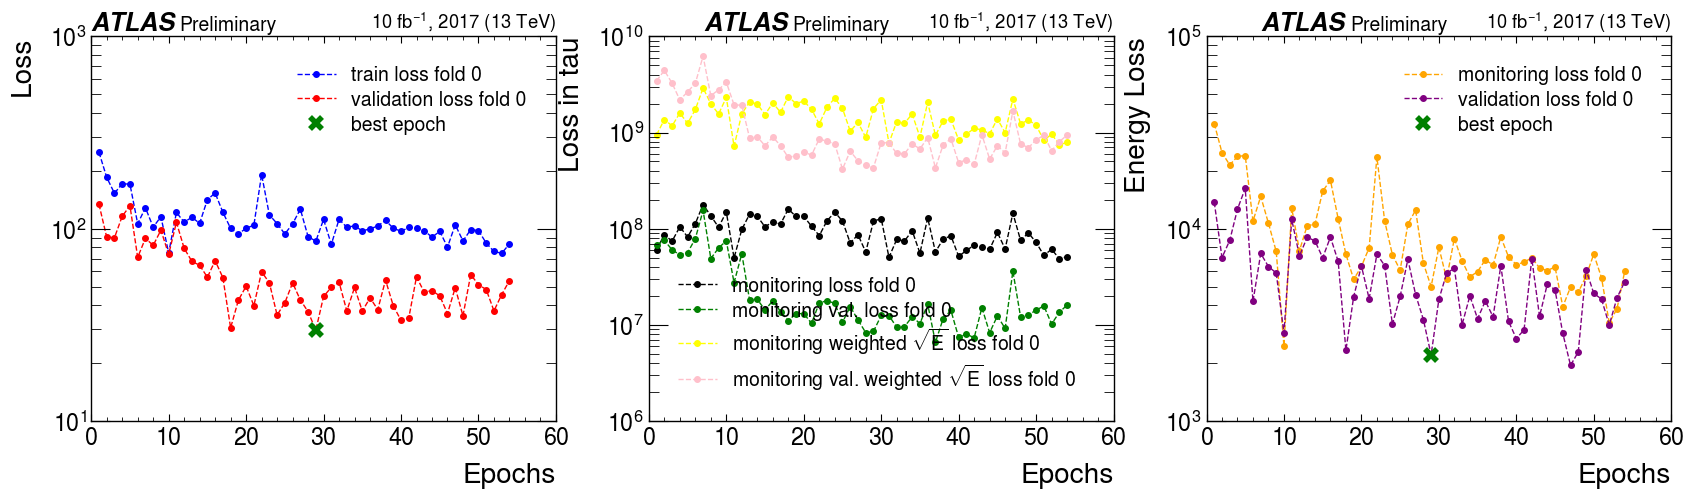

In [4]:
# X['dataset'].shape
# np.arange(100)
# X_test[2]
# train_data
# confDict.tolist()
# nLast = 15

# pathLoss                = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/ml_training/autoencoder/simplesAC_withFolds_ptCut0/'
pathLoss                = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/ml_training/autoencoder/simplestAC_ptCut0/'
k = 5
nLay = 1
neuIn = 24
it = 0
bn=36


# plt.style.use('fivethirtyeight')
for fold in range(k):
    train_logging_dict = np.load(pathLoss+'loss_fold{}_iter{}_neuIn{}_nLay{}_bn{}.npz'.format(fold, it, neuIn, nLay, bn),allow_pickle=True)['loss'].tolist()

    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.plot(range(1,len(train_logging_dict['loss'])+1) ,train_logging_dict['loss']  ,'--.',lw=1, c='blue', label='train loss fold {}'.format(fold))
    plt.plot(range(1,len(train_logging_dict['val_loss'])+1) ,train_logging_dict['val_loss']  ,'--.',lw=1, c='red', label='validation loss fold {}'.format(fold))
    plt.plot(train_logging_dict['best_epoch']+1, np.min(train_logging_dict['val_loss']), 'x', lw=5, markeredgewidth=4, c='green', label='best epoch')
    # plt.plot(range(1,len(train_logging_dict['total_loss'])+1) ,train_logging_dict['total_loss']  ,'--.',lw=1, c='cyan', label='total loss fold {}'.format(fold))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    hep.atlas.label(data=True,paper=False,year=2017, lumi=10,loc=0)
    plt.yscale('log')

    plt.subplot(1,3,2)
    plt.plot(range(1,len(train_logging_dict['tau_loss'])+1) ,train_logging_dict['tau_loss'] ,'--.',lw=1, c='black', label='monitoring loss fold {}'.format(fold))
    plt.plot(range(1,len(train_logging_dict['val_tau_loss'])+1) ,train_logging_dict['val_tau_loss'] ,'--.',lw=1, c='green', label='monitoring val. loss fold {}'.format(fold))
    plt.plot(range(1,len(train_logging_dict['wTauEneLoss'])+1) ,train_logging_dict['wTauEneLoss'] ,'--.',lw=1, c='yellow', label='monitoring weighted '+r'$\sqrt{E}$ loss'+' fold {}'.format(fold))
    plt.plot(range(1,len(train_logging_dict['val_wTauEneLoss'])+1) ,train_logging_dict['val_wTauEneLoss'] ,'--.',lw=1, c='pink', label='monitoring val. weighted '+r'$\sqrt{E}$ loss'+' fold {}'.format(fold))    
    plt.xlabel('Epochs')
    plt.ylabel('Loss in tau')
    hep.atlas.label(data=True,paper=False,year=2017, lumi=10,loc=0)
    plt.legend()
    plt.yscale('log')

    # plt.figure(figsize=(14,5))
    plt.subplot(1,3,3)
    plt.plot(range(1,len(train_logging_dict['ene_loss'])+1) ,train_logging_dict['ene_loss']  ,'--.',lw=1, c='orange', label='monitoring loss fold {}'.format(fold))
    plt.plot(range(1,len(train_logging_dict['val_ene_loss'])+1) ,train_logging_dict['val_ene_loss']  ,'--.',lw=1, c='purple', label='validation loss fold {}'.format(fold))
    plt.plot(train_logging_dict['best_epoch']+1, train_logging_dict['val_ene_loss'][train_logging_dict['best_epoch']], 'x', lw=5, markeredgewidth=4, c='green', label='best epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Energy Loss')
    plt.legend()
    hep.atlas.label(data=True,paper=False,year=2017, lumi=10,loc=0)
    plt.yscale('log')

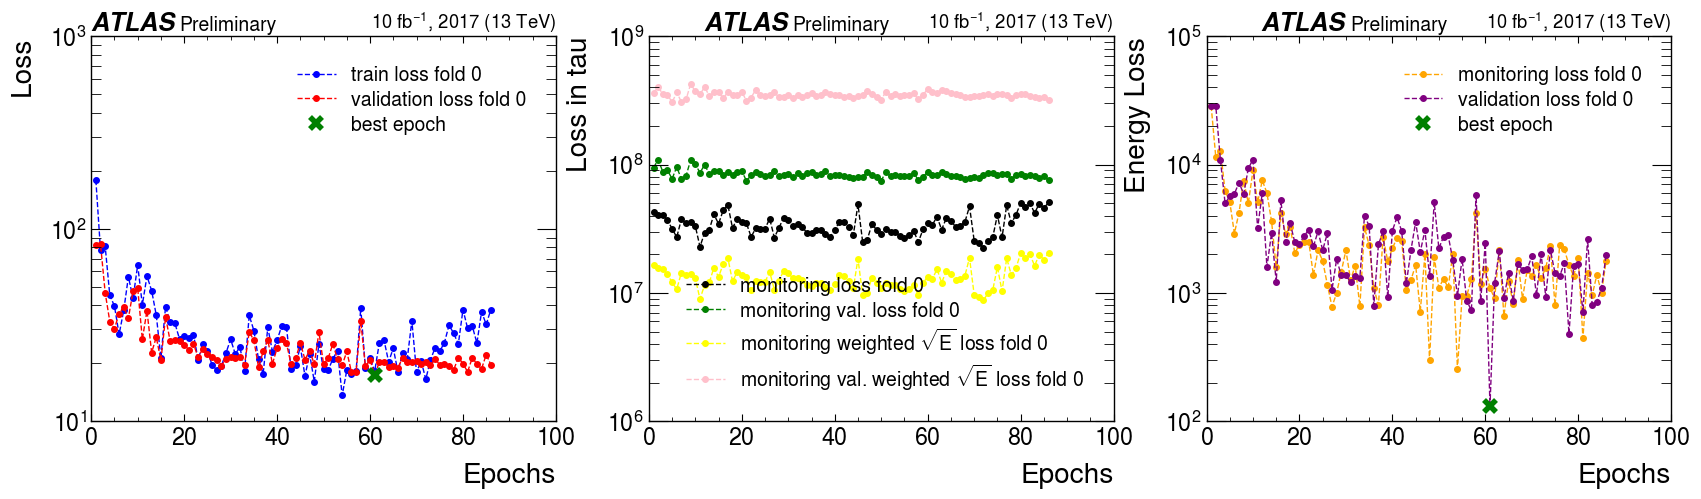

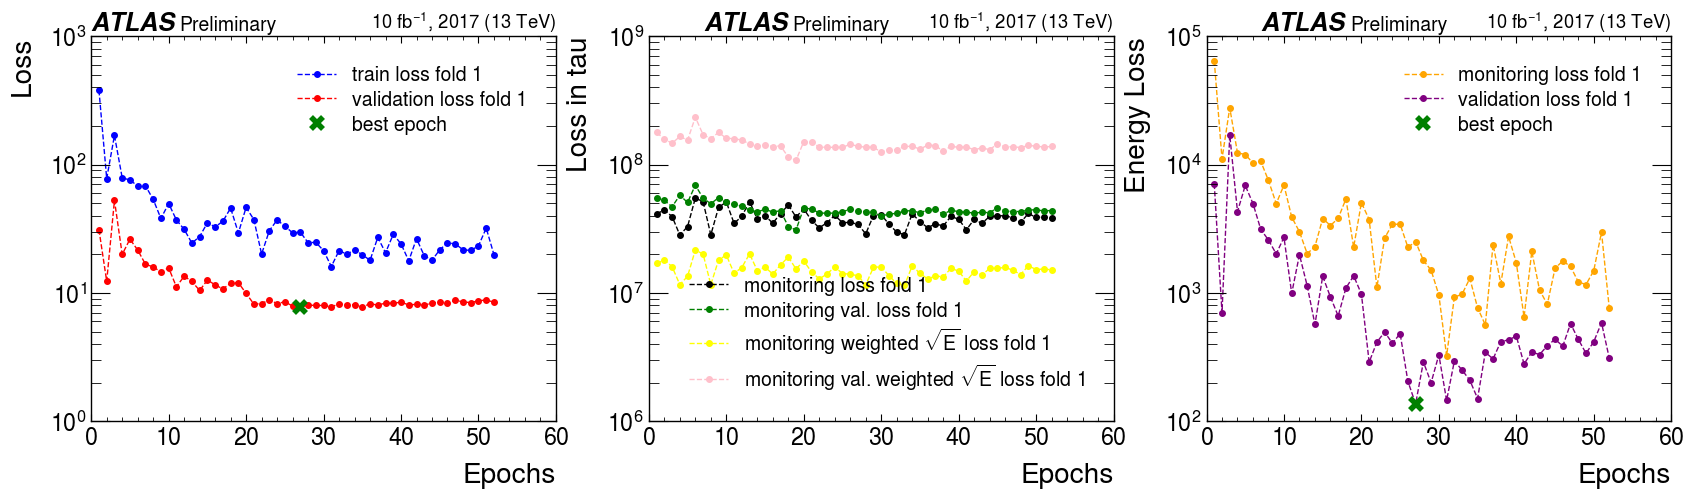

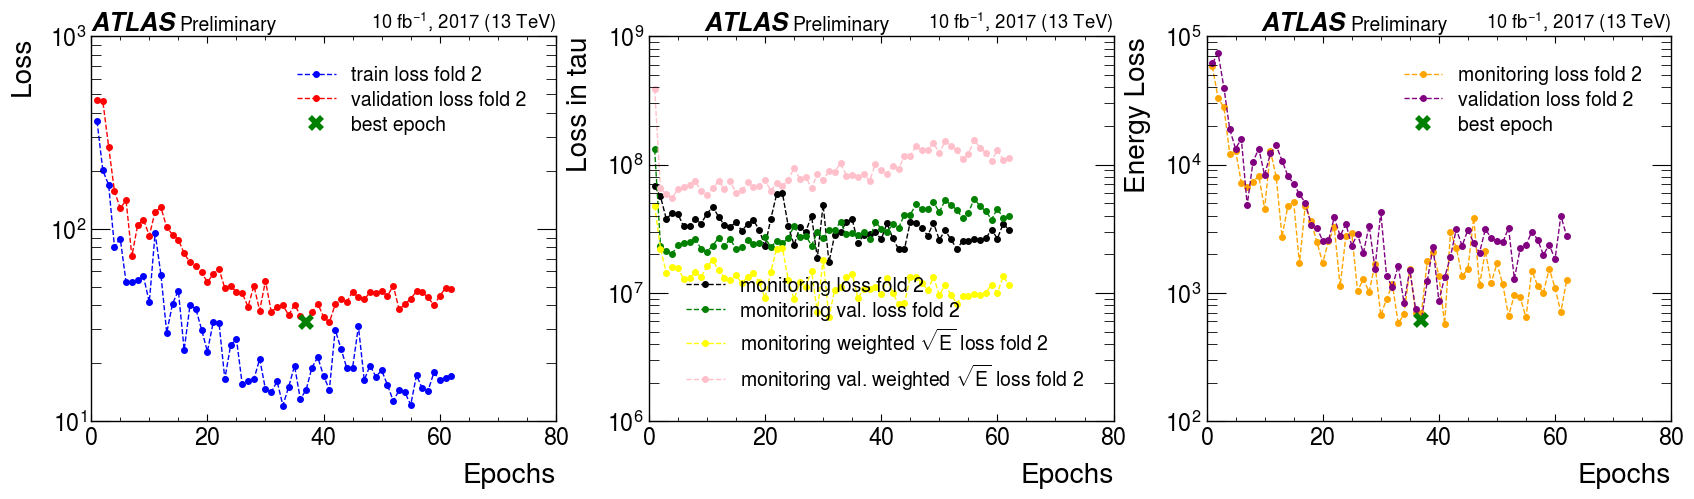

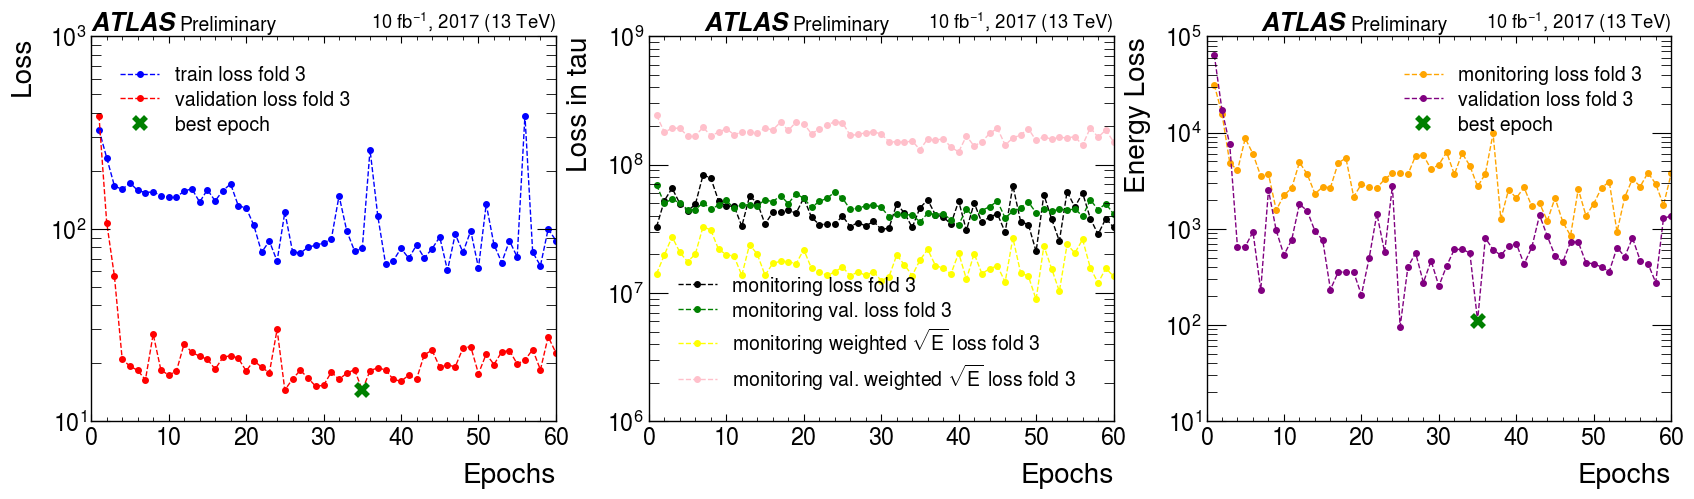

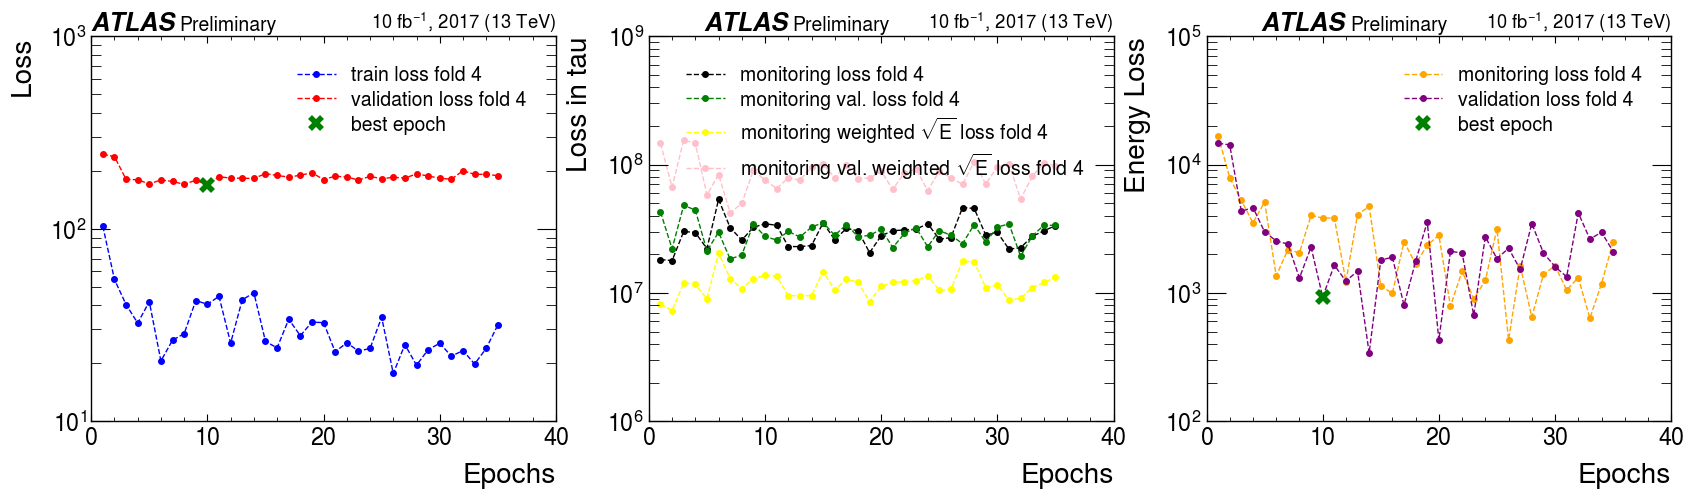

In [6]:
# X['dataset'].shape
# np.arange(100)
# X_test[2]
# train_data
# confDict.tolist()
# nLast = 15

pathLoss                = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/ml_training/autoencoder/simplesAC_withFolds_ptCut0/'
# pathLoss                = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/ml_training/autoencoder/simplestAC/'
k = 5
nLay = 1
neuIn = 24
it = 0
bn=36


# plt.style.use('fivethirtyeight')
for fold in range(k):
    train_logging_dict = np.load(pathLoss+'loss_fold{}_iter{}_neuIn{}_nLay{}_bn{}.npz'.format(fold, it, neuIn, nLay, bn),allow_pickle=True)['loss'].tolist()

    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.plot(range(1,len(train_logging_dict['loss'])+1) ,train_logging_dict['loss']  ,'--.',lw=1, c='blue', label='train loss fold {}'.format(fold))
    plt.plot(range(1,len(train_logging_dict['val_loss'])+1) ,train_logging_dict['val_loss']  ,'--.',lw=1, c='red', label='validation loss fold {}'.format(fold))
    plt.plot(train_logging_dict['best_epoch']+1, np.min(train_logging_dict['val_loss']), 'x', lw=5, markeredgewidth=4, c='green', label='best epoch')
    # plt.plot(range(1,len(train_logging_dict['total_loss'])+1) ,train_logging_dict['total_loss']  ,'--.',lw=1, c='cyan', label='total loss fold {}'.format(fold))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    hep.atlas.label(data=True,paper=False,year=2017, lumi=10,loc=0)
    plt.yscale('log')

    plt.subplot(1,3,2)
    plt.plot(range(1,len(train_logging_dict['tau_loss'])+1) ,train_logging_dict['tau_loss'] ,'--.',lw=1, c='black', label='monitoring loss fold {}'.format(fold))
    plt.plot(range(1,len(train_logging_dict['val_tau_loss'])+1) ,train_logging_dict['val_tau_loss'] ,'--.',lw=1, c='green', label='monitoring val. loss fold {}'.format(fold))
    plt.plot(range(1,len(train_logging_dict['wTauEneLoss'])+1) ,train_logging_dict['wTauEneLoss'] ,'--.',lw=1, c='yellow', label='monitoring weighted '+r'$\sqrt{E}$ loss'+' fold {}'.format(fold))
    plt.plot(range(1,len(train_logging_dict['val_wTauEneLoss'])+1) ,train_logging_dict['val_wTauEneLoss'] ,'--.',lw=1, c='pink', label='monitoring val. weighted '+r'$\sqrt{E}$ loss'+' fold {}'.format(fold))    
    plt.xlabel('Epochs')
    plt.ylabel('Loss in tau')
    hep.atlas.label(data=True,paper=False,year=2017, lumi=10,loc=0)
    plt.legend()
    plt.yscale('log')

    # plt.figure(figsize=(14,5))
    plt.subplot(1,3,3)
    plt.plot(range(1,len(train_logging_dict['ene_loss'])+1) ,train_logging_dict['ene_loss']  ,'--.',lw=1, c='orange', label='monitoring loss fold {}'.format(fold))
    plt.plot(range(1,len(train_logging_dict['val_ene_loss'])+1) ,train_logging_dict['val_ene_loss']  ,'--.',lw=1, c='purple', label='validation loss fold {}'.format(fold))
    plt.plot(train_logging_dict['best_epoch']+1, train_logging_dict['val_ene_loss'][train_logging_dict['best_epoch']], 'x', lw=5, markeredgewidth=4, c='green', label='best epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Energy Loss')
    plt.legend()
    hep.atlas.label(data=True,paper=False,year=2017, lumi=10,loc=0)
    plt.yscale('log')

## 3.3) ML Statistical Analysis

{'experiment_alias': 'learning the samples of a 3x3 window from topocluster at EMB2 layer. The loss for training is the input-output map', 'patience': 3, 'min_delta_loss': 10, 'max_epochs': 100, 'kFolds': 2, 'max_init': 2, 'total_clusters': 100, 'train_ratio': 0.9, 'test_ratio': 0.1, 'cell_win_eta': 3, 'cell_win_phi': 3, 'scaler_input': 0.0002442002442002442, 'scaler_output': 4095, 'neurons_encoder': [36, 256, 128, 64, 32, 16], 'neurons_decoder': [16, 32, 64, 128, 256, 36], 'nNeuronsInput': 256, 'nLayers': 4}
k=0, It: 0
k=0, It: 1
[7140.71533203125, 7930.9228515625] 0
k=1, It: 0
k=1, It: 1
[20143.259765625, 17510.8125] 1
{'best_loss': [15321.40625, 9732.7568359375], 'best_tau_loss': [62261012.0, 72463408.0], 'best_ene_loss': [5912648.5, 3397835.5], 'best_val_loss': [7140.71533203125, 17510.8125]}


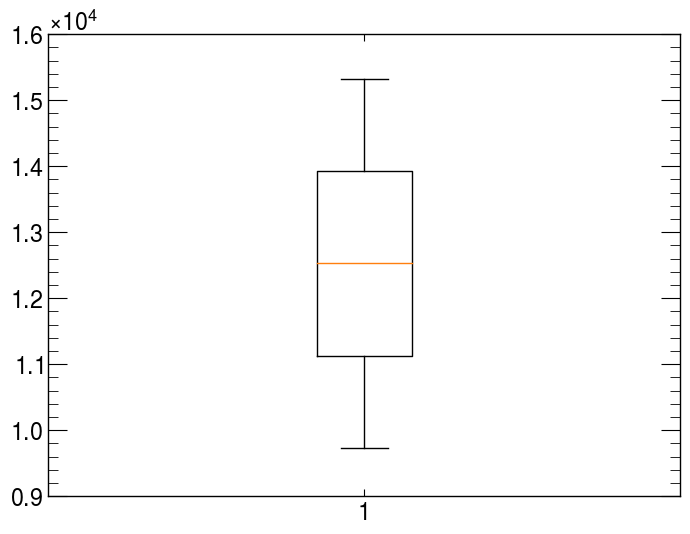

In [69]:
# load models in a loop
pathLoss    = ''
# nNeuronsInput = 256
# nLayers         = 4
config_dict = np.load(pathLoss+'config_train_neuIn{}_nLay{}.npz'.format(nNeuronsInput, nLayers), allow_pickle=True)['config'].tolist()
print(config_dict)

# load all iter result for validation, for each fold
results_dict = {
    'best_loss'      : [],
    'best_tau_loss'  : [],
    'best_ene_loss'  : [],
    'best_val_loss'  : [],
    # ...
}
for nFold in range(0, config_dict['kFolds']):
    val_loss_iter = [] # at best_epoch

    for it in range(0, config_dict['max_init']):
        ## find best initialization
        train_log = np.load(pathLoss+'loss_fold{}_iter{}_neuIn{}_nLay{}.npz'.format(nFold, it, config_dict['nNeuronsInput'], config_dict['nLayers']), allow_pickle=True)['loss'].tolist()
        print('k={}, It: {}'.format(nFold, it))
        val_loss_iter.append( float(train_log['val_loss'][train_log['best_epoch']]) )
    
    print(val_loss_iter, np.argmin(val_loss_iter))
    best_iter = np.argmin(val_loss_iter)

    ## get uncertainties from best val_loss
    train_log = np.load(pathLoss+'loss_fold{}_iter{}_neuIn{}_nLay{}.npz'.format(nFold, best_iter, config_dict['nNeuronsInput'], config_dict['nLayers']), allow_pickle=True)['loss'].tolist()
    results_dict['best_loss'].append( float(train_log['loss'][train_log['best_epoch']]) )
    results_dict['best_val_loss'].append( float(train_log['val_loss'][train_log['best_epoch']]) )
    results_dict['best_ene_loss'].append( float(train_log['ene_loss'][train_log['best_epoch']]) )
    results_dict['best_tau_loss'].append( float(train_log['tau_loss'][train_log['best_epoch']]) )

# all 10 results will give minimized initialization and dataset uncertainties
print(results_dict)

plt.figure()
plt.boxplot(results_dict['best_loss'])
plt.show()



### - Dev. Helpers

In [45]:
def getCellsInWindowCustomSizeNEW(
                     cellEneList, 
                     cellIndexList, 
                     cellEtaList, 
                     cellPhiList, 
                     cellSamplingList, 
                     nCellsEta, 
                     nCellsPhi, 
                     DEtaList,
                     DPhiList,
                     layer='EMB2',
                     fullCluster=False):
    ''' 
    Create a nCellsEta x nCellsPhi cell ROI.
    
    # Return the indexes of the array of cells. 
    # This array is composed of a sub-array of the cluster, with only the cells of the selected layer.
    # window        : set of positional index inside sub-array, which belongs to the window
    # layerIndexes  : array of indexes of all cells from chosen layer.'''
   
    # get the hot cell pos and value (for the layer)
    layerIndexes      = getMatchedIndexes(cellSamplingList[0], layer)
    
    if fullCluster == True:
        return layerIndexes

    if np.size( layerIndexes ) == 0:
        return [], []
    
    # determine the window size in eta x phi
    if layer=='EMB2':
        deta = 0.025#00000037252903
        dphi = 0.024#54369328916073
    else:
        deta = np.min(np.array(DEtaList[0])[layerIndexes])
        dphi = np.min(np.array(DPhiList[0])[layerIndexes])

    etaSize = nCellsEta * deta
    phiSize = nCellsPhi * dphi  
    
    # print(deta,etaSize,dphi,phiSize)
    
    hotCellValue    = np.max(np.array(cellEneList[0])[layerIndexes])
    hotCellPos      = np.argmax(np.array(cellEneList[0])[layerIndexes])
    hotCellEta      = np.array(cellEtaList[0])[layerIndexes][hotCellPos]
    hotCellPhi      = np.array(cellPhiList[0])[layerIndexes][hotCellPos]
    # print('hotcell position: ',hotCellEta,hotCellPhi,', granularity: ',np.array(DEtaList[0])[layerIndexes][hotCellPos],np.array(DPhiList[0])[layerIndexes][hotCellPos])
    
    window          = [] # list of indexes of the cells inside the chosen window
    
    # find cells within limits of eta phi window
    # for sampling, ind, eta, phi in zip(cellSamplingList, cellIndexList[0], cellEtaList[0], cellPhiList[0]):
    for ind, eta, phi in zip(layerIndexes, np.array(cellEtaList[0])[layerIndexes], np.array(cellPhiList[0])[layerIndexes]):
        etaConditionL    = eta > (cellEtaList[0][hotCellPos] - etaSize/2)
        etaConditionR    = eta < (cellEtaList[0][hotCellPos] + etaSize/2)
#         phiConditionU    = phi >= correctPhi( (cellPhiList[0][hotCellPos] - phiSize/2) )
#         phiConditionD    = phi <= correctPhi( (cellPhiList[0][hotCellPos] + phiSize/2) )
        
        lowerPhiRange    = np.array(cellPhiList[0])[layerIndexes][hotCellPos] - phiSize/2
        upperPhiRange    = np.array(cellPhiList[0])[layerIndexes][hotCellPos] + phiSize/2
        
        bPhiOverFlow = ( (lowerPhiRange < (-1)*math.pi) or (lowerPhiRange > 1*math.pi) or (upperPhiRange < (-1)*math.pi) or (upperPhiRange > 1*math.pi) )
            
            # if overflows, need to include the discontinuity in the middle of the interval.
        if bPhiOverFlow:
            phiCondition = (((phi >= correctPhi(lowerPhiRange)) and (phi <= 1*math.pi)) or ((phi <= correctPhi(upperPhiRange)) and (phi >= (-1)*math.pi)))
        else:
            phiCondition = ((phi >= lowerPhiRange) and (phi <= upperPhiRange))
        
        if (etaConditionL and etaConditionR) and phiCondition:
            window.append( ind ) # add them to a list of index cells
            if len(window) >= ( nCellsEta * nCellsPhi ):
                break
                

    return np.asarray(window), np.asarray(layerIndexes), hotCellPos

def getSortedClusterIndexes(eta,phi):
    '''Return the indexes of an organized sequence of pairs of eta,phi, following a line from the smallest phi's, then the smallest eta's. '''
    ind = np.lexsort((eta,phi)) 
    return ind

def unpackCellsFromCluster(dataset_cluster, confDict, ped_dict={}):
    # get list indexes that match to current sampling
    channelLayerIndexes     = getMatchedIndexes(dataset_cluster['channels']['sampling'][0], confDict['sampling']) 
    # rawChannelLayerIndexes  = getMatchedIndexes(ev['electrons'][elec][clusName][clus]['rawChannels']['sampling'][0], layer)

    # is that layer empty for RAWCh or Ch? skip
    if (len(channelLayerIndexes) == 0 ): # or (len(rawChannelLayerIndexes)==0):
        return 0

    ###################     ###############
    ## Channel + Digits  +  ## RawChannel #
    ###################     ###############
    windowIndexesCh, layerIndexesCh, hotCellPos = getCellsInWindowCustomSizeNEW(
        dataset_cluster['channels']['energy'],
        dataset_cluster['channels']['index'],
        dataset_cluster['channels']['eta'],
        dataset_cluster['channels']['phi'],
        dataset_cluster['channels']['sampling'],
        confDict['nCellsWinEta'], 
        confDict['nCellsWinPhi'], 
        dataset_cluster['channels']['deta'],
        dataset_cluster['channels']['dphi'],
        layer=confDict['sampling'])

    # any of the windows aren't full??
    if confDict['bFullWindows']:
        if (len(windowIndexesCh) != (nCellsWinEta*nCellsWinPhi)):# or (len(windowIndexesRawCh) != (nCellsWinEta*nCellsWinPhi)):
            return 0

    # if they belong to the same calo object and have the same size, they MUST have the same cells, because the dumper rule is the same.
    digits              = np.array(dataset_cluster['channels']['digits'][0],dtype=object)
    digitsSize          = len (np.array(dataset_cluster['channels']['digits'][0],dtype=object))
    channelEnergy       = np.array(dataset_cluster['channels']['energy'][0],dtype=object)
    channelTime         = np.array(dataset_cluster['channels']['time'][0],dtype=object)
    # channelInfo         = listOfListsToArrayOfArrays(np.array(dataset_cluster['channels']['chInfo'][0],dtype=object))
    channelInfo         = np.array(dataset_cluster['channels']['chInfo'][0],dtype=object)
    channelId           = np.array(dataset_cluster['channels']['channelId'][0],dtype=object)
    channelSampling     = np.array(dataset_cluster['channels']['sampling'][0],dtype=object)
    channelEta          = np.array(dataset_cluster['channels']['eta'][0],dtype=object)
    channelPhi          = np.array(dataset_cluster['channels']['phi'][0],dtype=object)
    channelDEta         = np.array(dataset_cluster['channels']['deta'][0],dtype=object)
    channelDPhi         = np.array(dataset_cluster['channels']['dphi'][0],dtype=object)
    channelGain         = np.array(dataset_cluster['channels']['gain'][0],dtype=object)
    channelDSPThr       = np.array(dataset_cluster['channels']['DSPThreshold'][0],dtype=object)
    channelOFCa         = np.array(dataset_cluster['channels']['OFCa'][0],dtype=object)
    channelOFCb         = np.array(dataset_cluster['channels']['OFCb'][0],dtype=object)
    channelRamps0       = np.array(dataset_cluster['channels']['ADC2MeV0'][0],dtype=object)
    channelRamps1       = np.array(dataset_cluster['channels']['ADC2MeV1'][0],dtype=object)
    channelLArPed       = np.array(dataset_cluster['channels']['LArDB_Pedestal'][0],dtype=object)
    channelTimeOffset   = np.array(dataset_cluster['channels']['OFCTimeOffset'][0],dtype=object)
    channelEffSigma     = np.array(dataset_cluster['channels']['effSigma'][0],dtype=object)
    # channelNoise        = np.array(dataset_cluster['channels']['noise'][0],dtype=object)          [windowIndexesCh] .tolist()
    # channelShape        = np.array(ev['electrons'][elec][clusName][clus]['channels']['Shape'][0],dtype=object)          [windowIndexesCh] .tolist()
    
    # if bDoOfflineCalib:
    #     channelMinBiasAvg   = np.array(dataset_cluster['channels']['MinBiasAvg'][0],dtype=object)     [windowIndexesCh] .tolist()
    #     channelOfflHV       = np.array(dataset_cluster['channels']['OfflHVScale'][0],dtype=object)    [windowIndexesCh] .tolist()
    #     channelEneResc      = np.array(dataset_cluster['channels']['OfflEneRescaler'][0],dtype=object)[windowIndexesCh] .tolist()
    # print('sampling size:',len(channelSampling))
    # print('eta size:', len(channelEta))

    # Selection of Pedestal (DB or Script)
    if not(confDict['bPedFromDB']):
        peds = [] #testing
        gainsInt = getGainInteger(channelGain)
    if confDict['bPedFromDB']:
        peds = channelLArPed

    # The cells that came from Window algorithm are not the same when comparing RawCh and Digits.
    # For that, we will select the same Digits cells set, based on the HWID, inside the Raw Channel cluster cells set. 
    # mirrorIndexes = []
    for k, hwid in enumerate(channelId):
        # position        = np.where(np.array(ev['electrons'][elec][clusKey][clus]['channels']['channelId'][0],dtype=object)[layerIndexesCh] == hwid)[0][0]
        # mirrorIndexes.append(position) # its the window mirrored indexes for RawCh
        if not(confDict['bPedFromDB']):
            cell_dict_ped   = getLArChannelPED  (hwid, ped_dict  )
            peds.append(cell_dict_ped['ped'][0][gainsInt[k]]) # picking up the right gain weights


    orderedIndexes = getSortedClusterIndexes(channelEta[windowIndexesCh], channelPhi[windowIndexesCh])
    
    ml_dataset = {
        'orderedIndexes'    : orderedIndexes,
        'windowIndexesCh'   : windowIndexesCh,
        'layerIndexesCh'    : layerIndexesCh,
        'hotcellposition'   : hotCellPos,
        'digits'            : digits,
        'digitsSize'        : digitsSize,
        'channelEnergy'     : channelEnergy,
        'channelTime'       : channelTime,
        'channelInfo'       : channelInfo,
        'channelId'         : channelId,
        'channelSampling'   : channelSampling,
        'channelEta'        : channelEta,
        'channelPhi'        : channelPhi,
        'channelDEta'       : channelDEta,
        'channelDPhi'       : channelDPhi,
        'channelGain'       : channelGain,
        'channelDSPThr'     : channelDSPThr,
        'channelOFCa'       : channelOFCa,
        'channelOFCb'       : channelOFCb,
        'channelRamps0'     : channelRamps0,
        'channelRamps1'     : channelRamps1,
        'channelLArPed'     : peds,
        'channelTimeOffset' : channelTimeOffset,
        'channelEffSigma'   : channelEffSigma,
        # 'channelNoise'      : channelNoise,
    }
    

    # for key in ml_dataset.keys():
    #     if bReturnOrderedInWindow:
    #         ml_dataset[key] = np.array(ml_dataset[key],dtype=object)
    #     else:
    #         ml_dataset[key] = np.array(ml_dataset[key],dtype=object)
    

    return ml_dataset


# 4.0) Dataset generation

In [20]:
#---------------------------------------------
#----------   Read the ROOT trees   ----------
#---------------------------------------------
clus_train          = 100 #nClusters to being user to train the model
clusName            = 'topocluster'#,'7x11' #
# datasetPath         ='/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_TagAndProbe_v01_XYZ.root.tgz/*XYZ.root'
datasetPath         = '/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_v01_XYZ.root.tgz/*XYZ.root'
datasetAlias        = 'TEST'#'singlElec' #Zee
bFullWindows        = True # use only full windows from clusters
bDoOfflineCalib     = False
el_thr              = 0 # GeV
nCellsWinEta        = 3
nCellsWinPhi        = 3
calibType           = 'dumper' # name of the type of calibration, to differentiate from offline or database (analysis/debug) #'database'#'database' #'typical' # or 
layer               = 'EMB2'
loopModeType        = 'cluster' # or 'event'

# #---------------------------------------------

fileNames       = glob(datasetPath)

sTree   = ROOT.TChain("dumpedData",'')
sLBTree = ROOT.TChain("lumiblockData",'')
for file in fileNames:
    fileNameInputLog = "/".join((file+" added to the TChain...").split('/')[-2:])
    # print(fileNameInputLog) 
    sTree.Add(file+"/dumpedData") # main dumped data tree (event by event)
    sLBTree.Add(file+"/lumiblockData") # LB tree (lumiblock per lumiblock)

if clusName == 'topocluster':
    sTree.SetBranchStatus("cluster711_*",0)
    clusKey = "clusters"
if clusName == '7x11':
    sTree.SetBranchStatus("cluster_*",0)
    clusKey = '711_roi'


nEvents         = sTree.GetEntries()
nLumiBlocks     = sLBTree.GetEntries()

print("{} files were added with {} events.".format(len(fileNames),nEvents))


#---------------------------------------------
#--------- Data Analysis conditions ----------
#---------------------------------------------
evt_lim             = nEvents
bPlotClusters       = False
bPedFromDB          = True # Ped from DB (TRUE) or from Script (FALSE)

#---------------------------------------------
#------------- DSP conditions #------------- < Not getting nice results from quantization. Ignore those *Quant* boolean options. >
#---------------------------------------------
typeThreshold       = 'EneThr'#'fixedValue'#'EneThr'#'NoiseSigma'#
bAbsDSPE1           = False # ~X~ use abs(E) to get E1, and compare to E_thr
bPerfomQuant        = False # ~X~ apply the quantized form of energy and time estimation (like DSP)
applyCteQuant       = False # ~X~ True # apply quantization to the alpha, beta, Pa, Pb. If False, use likeDSP function, but full precision constants.
reorderSamp         = False # ~X~ reorder samples like-dsp

confDict = {
    'el_thr'            : el_thr,
    'sampling'          : layer,
    'nCellsWinEta'      : nCellsWinEta,
    'nCellsWinPhi'      : nCellsWinPhi,
    'datasetPath'       : datasetPath,
    'calibType'         : calibType,
    'bFullWindows'      : bFullWindows,
    'bPedFromDB'        : bPedFromDB,
    'bDoOfflineCalib'   : bDoOfflineCalib,
    'typeThreshold'     : typeThreshold,
    'bAbsDSPE1'         : bAbsDSPE1,
    'bPerfomQuant'      : bPerfomQuant,
    'applyCteQuant'     : applyCteQuant,
    'reorderSamp'       : reorderSamp,
    'fileNames'         : fileNames
}

#---------------------------------------------
#------- Online Calibration constants --------
#---------------------------------------------

ped_dict = {}
if calibType=='database':
    ofc_dict = np.load('calibration/OFC_dict.npz',allow_pickle=True )['OFC'].tolist()
    ped_dict = np.load('calibration/PED_dict.npz',allow_pickle=True )['PED'].tolist()
    mpmc_dict = np.load('calibration/MPMC_dict.npz',allow_pickle=True )['MPMC'].tolist()
    uamev_dict = np.load('calibration/UAMEV_dict.npz',allow_pickle=True )['UAMEV'].tolist()
    ramps_dict = np.load('calibration/RAMPS_dict.npz',allow_pickle=True )['RAMPS'].tolist()


#---------------------------------------------
#--------- Event and Data Reading ------------
#---------------------------------------------
print('Calibration type: {}'.format(calibType))
print('Electron pt cut: {} GeV'.format(el_thr))
print('Processing cluster: {}'.format(clusName))

# for epoch in range(epochs):
#     print('Epoch: {}...'.format(epoch))

dataset_list    = []

elec_counter    = 0 # counter of electrons in dataset
clus_counter    = 0
bMaxClusters    = False

#---------------------------------------------
#------ TTree Loop and data extraction -------
#---------------------------------------------
meanTimePerEvent = 0.0
startTime = time()

for evIndex in range(0, nEvents): ## Loop events into TTree
    if bMaxClusters:
        break
    
    if loopModeType=='event':
        if evIndex > evt_lim:
            break
        if (evIndex%int(evt_lim/5)) == 0:
            print("Event {}/{}...".format(evIndex,evt_lim))

    # dataset = getXTDataAsPythonDict(sTree, evIndex, eventReaderSharePath, dataHasBadCh=True, isMC=False)
    dataset = getXTDataAsPythonDictFaster(sTree, evIndex, eventReaderSharePath, dataHasBadCh=True, isMC=False, clusterType=clusName) #<- apply sTree.GetEntry(evIndex) here!

    if dataset==0: # Data has no electrons in this event!
        continue

    for evtn, ev in enumerate(dataset['dataset']): # for each event...
    # with dataset['dataset'] as ev:
        for elec in ev['electrons'].keys(): # for each electron in this event...
            if bMaxClusters:
                break
            # print(ev['electrons'][elec]['pt'])
            if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
                continue
            if np.abs(ev['electrons'][elec]['eta']) > 1.4:
                continue
            # datasetML = dataset ## Test

            clusloop        = ev['electrons'][elec][clusKey]

            # elecPt          = (ev['electrons'][elec]['pt'])
            # elecEta         = (ev['electrons'][elec]['eta'])
            # elecPhi         = (ev['electrons'][elec]['phi'])
            # elecVtxZ        = (ev['electrons'][elec]['vertexZ'])
            # elecNClus       = len(ev['electrons'][elec][clusKey])
            
            for clus in clusloop.keys(): # for each cluster associated to that electron...
                if loopModeType=='cluster':
                    if clus_train != -1:
                        if clus_counter > clus_train:
                            bMaxClusters = True
                            break

                
                #---------------------------------------------
                #------- Cluster Dataset Processing ----------
                #---------------------------------------------
                dataset_cluster = ev['electrons'][elec][clusKey][clus]

                datasetML       = unpackCellsFromCluster(dataset_cluster, confDict, ped_dict=ped_dict)
                
                if datasetML == 0: # Selected sampling has no cells!
                    # print(' Selected sampling has no cells!')
                    continue
                
                if clus_train != -1:
                    if(clus_counter%int(clus_train/5))==0:
                        print('\t{}/{} clusters were dumped so far...(Event index: {})'.format(clus_counter,clus_train,evIndex))
                else:
                    if(clus_counter%20)==0:
                        print('\t{} clusters were dumped so far...(Event index: {})'.format(clus_counter,clus_train,evIndex))
                
                dataset_list.append(datasetML)

                clus_counter+=1

                if bMaxClusters:
                    break
            elec_counter+=1

            if bMaxClusters:
                break
        if bMaxClusters:
            break
    if bMaxClusters:
        break
#
# End of the current Epoch
#
# dataset_list['loss'].append(loss.detach().numpy())
# train_logging_dict['loss_tau'].append(loss_tau.detach().numpy())

confDict['elec_counter'] = elec_counter
print('Total Electrons: ',elec_counter)
print('Total clusters: ', clus_counter)
# print(confDict)
endTime = time()

print("Total running time: {:.2f} minutes. ({:.2f} us/event)".format((endTime - startTime)/60, (endTime - startTime)/3600*1000000/evt_lim))

#
# Save the results
#
datasetName     = 'dataset_{}_ptCut{}_{}_sampWin{}-{}_nClus{}.npz'.format(datasetAlias, el_thr, clusName, nCellsWinEta, nCellsWinPhi, clus_counter)
confFileName    = 'datasetInfo_{}_ptCut{}_{}_sampWin{}-{}_nClus{}.npz'.format(datasetAlias, el_thr, clusName, nCellsWinEta, nCellsWinPhi, clus_counter)
np.savez(datasetName,dataset=dataset_list)
print(datasetName,' saved.')
np.savez(confFileName, datasetInfo=confDict)
print(confFileName, 'saved.')



56 files were added with 8573826 events.
Calibration type: dumper
Electron pt cut: 0 GeV
Processing cluster: topocluster
	0/100 clusters were dumped so far...(Event index: 20)
	20/100 clusters were dumped so far...(Event index: 9029)
	40/100 clusters were dumped so far...(Event index: 13907)
	60/100 clusters were dumped so far...(Event index: 20853)
	80/100 clusters were dumped so far...(Event index: 26786)
	100/100 clusters were dumped so far...(Event index: 31927)
Total Electrons:  1958
Total clusters:  101
Total running time: 1.44 minutes. (0.00 us/event)
dataset_TEST_ptCut0_topocluster_sampWin3-3_nClus101.npz  saved.
datasetInfo_TEST_ptCut0_topocluster_sampWin3-3_nClus101.npz saved.


## Verify if center cell is the hottest

In [26]:
def orderedIndexes(eta,phi,order='eta'):
    '''The eta and phi indexes will be ordered depending of the axis (order) selected.
    '''
    orderedArray = np.zeros([3,3])
    if order=='eta':
        orderedInd   = np.argsort(eta)
    elif order=='phi':
        orderedInd   = np.argsort(phi)
    else:
        print("Error! order should be eta or phi!")
        return -1

    return orderedInd

etaOrdered  = orderedIndexes(eta[window], phi[window])

print(energy[window][etaOrdered])

[223.2729034423828 381.68341064453125 245.84054565429688 409.2996826171875
 1249.44384765625 243.7288360595703 257.67333984375 616.952880859375
 203.06118774414062]


In [29]:
# print('energy',energy)
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

for clusIdx in range(0, len(dataset_list)):
    
    energy          = dataset_list[clusIdx]['channelEnergy']
    sampling        = dataset_list[clusIdx]['channelSampling']
    eta             = dataset_list[clusIdx]['channelEta']
    phi             = dataset_list[clusIdx]['channelPhi']
    hotcellposition = dataset_list[clusIdx]['hotcellposition']
    layerIndexesCh  = dataset_list[clusIdx]['layerIndexesCh']
    winIndexes      = dataset_list[clusIdx]['windowIndexesCh'][dataset_list[0]['orderedIndexes']].tolist()

    # if bPlotClusters:
    X = np.array(dataset_list[clusIdx]['channelEta'])
    Y = np.array(dataset_list[clusIdx]['channelPhi'])
    Z = np.array(dataset_list[clusIdx]['channelEnergy'])

    window  = np.array(dataset_list[clusIdx]['windowIndexesCh'])
    layer   = np.array(dataset_list[clusIdx]['layerIndexesCh'])
    deta    = np.array(dataset_list[clusIdx]['channelDEta'])
    dphi    = np.array(dataset_list[clusIdx]['channelDPhi'])
    

    # fig, ax = plt.subplots(figsize=(10,10))                
    # plt.scatter(X[layer],Y[layer],c=Z[layer], s=200,marker='s',cmap='summer')
    # plt.scatter(X[window],Y[window],fc='none',ec='red',s=400, marker='o')
    # plt.scatter(X[layer][dataset_list[clusIdx]['hotcellposition']], Y[layer][dataset_list[clusIdx]['hotcellposition']], fc='none',ec='black',marker='x')
    # plt.colorbar()
    # plt.savefig('/eos/user/m/mhufnage/SWAN_projects/XTalk/Plots/clusterWindow/cluster{}-{}_{}.png'.format(nCellsWinEta,nCellsWinPhi,clusIdx))
    # plt.close(fig)
    # plt.show()

    etaOrdered=orderedIndexes(eta[window], phi[window])
    centerCellIsHottest = energy[window][etaOrdered][4] == np.max(energy[window][etaOrdered])
    if not(centerCellIsHottest):
        print( 'Cluster {}'.format(clusIdx))
        # print( energy[winIndexes])
        
        print(energy[window][etaOrdered])

        print('eta', eta[window][etaOrdered])
        print('phi', phi[window][etaOrdered])
        print('deta', deta[window][etaOrdered])
        print('dphi', dphi[window][etaOrdered])

        # print( energy[winIndexes][6:9])
        # print( energy[winIndexes][3:6])
        # print( energy[winIndexes][0:3])

        # print('eta', eta[winIndexes][6:9])
        # print('eta', eta[winIndexes][3:6])
        # print('eta', eta[winIndexes][0:3])

        # print('phi', phi[winIndexes][6:9])
        # print('phi', phi[winIndexes][3:6])
        # print('phi', phi[winIndexes][0:3])

        # print('deta', deta[winIndexes][6:9])
        # print('deta', deta[winIndexes][3:6])
        # print('deta', deta[winIndexes][0:3])

        # print('dphi', dphi[winIndexes][6:9])
        # print('dphi', dphi[winIndexes][3:6])
        # print('dphi', dphi[winIndexes][0:3])

        print('hotcellposition: {}, eta: {}, phi: {}, ene: {}'.format(hotcellposition, eta[layerIndexesCh][hotcellposition], phi[layerIndexesCh][hotcellposition], energy[layerIndexesCh][hotcellposition]) )
        print( 'centerCellIsHottest? ', centerCellIsHottest)


tab completion not implemented for this context


## 3.2) Test Uproot


In [25]:
# datasetPath ='/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_TagAndProbe_v01_XYZ.root.tgz/*XYZ.root'
datasetPath = '/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_v01_XYZ.root.tgz/*XYZ.root'

#---------------------------------------------
#--------- Data Analysis conditions ---------
#---------------------------------------------
evt_lim             = 1000#nEvents
bPedFromDB          = True # Ped from DB (TRUE) or from Script (FALSE)
bFullWindows        = False # use only full windows from clusters
bDoOfflineCalib     = False
el_thrs             = 10 # GeV
nCellsWinEta        = 3
nCellsWinPhi        = 3
clusName           = 'cluster_*'#,'cluster711_*'] #'clusters'
calibType          = 'dumper' # name of the type of calibration, to differentiate from offline or database (analysis/debug) #'database'#'database' #'typical' # or 
layers              = caloDict["Layer"][0:4]

#---------------------------------------------
#------------- DSP conditions #------------- < Not getting nice results from quantization. Ignore those *Quant* boolean options. >
#---------------------------------------------
typeThreshold       = 'EneThr'# applied to DSP!! 'fixedValue'#'EneThr'#'NoiseSigma'#
bAbsDSPE1           = False # ~X~ use abs(E) to get E1, and compare to E_thr
bPerfomQuant        = False # ~X~ apply the quantized form of energy and time estimation (like DSP)
applyCteQuant       = False # ~X~ True # apply quantization to the alpha, beta, Pa, Pb. If False, use likeDSP function, but full precision constants.
reorderSamp         = False # ~X~ reorder samples like-dsp

datasetPathTreeNames = [name+':dumpedData/' for name in glob(datasetPath)]


start = time()
for fileName in datasetPathTreeNames:
    print(fileName)
    # data = ak.Array([])
    with uproot.open(fileName, file_handler=uproot.MultithreadedFileSource,num_workers=8) as sTree:

        keys = sTree.keys(filter_name=["vtx_*",clusName,"el_*","event_*"])        
        data = sTree.arrays()[keys]

        ## Masks
        print('Applying masks...')
        mask_elPt           = data['el_Pt'] > el_thrs*10000
        mask_elEta          = abs(data['el_Eta']) < 1.4
        mask_psb            = data['cluster_cell_layer'] == 0
        mask_emb1           = data['cluster_cell_layer'] == 1
        mask_emb2           = data['cluster_cell_layer'] == 2
        mask_emb3           = data['cluster_cell_layer'] == 3
        mask_passWinSize    = ak.count(data['cluster_channel_eta'])

        print('Masks applied.')
        break

        # electrons = sTree.arrays(keys)
        # vtx = sTree.arrays(keys)

endTime = time()
print("Total running time: {:.2f} seconds.".format((endTime - start)))

/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_v01_XYZ.root.tgz/user.mhufnage.33659288._000001.XYZ.root:dumpedData/


Applying masks...
Masks applied.
Total running time: 118.48 seconds.


In [46]:
ak.count(data['cluster_channel_index'],axis=1)

<Array [0, 0, 34, 0, 0, 0, ... 0, 0, 0, 13, 0] type='21000 * int64'>

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(21000,)

In [40]:
# mask_singleElectron = data.el_Pt < 2000
# print(np.sum(mask_singleElectron))
# data['cluster_cell_layer']
plt.hist(ak.flatten(data['cluster_channel_digits'][mask_elPt]), bins=50)
plt.show()

In [9]:
sTree.keys()

['event_RunNumber',
 'event_EventNumber',
 'event_BCID',
 'event_Lumiblock',
 'event_avg_mu_inTimePU',
 'event_avg_mu_OOTimePU',
 'cluster_index',
 'c_electronIndex_clusterLvl',
 'cluster_et',
 'cluster_time',
 'cluster_pt',
 'cluster_eta',
 'cluster_phi',
 'cluster_index_cellLvl',
 'cluster_cell_index',
 'cluster_cell_caloGain',
 'cluster_cell_layer',
 'cluster_cell_region',
 'cluster_cell_energy',
 'cluster_cell_eta',
 'cluster_cell_phi',
 'cluster_cell_deta',
 'cluster_cell_dphi',
 'cluster_cellsDist_dphi',
 'cluster_cellsDist_deta',
 'cluster_nCells_PS',
 'cluster_nCells_EMB1',
 'cluster_nCells_EMB2',
 'cluster_nCells_EMB3',
 'cluster_index_chLvl',
 'cluster_channel_index',
 'cluster_channel_digits',
 'cluster_channel_energy',
 'cluster_channel_time',
 'cluster_channel_bad',
 'cluster_channel_chInfo',
 'cluster_channel_hash',
 'cluster_channel_id',
 'cluster_channel_effSigma',
 'cluster_channel_noise',
 'cluster_channel_DSPThreshold',
 'cluster_channel_OFCTimeOffset',
 'cluster_cha

In [9]:
#---------------------------------------------
#--------- Event and Data Reading ------------
#---------------------------------------------

# datasetPath = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/minbias_vertexAnalysis/*'
datasetPath ='/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_TagAndProbe_v01_XYZ.root.tgz/*XYZ.root'
# datasetPath = '/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_v01_XYZ.root.tgz/*XYZ.root'

#---------------------------------------------
#----------   Read the ROOT trees   ----------
#---------------------------------------------
fileNames       = glob(datasetPath)

sTree   = ROOT.TChain("dumpedData",'')
sLBTree = ROOT.TChain("lumiblockData",'')
for file in fileNames:
    fileNameInputLog = "/".join((file+" added to the TChain...").split('/')[-2:])
    # print(fileNameInputLog) 
    sTree.Add(file+"/dumpedData") # main dumped data tree (event by event)
    sLBTree.Add(file+"/lumiblockData") # LB tree (lumiblock per lumiblock)

nEvents         = sTree.GetEntries()
nLumiBlocks     = sLBTree.GetEntries()
print("{} files were added with {} events.".format(len(fileNames),nEvents))

53 files were added with 7739676 events.


# 5.0) MC Dataset

## 5.1) Validation of Truth Ene and Time From Raw NTuple

In [4]:
dataPath = '/data/atlas/mhufnage/xtalk/dataset/MC_Zee_hits_fix.root:dumpedData/'
# dataPath = '/data/atlas/mhufnage/xtalk/dataset/MC_Zee_100_standardBeamSpot.root:dumpedData/'
clusName = 'cluster'

# datasetPathTreeNames = [dataPath+':dumpedData/' for name in glob(datasetPath)]

start = time()
# print(fileName)
# data = ak.Array([])
with uproot.open(dataPath, file_handler=uproot.MultithreadedFileSource,num_workers=8) as sTree:

    print('Reading branches...')
    keys = sTree.keys(filter_name=["hits_*", 
                                   "cluster_cell_layer", "cluster_cell_energy", "cluster_cell_time", "cluster_cell_index","cluster_cell_eta", "cluster_cell_phi",
                                   "cluster_channel_energy", "cluster_channel_time","cluster_channel_layer", "cluster_channel_index",
                                   "cluster_rawChannel_amplitude", "cluster_rawChannel_time", "cluster_rawChannel_layer" ])
    data = sTree.arrays()[keys]

    

Reading branches...


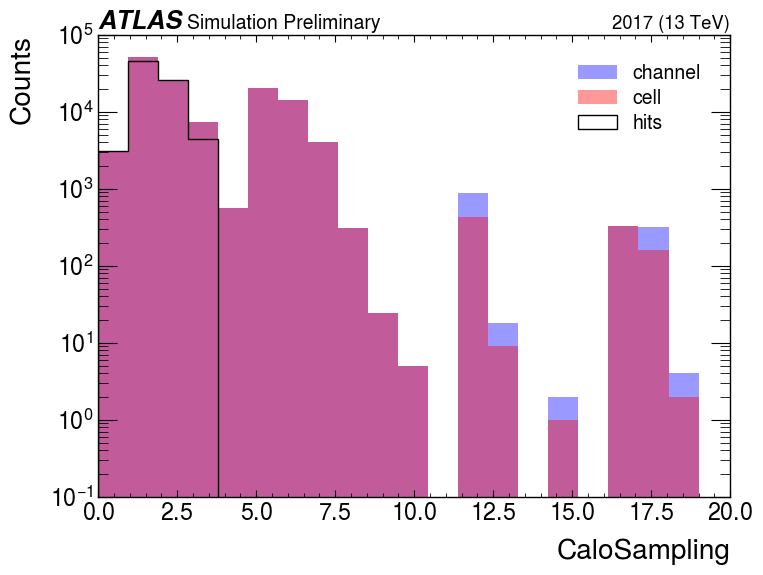

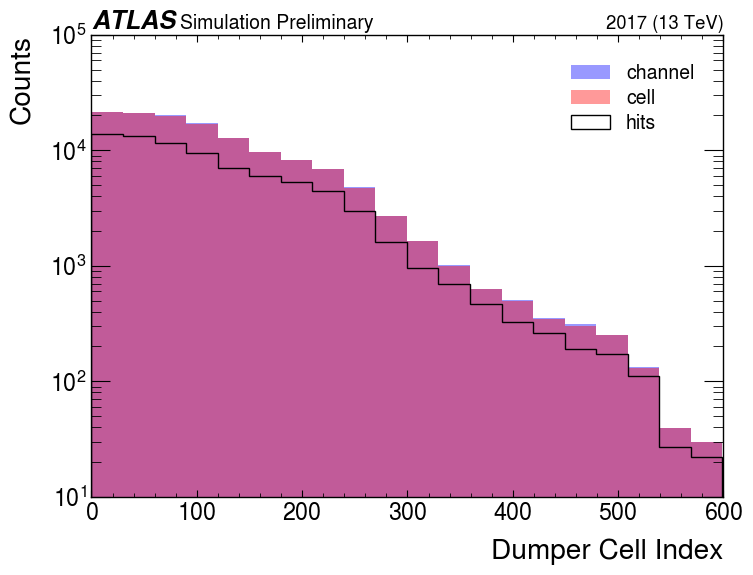

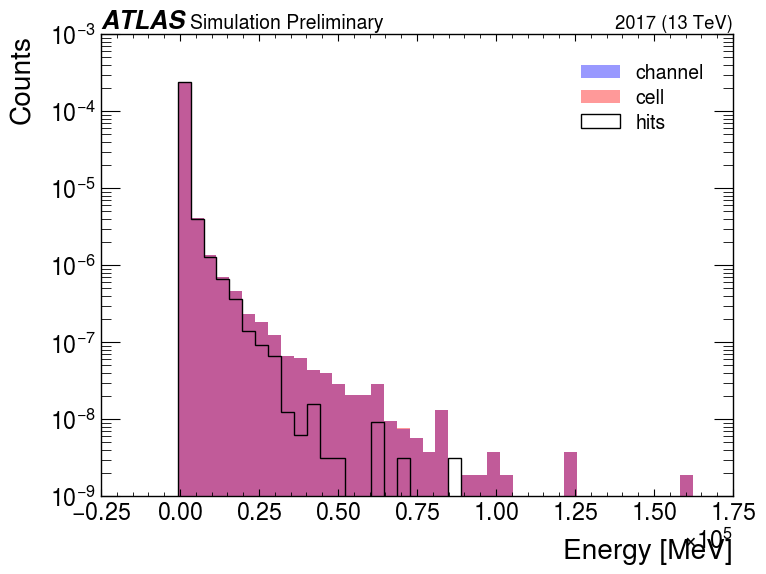

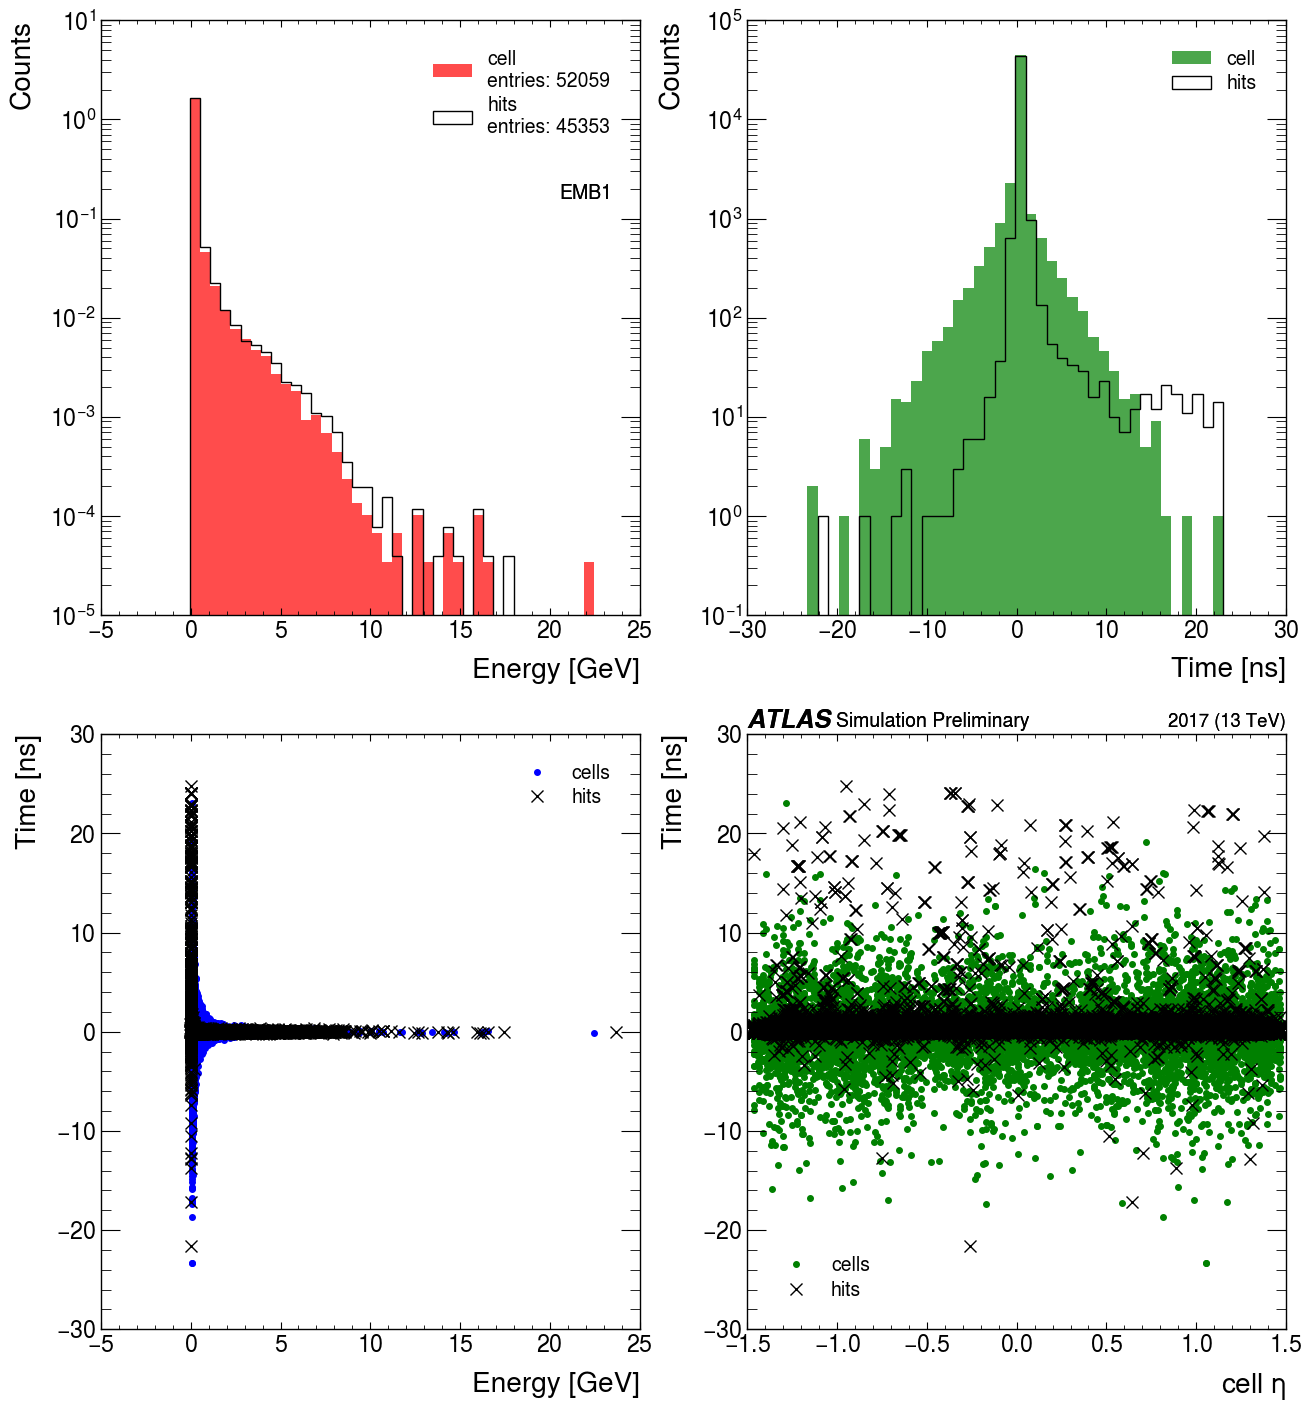

In [15]:
# channelSamplingLink = indexConversion(np.round(ak.ravel(data['cluster_channel_index'])).to_list(), ak.ravel(data['cluster_cell_index']).to_list(), ak.ravel(data['cluster_cell_layer']).to_list())
# print(channelSamplingLink, data['cluster_cell_layer'][evt].to_numpy())

plotATLAS_loc=0
plotYear=2017
samplings=['PSB','EMB1','EMB2','EMB3']

xcounts,xbins = np.histogram(ak.ravel(data['cluster_channel_layer']).to_numpy(), bins=20)
plt.hist(ak.ravel(data['cluster_channel_layer']).to_numpy() , bins=xbins,histtype='stepfilled',alpha=0.4,color='blue', label='channel')
plt.hist(ak.ravel(data['cluster_cell_layer']).to_numpy(),bins=xbins,histtype='stepfilled',alpha=0.4,color='red', label='cell')
plt.hist(ak.ravel(data['hits_sampling']).to_numpy(),bins=xbins,histtype='step',alpha=1,color='black', label='hits')
plt.yscale('log')
plt.xlabel('CaloSampling')
plt.ylabel('Counts')
plt.legend()
hep.atlas.label(data=False,paper=False,year=plotYear, loc=plotATLAS_loc)
plt.show()

xcounts,xbins = np.histogram(ak.ravel(data['cluster_channel_index']).to_numpy(), bins=20)
plt.hist(ak.ravel(data['cluster_channel_index']).to_numpy() , bins=xbins,histtype='stepfilled',alpha=0.4,color='blue', label='channel')
plt.hist(ak.ravel(data['cluster_cell_index']).to_numpy(),bins=xbins,histtype='stepfilled',alpha=0.4,color='red', label='cell')
plt.hist(ak.ravel(data['hits_clusterChannelIndex']).to_numpy(),bins=xbins,histtype='step',alpha=1,color='black', label='hits')
plt.yscale('log')
plt.xlabel('Dumper Cell Index')
plt.ylabel('Counts')
plt.legend()
hep.atlas.label(data=False,paper=False,year=plotYear, loc=plotATLAS_loc)
plt.show()

xcounts,xbins = np.histogram(ak.ravel(data['cluster_channel_energy']).to_numpy(), bins=40)
plt.hist(ak.ravel(data['cluster_channel_energy']).to_numpy() , bins=xbins,histtype='stepfilled',alpha=0.4,color='blue', label='channel',density=True)
plt.hist(ak.ravel(data['cluster_cell_energy']).to_numpy(),bins=xbins,histtype='stepfilled',alpha=0.4,color='red', label='cell',density=True)
plt.hist(ak.ravel(data['hits_energyConv']).to_numpy(),bins=xbins,histtype='step',alpha=1,color='black', label='hits',density=True)
plt.yscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Counts')
plt.legend()
hep.atlas.label(data=False,paper=False,year=plotYear, loc=plotATLAS_loc)
plt.show()

# xcounts,xbins = np.histogram(ak.ravel(data['cluster_channel_energy']).to_numpy(), bins=40)
for samp,sampName in enumerate(samplings):
    hits_idx    = data['hits_sampling'] == samp
    ch_idx      = data['cluster_channel_layer'] == samp 
    cell_idx    = data['cluster_cell_layer'] == samp 

    xcounts,xbins = np.histogram(ak.ravel(data['cluster_cell_energy'][cell_idx]).to_numpy()/1000, bins=40)
    
    fig, ([ax0,ax1],[ax2,ax3]) = plt.subplots(2,2,figsize=(15,17))
    nEntriesCell = len(ak.ravel(data['cluster_cell_energy'][cell_idx]).to_numpy())
    nEntriesHits = len(ak.ravel(data['hits_energyConv'][hits_idx]).to_numpy())

    # plt.hist(ak.ravel(data['cluster_channel_energy'][ch_idx]).to_numpy()/1000, color='blue', label='channel', histtype='stepfilled', bins=xbins, alpha=0.4)
    ax0.hist(ak.ravel(data['cluster_cell_energy'][cell_idx]).to_numpy()/1000, color='red', label='cell\nentries: {}'.format(nEntriesCell), histtype='stepfilled', bins=xbins, alpha=0.7, density=True)
    ax0.hist(ak.ravel(data['hits_energyConv'][hits_idx]).to_numpy()/1000, color='black', label='hits\nentries: {}'.format(nEntriesHits), histtype='step', bins=xbins, alpha=1., density=True)
    ax0.set_yscale('log')
    ax0.set_ylabel('Counts')
    ax0.set_xlabel('Energy [GeV]')
    ax0.legend()
    hep.atlas.label(data=False,paper=False,year=plotYear, loc=plotATLAS_loc)
    ax0.text(s='{}'.format(sampName),x=0.85,y=0.7, transform=ax0.transAxes, fontsize=14, ha='left', color='black')

    xcounts,xbins = np.histogram(ak.ravel(data['cluster_cell_time'][cell_idx]).to_numpy(), bins=40)
    
    ax1.hist(ak.ravel(data['cluster_cell_time'][cell_idx]).to_numpy(), color='green', label='cell', histtype='stepfilled', bins=xbins, alpha=0.7)
    ax1.hist(ak.ravel(data['hits_time'][hits_idx]).to_numpy(), color='black', label='hits', histtype='step', bins=xbins, alpha=1.)
    ax1.set_yscale('log')
    ax1.set_ylabel('Counts')
    ax1.set_xlabel('Time [ns]')
    ax1.legend()
    hep.atlas.label(data=False,paper=False,year=plotYear, loc=plotATLAS_loc)
    ax1.text(s='{}'.format(sampName),x=0.85,y=0.7, transform=ax0.transAxes, fontsize=14, ha='left', color='black')

    ax2.plot(ak.ravel(data['cluster_cell_energy'][cell_idx]).to_numpy()/1000, ak.ravel(data['cluster_cell_time'][cell_idx]).to_numpy(), '.',color='blue', label='cells')
    ax2.plot(ak.ravel(data['hits_energyConv'][hits_idx]).to_numpy()/1000, ak.ravel(data['hits_time'][hits_idx]).to_numpy(), 'x',color='black', label='hits')
    ax2.set_ylabel('Time [ns]')
    ax2.set_xlabel('Energy [GeV]')
    # ax2.set_xscale('log')
    ax2.legend()

    ax3.plot(ak.ravel(data['cluster_cell_eta'][cell_idx]).to_numpy(), ak.ravel(data['cluster_cell_time'][cell_idx]).to_numpy(), '.',color='green', label='cells')
    ax3.plot(ak.ravel(data['hits_cellEta'][hits_idx]).to_numpy(), ak.ravel(data['hits_time'][hits_idx]).to_numpy(), 'x',color='black', label='hits')
    ax3.set_ylabel('Time [ns]')
    ax3.set_xlabel(r'cell $\eta$')
    ax3.legend()


    plt.show()

In [91]:
thePath = '/data/atlas/mhufnage/xtalk/data_analysis/atlas_MC/hits_cells_match/'
plotFormat = 'png'

for EventIdx in range(0, len(data['cluster_cell_layer'])):
# for clusIdx in range(0,10):
    for samp,sampName in enumerate(samplings):
        # sampName    = 'EMB1'
        # samp        = 1
        # clusIdx     = 12

        hits_idx    = data['hits_sampling'] == samp
        ch_idx      = data['cluster_channel_layer'] == samp 
        cell_idx    = data['cluster_cell_layer'] == samp 

        # xcounts,xbins = np.histogram(ak.ravel(data['cluster_cell_energy'][cell_idx]).to_numpy()/1000, bins=40)

        nEntriesCell = len(data['cluster_cell_energy'][cell_idx][EventIdx])
        nEntriesHits = len(data['hits_energyConv'][hits_idx][EventIdx])

        if ((nEntriesCell != 0) or (nEntriesHits != 0)):
            hitsClusterEta     = data['hits_cellEta'][hits_idx][EventIdx]
            hitsClusterPhi     = data['hits_cellPhi'][hits_idx][EventIdx]
            cellsClusterEta    = data['cluster_cell_eta'][cell_idx][EventIdx]
            cellsClusterPhi    = data['cluster_cell_phi'][cell_idx][EventIdx]

            fig,ax0 = plt.subplots(figsize=(10,10))
            ax0.plot(cellsClusterEta, cellsClusterPhi,'s',color='red', label='cells')
            ax0.plot(hitsClusterEta, hitsClusterPhi,'x',color='black', label='hits')
            ax0.set_xlabel(r'$\eta$')
            ax0.set_ylabel(r'$\phi$')
            ax0.legend()
            fig.suptitle('Event #{} {}'.format(EventIdx,sampName))
            # ax0.text(s='{}'.format(sampName),x=0.85,y=0.7, transform=ax0.transAxes, fontsize=14, ha='left', color='black')
            hep.atlas.label(data=False,paper=False,year=plotYear, loc=plotATLAS_loc)
            hep.save_variations(fig, thePath+'MCAnalysis_hitsCellsMatch_clus{}_{}.{}'.format(EventIdx, sampName, plotFormat),text_list=["Work in Progress"])
            plt.close(fig=fig)
        # plt.show()


## 5.2) Vertex MC On-Off

In [8]:
# dataPath = '/data/atlas/mhufnage/xtalk/dataset/MC_Zee_hits_fix.root:dumpedData/'
dataPaths = [   '/data/atlas/mhufnage/xtalk/dataset/MC_Zee_100_standardBeamSpot.root:dumpedData/',
                '/data/atlas/mhufnage/xtalk/dataset/MC_Zee_100_zeroBeamSpot.root:dumpedData/',
                '/data/atlas/mhufnage/xtalk/dataset/MC_Zee_5to4samples.root:dumpedData/']
clusName = 'cluster'

# datasetPathTreeNames = [dataPath+':dumpedData/' for name in glob(datasetPath)]

start = time()
# print(fileName)
# data = ak.Array([])
# for dataPath in dataPaths:
with uproot.open(dataPaths[0], file_handler=uproot.MultithreadedFileSource,num_workers=8) as sTree:
    print('Reading branches...')
    keys = sTree.keys(filter_name=[ "vtx*", "mc_vert*", "cluster_time" , "cluster_channel_digits"])
    data = sTree.arrays()[keys]
with uproot.open(dataPaths[1], file_handler=uproot.MultithreadedFileSource,num_workers=8) as sTree:
    print('Reading branches...')
    keys = sTree.keys(filter_name=[ "vtx*", "mc_vert*", "cluster_time" , "cluster_channel_digits"])
    dataZero = sTree.arrays()[keys]
with uproot.open(dataPaths[2], file_handler=uproot.MultithreadedFileSource,num_workers=8) as sTree:
    print('Reading branches...')
    keys = sTree.keys(filter_name=[ "cluster_channel_digits" ])
    data5to4 = sTree.arrays()[keys]

print(data.fields)
print(dataZero.fields)
    

Reading branches...


Reading branches...
Reading branches...
['cluster_time', 'cluster_channel_digits', 'mc_vert_x', 'mc_vert_y', 'mc_vert_z', 'mc_vert_time', 'mc_vert_perp', 'mc_vert_eta', 'mc_vert_phi', 'mc_vert_barcode', 'mc_vert_id', 'vtx_x', 'vtx_y', 'vtx_z', 'vtx_deltaZ0', 'vtx_delta_z0_sin', 'vtx_d0sig']
['cluster_time', 'cluster_channel_digits', 'mc_vert_x', 'mc_vert_y', 'mc_vert_z', 'mc_vert_time', 'mc_vert_perp', 'mc_vert_eta', 'mc_vert_phi', 'mc_vert_barcode', 'mc_vert_id', 'vtx_x', 'vtx_y', 'vtx_z', 'vtx_deltaZ0', 'vtx_delta_z0_sin', 'vtx_d0sig']


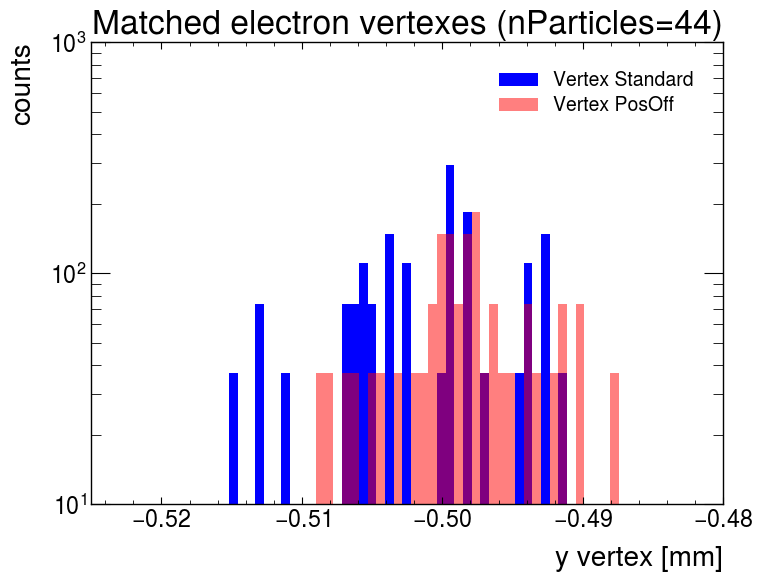

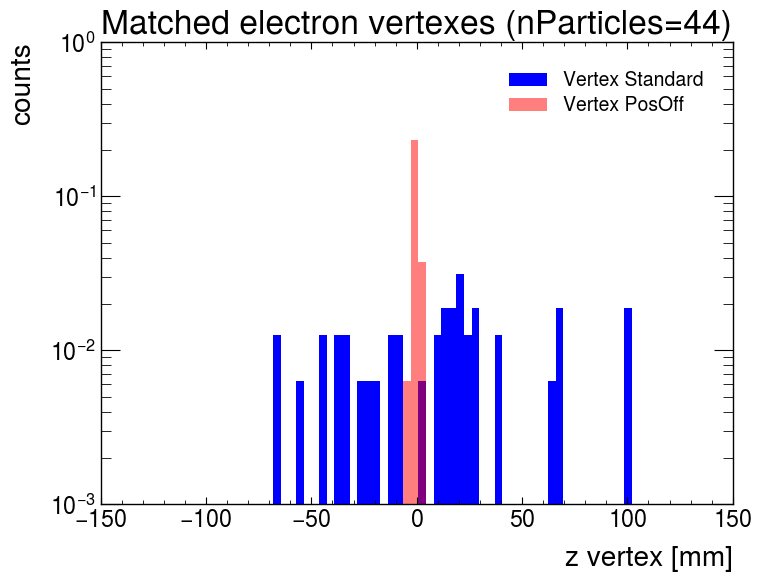

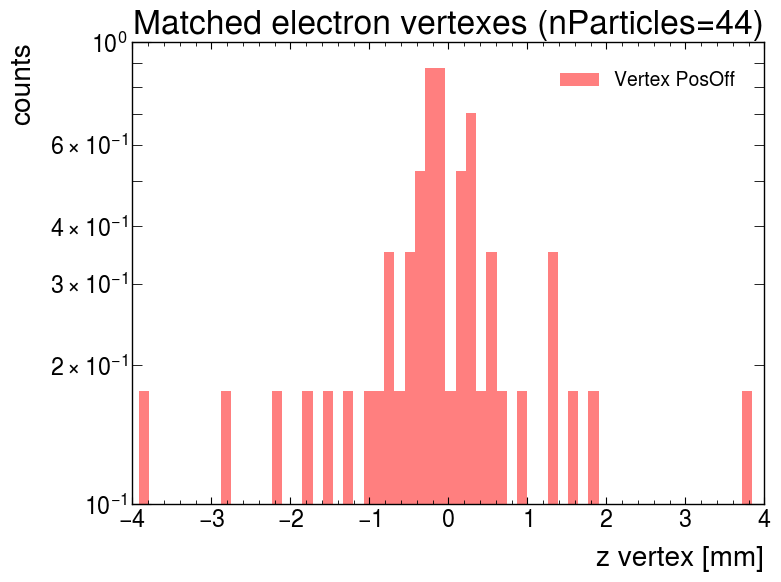

In [34]:
cl_time = ak.ravel(data['cluster_time']).to_numpy()
cl_timeZero = ak.ravel(dataZero['cluster_time']).to_numpy()

for axis in ['x','y','z']:
    vtx_data    = ak.ravel(data['vtx_{}'.format(axis)]).to_numpy()
    vtx_dataZero = ak.ravel(dataZero['vtx_{}'.format(axis)]).to_numpy()

    nElectrons   = 44
    nBins        = 60
    counts,xbins = np.histogram(vtx_data,bins=nBins)

    plt.hist(vtx_data[0:nElectrons]    , bins=xbins,density=True, label='Vertex Standard', color='blue')
    plt.hist(vtx_dataZero[0:nElectrons], bins=xbins,density=True, alpha=0.5, label='Vertex PosOff', color='red')
    plt.legend()
    plt.xlabel('{} vertex [mm]'.format(axis))
    plt.ylabel('counts')
    plt.title('Matched electron vertexes (nParticles={})'.format(len(vtx_dataZero)))
    plt.yscale('log')
    plt.show()

counts,xbins = np.histogram(vtx_dataZero,bins=nBins)
# plt.hist(vtx_data[0:nElectrons]    , bins=xbins,density=True, label='Vertex Standard')
plt.hist(vtx_dataZero[0:nElectrons], bins=xbins,density=True, alpha=0.5, label='Vertex PosOff', color='red')
plt.legend()
plt.xlabel('{} vertex [mm]'.format(axis))
plt.ylabel('counts')
plt.title('Matched electron vertexes (nParticles={})'.format(len(vtx_dataZero)))
plt.yscale('log')
plt.show()

counts,xbins = np.histogram(cl_time,bins=nBins)
plt.hist(cl_time[0:nElectrons]    , bins=xbins,density=True, label='Vertex Standard', color='blue')
plt.hist(cl_timeZero[0:nElectrons], bins=xbins,density=True, alpha=0.5, label='Vertex PosOff', color='red')
plt.legend()
plt.xlabel('time [ns]'.format(axis))
plt.ylabel('counts')
plt.title('Reco Electron TopoClusters (nParticles={})'.format(len(vtx_dataZero)))
plt.yscale('log')
plt.show()

## 5.3) 5 to 4 LArDigits

In [14]:
digSize=[]
for ev in range(0, len(data5to4['cluster_channel_digits'])):
    for k in range(0, len(data5to4['cluster_channel_digits'][ev])):
        digSize.append(len(data5to4['cluster_channel_digits'][ev][k]))

digSizeStandard=[]
for ev in range(0, len(data['cluster_channel_digits'])):
    for k in range(0, len(data['cluster_channel_digits'][ev])):
        digSizeStandard.append(len(data['cluster_channel_digits'][ev][k]))

In [26]:
# counts,xbins=np.histogram(digSize, 8)
xbins = [3.5,4.5,5.5,6.5,7.5]
plt.hist(digSize,color='blue',bins=xbins, density=True, label='ROD.flags set to 4 digits')
plt.hist(digSizeStandard,color='red',bins=xbins, alpha=0.7, density=True, label='Standard Digit.')
plt.yscale('log')
plt.legend()


## 5.4) XTalk Model

In [36]:
# import XTalkClusterModel as XTModel

from math import atan, sinh, cosh, tanh, exp, log, sqrt, sin, cos, gamma
import pandas as pd
from XTalkClusterModel import *

def XTalk_LAr(ampIndex):
    """
    This function return a Xtalk ampltude not normalized.
    ampIndex : is the LAr readout sample index (0~4 or 5). 
               it will be multiplied by 25 ns (ADC sampling time).
    x        : is the instant of time to calculate the Xtalk amplitude.

    From C++:
    Xtalk ->SetParameter(0,g_Cx);
    Xtalk ->SetParameter(1,g_Rf);
    Xtalk ->SetParameter(2,g_Rin);
    Xtalk ->SetParameter(3,g_taud);
    Xtalk ->SetParameter(4,g_taupa);
    Xtalk ->SetParameter(5,g_td);    
    Xtalk ->SetParameter(6,g_ToNormXtC); 
    """ 
    # g_ToNormXtC =   0.02242
    g_ToNormXtC = 1
    g_taud      =  15.82 
    g_taupa     =  17.31 
    g_td        = 420.00 
    g_Rf        =   0.078     
    g_Rin       =   1.20 
    g_Cx        =  47.00

    # time value (XT Transfer function input)
    x = 25*ampIndex
    
    # XT transfer function
    par = np.zeros(7)
    par[0], par[1], par[2], par[3], par[4], par[5], par[6] = g_Cx, g_Rf, g_Rin, g_taud, g_taupa, g_td, g_ToNormXtC

    xt          = (1/par[6]*((par[0]*par[1]*par[2]*(2*exp(x/par[3])*pow(par[3],2)*(x*(par[3] - par[4])*(par[4] + par[5]) + par[4]*(3*par[3]*par[4] + (2*par[3] + par[4])*par[5]))- exp(x/par[4]) * (pow(x,2)*pow(par[3] - par[4],2)*(par[3] + par[5]) - 2*x*par[3]*(par[3] - par[4])*(2*par[3]*par[4] + (par[3] + par[4])*par[5]) +  2*pow(par[3],2)*par[4]*(3*par[3]*par[4] + (2*par[3] + par[4])*par[5])) + par[3]*(-2*exp(x/par[3] + par[5]/par[4])*par[3]*par[4]*(x*(par[3] - par[4]) + 3*par[3]*par[4] + (-par[3] + par[4])*par[5]) +  exp(x/par[4] + par[5]/par[3]) * (pow(x,2)*pow(par[3] - par[4],2) + 6*pow(par[3],2)*pow(par[4],2) +  4*par[3]*(par[3] - par[4])*par[4]*par[5] + pow(par[3] - par[4],2)*pow(par[5],2) -  2*x*(par[3] - par[4]) * (2*par[3] *par[4] + (par[3] - par[4])*par[5])))*np.heaviside(x - par[5],1))))/(2.*exp(x*(1/par[3] + 1/par[4]))*par[3]*pow(par[3]- par[4],4)*par[5]))
   
    return xt

# general parameters
minTimePlot         = -75.0
maxTimePlot         = 250.0
XT_inductiveAmp     = 0.02 # in percent
timeDelayCausal     = 50.0

larshape            = pd.read_csv('/home/mhufnage/lorenzetti/fork_lzt_new/lorenzetti/geometry/ATLAS/data/pulseLar.dat', header=None,delim_whitespace=True)
tileshape           = pd.read_csv('/home/mhufnage/lorenzetti/fork_lzt_new/lorenzetti/geometry/ATLAS/data/pulseTile.dat', header=None,delim_whitespace=True)

# LAr
lartime     = larshape[0].values
lartimeSync = lartime+timeDelayCausal
laramp      = larshape[1].values
larDeriv    = np.gradient(laramp)

larshaperzeroindex      = [idx for idx,element in enumerate(lartime) if element == 0.0][0]
larminplottimeindex     = [idx for idx,element in enumerate(lartime) if element == minTimePlot]
larmaxplottimeindex     = [idx for idx,element in enumerate(lartime) if element == maxTimePlot]

# Digitization
samplerTimes        = [k-timeDelayCausal for k in [0.0, 25.0, 50.0, 75.0]]
samplerIndexes      = []
for tSampling in samplerTimes:
    tIndex = np.where(lartime == tSampling )[0][0]
    samplerIndexes.append( tIndex )

# XT
XT_scale            = 1/XT_inductiveAmp/2
XTamplitudeValues   = []
for t in lartimeSync:
    if t < 0.0:
        XTamplitudeValues.append(0)
    else:
        XTamplitudeValues.append(XTalk(t)*XT_inductiveAmp )

XTDeriv = np.gradient(XTamplitudeValues)

In [37]:
plt.figure()
plt.plot(lartime, [k*XT_scale for k in XTamplitudeValues], label='{}% XT Cap. x{}'.format(int(XT_inductiveAmp*100),int(XT_scale)),color='blue',lw=1.7, ls='dotted')
# plt.plot(lartime, [k*XT_scale for k in XTDeriv], label='{}% XT Cap. Deriv. x{}'.format(int(XT_inductiveAmp*100),int(XT_scale)),color='gray',lw=1.7, ls='dotted')
plt.plot(lartime, laramp, label='LAr Pulse Shape', color='red',lw=1.7, ls='dotted')
plt.plot(lartime, larDeriv, label='LAr Pulse Shape Deriv.', color='green',lw=1.7, ls='dotted')
plt.plot(lartime, laramp+XTamplitudeValues, label='Resultant LAr readout', color='black',lw=1.7)
plt.plot(samplerTimes, laramp[samplerIndexes], marker='o', color='red',ls='none', label='Sample w/o XT')
plt.plot(samplerTimes, larDeriv[samplerIndexes], marker='o', color='green',ls='none', label='Sample LAr deriv.')
plt.plot(samplerTimes, np.array([laramp+XTamplitudeValues]).flatten()[samplerIndexes], marker='o', color='black',ls='none', label='Sample w/ XT')
plt.xlim([-75,125])
plt.xlabel('Time [ns]')
plt.ylabel('Normalized amplitude')
plt.legend()
plt.grid()
plt.show()

## 5.5) OFCs
[Link to article that describes the OF at LAr](https://www-sciencedirect-com.ezproxy.cern.ch/science/article/pii/0168900294913323?ref=cra_js_challenge&fr=RR-1)

In [39]:
def generateOFCs_LAr(C, g, dg):
   
    nSamples    = len(g)

    # for amplitude
    lamb    = 1
    ksi     = 0
    gamma   = 0
    # for timing
    mu      = 0
    rho     = -1

    u = nSamples*[0] + [lamb, ksi, gamma]# a = inv(A)*u
    v = nSamples*[0] + [mu, rho]         # b = inv(B)*v

    A = np.zeros((nSamples+3,nSamples+3)) 
    B = np.zeros((nSamples+2,nSamples+2)) 

    A[0:nSamples,0:nSamples]    = C
    A[0:nSamples,nSamples]      = g
    A[nSamples,0:nSamples]      = g
    A[0:nSamples,nSamples+1]    = dg
    A[nSamples+1,0:nSamples]    = dg
    A[0:nSamples,nSamples+2]    = 1
    A[nSamples+2,0:nSamples]    = 1

    B[0:nSamples,0:nSamples]    = C
    B[0:nSamples,nSamples]      = g
    B[nSamples,0:nSamples]      = g
    B[0:nSamples,nSamples+1]    = dg
    B[nSamples+1,0:nSamples]    = dg

    a = np.dot(np.linalg.inv(A),u)
    b = np.dot(np.linalg.inv(B),v)

    return a[0:nSamples],b[0:nSamples]

C   = np.identity(4)
g   = laramp[samplerIndexes]
dg  = larDeriv[samplerIndexes]
a,b = generateOFCs_LAr(C, g, dg)

amp     = np.dot(g, a)
tau     = np.dot(g, b)/amp
ampxt   = np.dot(np.array([laramp+XTamplitudeValues]).flatten()[samplerIndexes],a)
tauxt   = np.dot(np.array([laramp+XTamplitudeValues]).flatten()[samplerIndexes],b)/amp

print('A = {:.3f} ADC\ntau = {:.3f} ns\nA_xt = {:.3f} ADC\ntau_xt = {:.3f} ns'.format(amp, tau, ampxt, tauxt))

A = 1.000 ADC
tau = 0.000 ns
A_xt = 1.002 ADC
tau_xt = -0.067 ns


## 5.6) MC Cluster with XTalk

In [2]:
dataPath = '/data/atlas/mhufnage/xtalk/dataset/MC_Zee_100_standardBeamSpot.root:dumpedData/'
# dataPath = '/data/atlas/mhufnage/xtalk/dataset/MC_Zee_100_standardBeamSpot.root:dumpedData/'
clusName = 'cluster'

# datasetPathTreeNames = [dataPath+':dumpedData/' for name in glob(datasetPath)]

start = time()
# print(fileName)
# data = ak.Array([])
with uproot.open(dataPath, file_handler=uproot.MultithreadedFileSource,num_workers=8) as sTree:

    print('Reading branches...')
    keys = sTree.keys(filter_name=["cluster_cell_*",
                                   "cluster_channel_*",])
    data = sTree.arrays()[keys]



Reading branches...


In [3]:
def XTalkCluster(ene,samples,eta,phi,deta,dphi,ch_index,sampling='EMB2',nDigits=4):
    '''The inputs are single clusters and their properties, at channel level.
    Also, their must belong to the same sampling layer.
    
    '''
    # Cross-Talk amplitude map: (in %)
    xtAmpMapCap = {'PSB' : 0,
    'EMB1': 4.78,
    'EMB2': 1,
    'EMB3': 0,
    }
    xtAmpMapInd = {'PSB' : 0,
    'EMB1': 0,
    'EMB2': 3,
    'EMB3': -0.72,
    }

    XTClusterSamples = []

    # central cells    
    for cIdx, cell in enumerate(samples): 
        cells_around = {'samples': [],'eta':[], 'phi':[], 'cIdx':[], 'index': []}

        # neighbor cells
        for nIdx, neighbor in enumerate(samples):
            if (ch_index[cIdx] == ch_index[nIdx]): # same cell, continue...
                continue
            etaDiff = abs(calcDeltaEta( eta[cIdx], eta[nIdx] ))
            phiDiff = abs(correctedDeltaPhi( phi[cIdx], phi[nIdx] ))

            # 3x3 window around central cell
            if ( (etaDiff <= 3*deta[cIdx]/2) and (phiDiff <=3*dphi[cIdx]) ):
                cells_around['samples'] .append( samples[nIdx] ) # or neighbor
                cells_around['eta']     .append( eta[nIdx] )
                cells_around['phi']     .append( phi[nIdx] )
                cells_around['cIdx']    .append( cIdx )
                cells_around['index']   .append( ch_index[nIdx] )

        # Loop over cells_around
        
        neighborXTPulse   = np.zeros((3*3, nDigits))
        for xtIdx, cellXT in enumerate(cells_around['samples']):            
            # diagonal case (only inductive)
            samplesWithXT_ind = []
            samplesWithXT_cap = []
            if ( (cells_around['eta'][xtIdx] != eta[cIdx]) and (cells_around['phi'][xtIdx] != phi[cIdx]) ):
                for digit_index in range(0, nDigits):
                    digit_xt_ind = cellXT[digit_index] * xtAmpMapInd[sampling]/100 * XTalk_LAr(digit_index)
                    digit_xt_cap = 0 #cellXT[digit_index] * xtAmpMapCap[sampling]/100 * XTalk_LAr(digit_index)
                    
                    samplesWithXT_ind.append(digit_xt_ind)
                    samplesWithXT_cap.append(digit_xt_cap)
            # cross case (capacitive and inductive)
            else:
                for digit_index in range(0, nDigits):
                    digit_xt_ind = cellXT[digit_index] * xtAmpMapInd[sampling]/100 * XTalk_LAr(digit_index)
                    digit_xt_cap = cellXT[digit_index] * xtAmpMapCap[sampling]/100 * XTalk_LAr(digit_index)
                
                    samplesWithXT_ind.append(digit_xt_ind)
                    samplesWithXT_cap.append(digit_xt_cap)
            neighborXTPulse[xtIdx, :] = np.array(samplesWithXT_ind) + np.array(samplesWithXT_cap)

        # sum all xt effects of neighbor cells
        finalXTPulse = np.sum(neighborXTPulse,axis=0)

        # add total pulse distortion from neighbors, into central cell
        XTClusterSamples.append((np.array(cell) + finalXTPulse).tolist())
    return XTClusterSamples

        


In [31]:
plotATLAS_loc   =0
plotYear        =2017
samplings       =['EMB2']
typeThreshold   ='MC'
bAbsDSPE1       = False
bDigitsWithPed  = True
# samplings=['PSB','EMB1','EMB2','EMB3']

xtcluster = {'samples':[], 'energy':[], 'time':[]}
cluster   = {'samples':[], 'energy':[], 'time':[]}

for event in range(0, len(data)):
    # xcounts,xbins = np.histogram(ak.ravel(data['cluster_channel_energy']).to_numpy(), bins=40)
    for samp,sampName in enumerate(samplings):
        layer       = data['cluster_channel_layer'][event] == samp
        layerCell   = data['cluster_cell_layer'][event] == samp
        ene         = data['cluster_channel_energy'][event][layer]
        digits      = data['cluster_channel_digits'][event][layer]
        ofca        = data['cluster_channel_OFCa'][event][layer].to_numpy()
        ofcb        = data['cluster_channel_OFCb'][event][layer].to_numpy()
        adc2Mev0    = data['cluster_channel_ADC2MeV0'][event][layer].to_numpy()
        adc2Mev1    = data['cluster_channel_ADC2MeV1'][event][layer].to_numpy()
        channelId   = data['cluster_channel_id'][event][layer].to_numpy()
        peds        = data['cluster_channel_pedestal'][event][layer].to_numpy()
        ofcTimeOff  = data['cluster_channel_OFCTimeOffset'][event][layer].to_numpy()
        if typeThreshold!='MC':
            DSPThr      = data['cluster_channel_DSPThreshold'][event][layer].to_numpy()
        else:
            DSPThr      = 0

        eta         = indexConversion( data['cluster_channel_index'][event][layer].tolist() , data['cluster_cell_index'][event][layerCell].tolist(), data['cluster_cell_eta'][event][layerCell].tolist())
        phi         = indexConversion( data['cluster_channel_index'][event][layer].tolist() , data['cluster_cell_index'][event][layerCell].tolist(), data['cluster_cell_phi'][event][layerCell].tolist())
        deta        = indexConversion( data['cluster_channel_index'][event][layer].tolist() , data['cluster_cell_index'][event][layerCell].tolist(), data['cluster_cell_deta'][event][layerCell].tolist())
        dphi        = indexConversion( data['cluster_channel_index'][event][layer].tolist() , data['cluster_cell_index'][event][layerCell].tolist(), data['cluster_cell_dphi'][event][layerCell].tolist())
        gain        = indexConversion( data['cluster_channel_index'][event][layer].tolist() , data['cluster_cell_index'][event][layerCell].tolist(), data['cluster_cell_caloGain'][event][layerCell].tolist())
        ch_index    = data['cluster_channel_index'][event][layer]

        digitsXT   = XTalkCluster(ene,digits,eta,phi,deta,dphi,ch_index,sampling='EMB2',nDigits=5) # generate cluster samples with XT
        
        _, TauOnline, Eonline, _ , _    = DSPCalibSamplesInCluster(channelId, digits, gain, peds, ofca, ofcb, adc2Mev0, adc2Mev1, DSPThr, ofcTimeOff,  thresholdMode=typeThreshold, bDoAbsE1=bAbsDSPE1,bDigitsWithPed=bDigitsWithPed)
        _, TauOnlineXT, EonlineXT, _, _ = DSPCalibSamplesInCluster(channelId, digitsXT, gain, peds, ofca, ofcb, adc2Mev0, adc2Mev1, DSPThr, ofcTimeOff,  thresholdMode=typeThreshold, bDoAbsE1=bAbsDSPE1,bDigitsWithPed=bDigitsWithPed)

        xtcluster['samples'].append(digitsXT)
        xtcluster['energy'].append(EonlineXT)
        xtcluster['time'].append(TauOnlineXT)
        cluster['samples'].append(digits.tolist())
        cluster['energy'].append(Eonline)
        cluster['time'].append(Eonline)


        
# np.array(cluster,dtype=object)
def flatten(l):
    '''Flatten a list of lists.'''
    return [item for sublist in l for item in sublist]

samples     = np.concatenate(flatten(cluster['samples']))
samplesXT   = np.concatenate(flatten(xtcluster['samples']))
energies    = np.array(flatten(cluster['energy']),dtype=object)
energiesXT  = np.array(flatten(xtcluster['energy']),dtype=object)
times       = np.array(flatten(cluster['time']),dtype=object)/1000 # ps to ns
timesXT     = np.array(flatten(xtcluster['time']),dtype=object)/1000 # ps to ns


In [16]:
np.concatenate(flatten(cluster['energy']))

ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
plt.hist2d(np.asarray(tau_online).reshape(len(tau_online)), np.asarray(diffTauOnCalibDSP).reshape(len(diffTauOnCalibDSP)),bins=[xbins,xbins], cmin=1, range=[[-10000,10000],[-30,30]],norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
plt.plot([-10000,10000],[10, 10], '--r',label='10 ps precision')
plt.plot([-10000,10000],[-10, -10], '--r')
plt.title('Cell DSP Calibrated Energy from Offline in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
plt.xlabel(r'$\tau_{online}$',fontsize=labelFontSize)
plt.colorbar()

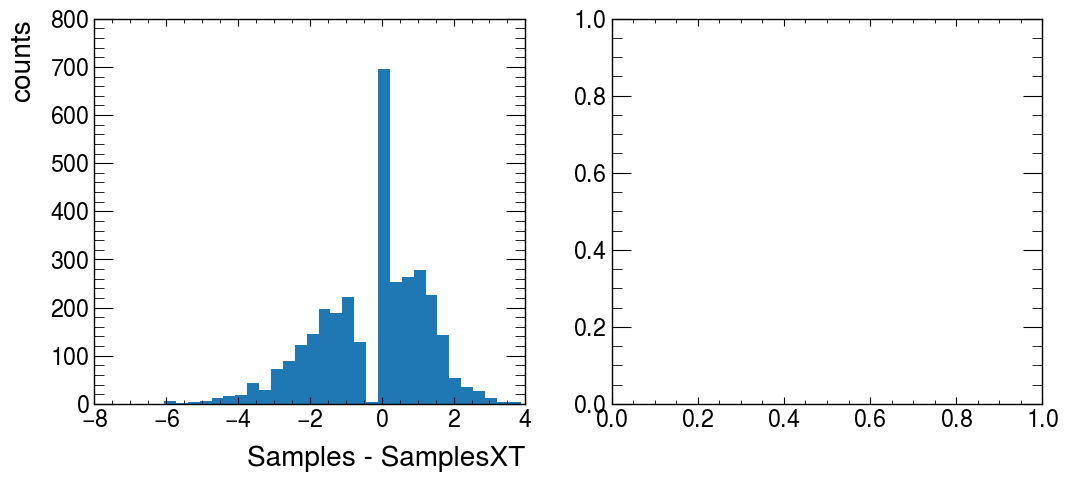

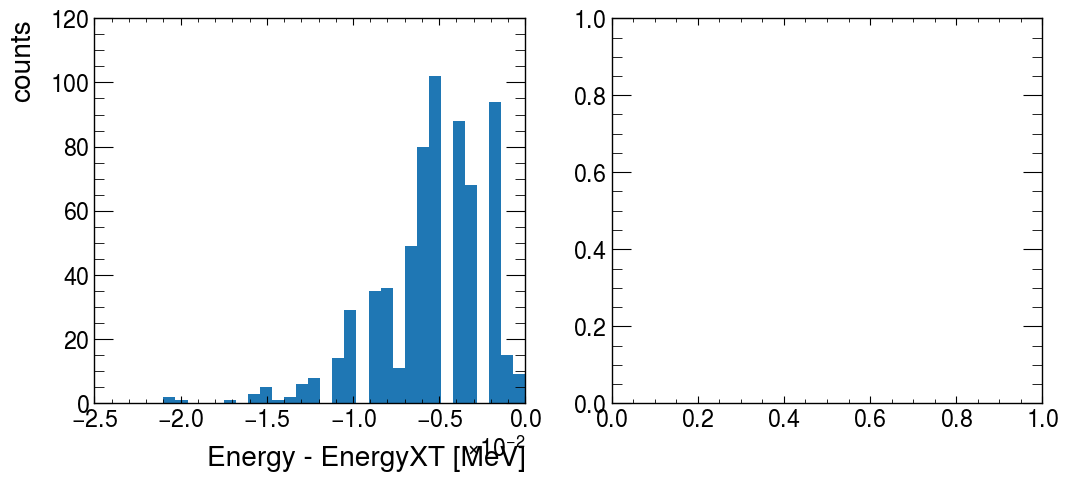

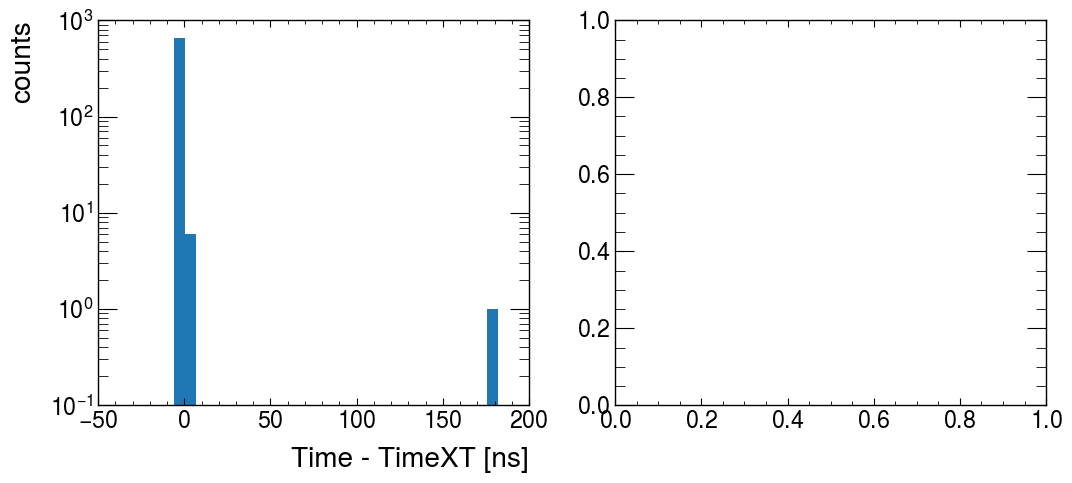

In [33]:
fig, ([ax0,ax1]) = plt.subplots(1,2,figsize=(12,5))
ax0.hist(samples-samplesXT,bins=30)
ax0.set_xlabel('Samples - SamplesXT')
ax0.set_ylabel('counts')
ax1.bins=[xbins,xbins], cmin=1, range=[[-10000,10000],[-30,30]],norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
plt.show()

fig, ([ax0,ax1]) = plt.subplots(1,2,figsize=(12,5))
ax0.hist(energies-energiesXT,bins=30)
ax0.set_xlabel('Energy - EnergyXT [MeV]')
ax0.set_ylabel('counts')
ax1.
plt.show()

fig, ([ax0,ax1]) = plt.subplots(1,2,figsize=(12,5))
ax0.hist(times-timesXT,bins=30)
ax0.set_xlabel('Time - TimeXT [ns]')
ax0.set_ylabel('counts')
ax0.set_yscale('log')
ax1.
plt.show()

In [91]:
# indexConversion( data['cluster_channel_index'][event][layer].tolist() , data['cluster_cell_index'][event][layerCell].tolist(), data['cluster_cell_eta'][event][layer].tolist())
data['cluster_channel_index'][event][layer]

<Array [79, 24, 80, 226] type='4 * float32'>

# END

In [10]:
### Print runs lists from AMI using GRL
source /afs/cern.ch/atlas/software/tools/pyAMI/setup.sh 
ami list datasets --type DAOD_EGAM3 --grl /cvmfs/atlas.cern.ch/repo/sw/database/GroupData/GoodRunsLists/data23_13p6TeV/20230626/data23_13p6TeV.periodAllYear_DetStatus-v110-pro31-04_MERGED_PHYS_StandardGRL_All_Good_25ns.xml

7.833597206108052